## Install dependencies

In [1]:
!pip install optuna joblib xgboost ta vnstock

  Preparing metadata (setup.py) ... - done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29413 sha256=c0355e1329a16515f3828c233d4484bdb72f4a49dfb32de12f48f90681f5ccd4
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [2]:
!pip install --upgrade pandas-ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Created wheel for pandas-ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218910 sha256=123bebb9cc10f46d455d2a215b98127ad57ba00f9b7b41c6cb0d06c6c1866894
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas-ta


In [3]:
from datetime import datetime, timedelta, timezone
import pandas as pd
import numpy as np
import requests
import os
import logging
import sys
import optuna
import joblib
import xgboost as xgb

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from datetime import datetime, timedelta
from ta import add_all_ta_features
import pandas_ta as ta
from sklearn.ensemble import GradientBoostingRegressor

In [5]:
import matplotlib.pyplot as plt
import matplotlib

## Variables

In [6]:
current_storage = os.path.join("d:", "data")
vn30f_storage = os.path.join(current_storage, 'vn30f')

In [7]:
start_time = 0
now_time = 9999999999
symbol = 'VN30F1M'
rolling_window = 1 # Số phút muốn dự đoán tiếp theo

In [8]:
# Add stream handler of stdout to show the messages
optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))
study_name = "btc1-study"  # Unique identifier of the study.
storage_name = "sqlite:///{}.db".format(study_name)

## Formulas

In [9]:
def choose_position(roi, trade_threshold = 0.0005):
    pos =0
    # Predict position base on change in future
    if roi > trade_threshold:
        pos = 1
    elif roi < -trade_threshold:
        pos = -1
    else:
        pos = 0

    return pos

In [10]:
def backtest_position_ps(position, price, percentage, periods):
    # Shift positions to align with future price changes and handle NaN by filling with 0
    pos = pd.Series(position, index=pd.Series(price).index).shift(1).fillna(0)
    pos = pd.Series(pos).rolling(periods).sum() #pos for 10 hour predict

    price_array = pd.Series(price).shift(1).fillna(0)

    pos_diff = pos.diff()
    fee = pos_diff*price_array*0.05*0.01

    # Calculate price changes over the given periods
    ch = pd.Series(price) - price_array

    # Calculate total PnL
    total_pnl = pos*ch - fee
    return total_pnl

In [11]:
def calculate_sharpe_ratio(pnl):
    pnl = np.diff(pnl)
    std = np.std(pnl) if np.std(pnl) != 0 else 0.001
    sharpe = np.mean(pnl)/std*np.sqrt(252)
    return sharpe

In [12]:
def sharpe_for_vn30f(y_pred, y_price, trade_threshold, fee_perc, periods):

    # Predict position base on change in future
    pos = [choose_position(roi, trade_threshold) for roi in y_pred]
    pos = np.array(pos)

    # Calculate PNL
    pnl = backtest_position_ps(pos, y_price, fee_perc, periods)
    pnl = np.cumsum(pnl)

    # Standardalize PNL to date
    daily_pnl = [pnl.iloc[i] for i in range(0, len(pnl), 241)]
    daily_pnl = pd.Series(daily_pnl).fillna(0)

    # Calculate Sharpe
    sharpe = calculate_sharpe_ratio(daily_pnl)

    return pos, pnl, daily_pnl, sharpe

In [13]:
def calculate_hitrate(pos_predict, pos_true):
    if len(pos_predict) != len(pos_true):
        raise ValueError("Độ dài của hai mảng không khớp")

    # Tính số lượng dự đoán đúng (các phần tử tương ứng giống nhau)
    correct_predictions = np.sum(pos_predict == pos_true)

    # Tính tỷ lệ hit rate
    hit_rate_value = correct_predictions / len(pos_predict)

    return hit_rate_value

# Function for data

In [14]:
def scale_data(data):
    scaler = StandardScaler()
    data = np.where(np.isinf(data), np.nan, data)
    data = pd.DataFrame(data)
    data = data.fillna(0)
    scaler.fit(data)
    data=pd.DataFrame(scaler.transform(data), index=data.index, columns=data.columns)

    return data

In [15]:
def split_data(data):
    """
    Hàm này chia dữ liệu thành 2 phần: tập huấn luyện và tập hold out.

    Args:
    data (pandas.DataFrame): DataFrame chứa dữ liệu cần chia.

    Returns:
    pandas.DataFrame: DataFrame chứa dữ liệu tập huấn luyện.
    pandas.DataFrame: DataFrame chứa dữ liệu tập giữ lại.
    """
    # Chia dữ liệu thành 3 phần
    new_part = np.array_split(data, 3)

    # Access each part individually
    hold_out = new_part[2]
    train_data = pd.concat([new_part[0], new_part[1]], axis=0)

    return train_data, hold_out

def split_optuna_data(data):
    """
    Hàm này chia dữ liệu thành các tập train và test để sử dụng trong quá trình tối ưu hóa bằng Optuna.

    Args:
    data (pandas.DataFrame): DataFrame chứa dữ liệu cần chia.

    Returns:
    pandas.DataFrame: DataFrame chứa dữ liệu train (đã được chuẩn hóa).
    pandas.DataFrame: DataFrame chứa dữ liệu test (đã được chuẩn hóa).
    pandas.Series: Series chứa nhãn tương ứng với dữ liệu train.
    pandas.Series: Series chứa nhãn tương ứng với dữ liệu test.
    """
    # Chia dữ liệu thành tập train và tập hold out
    train_data, _ = split_data(data)

    # Loại bỏ các cột không cần thiết
    if 'Open' in train_data.columns:
        optuna_data = train_data.drop(['Open','High','Low','Close','Volume', 'Return', 'Date', 'time'], axis=1)
    else:
        optuna_data = train_data.drop(['Close', 'Return', 'Date', 'time'], axis=1)

    # Chuẩn hóa dữ liệu
    optuna_data = scale_data(optuna_data)

    # Chia dữ liệu thành tập train và tập test
    X_train, X_valid, y_train, y_valid = train_test_split(optuna_data, train_data['Return'], test_size=0.5, shuffle=False)

    return X_train, X_valid, y_train, y_valid, train_data

## Get data

In [16]:
def get_vn30f(start_time, now_time, symbol):
    def vn30f():
            return requests.get(f"https://services.entrade.com.vn/chart-api/chart?from={start_time}&resolution=1&symbol={symbol}&to={now_time}").json()
    vn30fm = pd.DataFrame(vn30f()).iloc[:,:6]
    vn30fm['t'] = vn30fm['t'].astype(int).apply(lambda x: datetime.utcfromtimestamp(x) + timedelta(hours = 7))
    vn30fm.columns = ['Date','Open','High','Low','Close','Volume']
    ohlc_dict = {
        'Open': 'first',
        'High': 'max',
        'Low': 'min',
        'Close': 'last',
        'Volume': 'sum',}
    vn30fm = pd.DataFrame(vn30f()).iloc[:,:6]
    vn30fm['t'] = vn30fm['t'].astype(int).apply(lambda x: datetime.utcfromtimestamp(x) + timedelta(hours = 7))
    vn30fm.columns = ['Date','Open','High','Low','Close','Volume']
    dt_object = datetime.utcfromtimestamp(start_time) + timedelta(hours = 7)
    now_object = datetime.utcfromtimestamp(now_time) + timedelta(hours = 7)

    print(f'===> Data {symbol} from {dt_object} to {now_object} has been appended ')

    return vn30fm

In [17]:
df = get_vn30f(start_time, now_time, symbol)

===> Data VN30F1M from 1970-01-01 07:00:00 to 2286-11-21 00:46:39 has been appended 


In [18]:
df

,Date,Open,High,Low,Close,Volume
0,2018-08-13 09:00:00,943.5,943.5,942.9,942.9,975
1,2018-08-13 09:01:00,943.0,943.1,942.9,943.1,220
2,2018-08-13 09:02:00,943.0,943.6,943.0,943.5,121
3,2018-08-13 09:03:00,943.3,943.4,943.3,943.4,135
4,2018-08-13 09:04:00,943.2,943.2,943.0,943.1,361
...,...,...,...,...,...,...
325152,2024-07-01 14:27:00,1284.5,1284.9,1284.1,1284.9,1020
325153,2024-07-01 14:28:00,1284.7,1285.0,1283.9,1283.9,1805
325154,2024-07-01 14:29:00,1283.9,1284.8,1283.7,1284.8,1786
325155,2024-07-01 14:30:00,1284.8,1284.8,1284.8,1284.8,134


Fill missing data

In [19]:
from vnstock import stock_historical_data
df2 = stock_historical_data("VN30F1M", "2023-04-01", "2023-07-31", "3", 'derivative')
df2


The 'end_date' value in the report should be no more than 90 days from today for all resolutions shorter than 1 day. 



,time,open,high,low,close,volume,ticker
0,2023-04-03 09:00:00,1081.3,1082.6,1080.6,1080.6,10331,VN30F1M
1,2023-04-03 09:03:00,1080.7,1081.2,1080.4,1080.4,4257,VN30F1M
2,2023-04-03 09:06:00,1080.4,1080.4,1078.4,1078.9,5101,VN30F1M
3,2023-04-03 09:09:00,1078.9,1079.0,1077.0,1077.9,5891,VN30F1M
4,2023-04-03 09:12:00,1077.9,1078.5,1077.5,1078.3,3498,VN30F1M
...,...,...,...,...,...,...,...
6884,2023-07-31 14:21:00,1223.2,1225.4,1223.2,1224.7,5733,VN30F1M
6885,2023-07-31 14:24:00,1224.6,1228.8,1224.2,1228.5,6276,VN30F1M
6886,2023-07-31 14:27:00,1227.8,1231.8,1227.8,1231.8,6975,VN30F1M
6887,2023-07-31 14:30:00,1231.9,1232.0,1231.9,1232.0,195,VN30F1M


In [20]:
temp = df2.drop(columns=['ticker'])
temp

,time,open,high,low,close,volume
0,2023-04-03 09:00:00,1081.3,1082.6,1080.6,1080.6,10331
1,2023-04-03 09:03:00,1080.7,1081.2,1080.4,1080.4,4257
2,2023-04-03 09:06:00,1080.4,1080.4,1078.4,1078.9,5101
3,2023-04-03 09:09:00,1078.9,1079.0,1077.0,1077.9,5891
4,2023-04-03 09:12:00,1077.9,1078.5,1077.5,1078.3,3498
...,...,...,...,...,...,...
6884,2023-07-31 14:21:00,1223.2,1225.4,1223.2,1224.7,5733
6885,2023-07-31 14:24:00,1224.6,1228.8,1224.2,1228.5,6276
6886,2023-07-31 14:27:00,1227.8,1231.8,1227.8,1231.8,6975
6887,2023-07-31 14:30:00,1231.9,1232.0,1231.9,1232.0,195


In [21]:
temp['time'] = pd.to_datetime(temp['time'])

In [22]:
morning_start = pd.Timestamp('09:00:00').time()
morning_end = pd.Timestamp('11:30:00').time()
afternoon_start = pd.Timestamp('13:00:00').time()
afternoon_end = pd.Timestamp('14:30:00').time()
ATC = pd.Timestamp('14:45:00').time()

time_points = []
current_time = morning_start

while current_time <= morning_end:
    time_points.append(current_time)
    current_time = (pd.Timestamp.combine(pd.Timestamp.today(), current_time) + pd.Timedelta(minutes=1)).time()

current_time = afternoon_start
while current_time <= afternoon_end:
    time_points.append(current_time)
    current_time = (pd.Timestamp.combine(pd.Timestamp.today(), current_time) + pd.Timedelta(minutes=1)).time()

current_time = ATC
while current_time == ATC:
    time_points.append(current_time)
    current_time = (pd.Timestamp.combine(pd.Timestamp.today(), current_time) + pd.Timedelta(minutes=1)).time()

temp = temp.set_index('time')
df_resampled = temp.resample('1T').first().reindex(pd.date_range(start=temp.index[0], end=temp.index[-1], freq='1T')).ffill()

df_resampled = df_resampled.reset_index().rename(columns={'index': 'time'})
temp = temp.reset_index().rename(columns={'index': 'time'})

df_resampled = df_resampled[df_resampled['time'].dt.time.isin(time_points)]
df_resampled = df_resampled.rename(columns={
    'time': 'Date',
    'open': 'Open',
    'high': 'High',
    'low': 'Low',
    'close': 'Close',
    'volume': 'Volume'
})

# Divide the Volume column by 3 and round to the nearest integer
df_resampled['Volume'] = df_resampled.apply(
    lambda row: round(row['Volume'] / 3) if row['Date'].time() < pd.Timestamp('14:30:00').time() else row['Volume'],
    axis=1
)

df_resampled

/tmp/ipykernel_18/1441089219.py:25: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_resampled = temp.resample('1T').first().reindex(pd.date_range(start=temp.index[0], end=temp.index[-1], freq='1T')).ffill()


,Date,Open,High,Low,Close,Volume
0,2023-04-03 09:00:00,1081.3,1082.6,1080.6,1080.6,3444.0
1,2023-04-03 09:01:00,1081.3,1082.6,1080.6,1080.6,3444.0
2,2023-04-03 09:02:00,1081.3,1082.6,1080.6,1080.6,3444.0
3,2023-04-03 09:03:00,1080.7,1081.2,1080.4,1080.4,1419.0
4,2023-04-03 09:04:00,1080.7,1081.2,1080.4,1080.4,1419.0
...,...,...,...,...,...,...
171687,2023-07-31 14:27:00,1227.8,1231.8,1227.8,1231.8,2325.0
171688,2023-07-31 14:28:00,1227.8,1231.8,1227.8,1231.8,2325.0
171689,2023-07-31 14:29:00,1227.8,1231.8,1227.8,1231.8,2325.0
171690,2023-07-31 14:30:00,1231.9,1232.0,1231.9,1232.0,195.0


In [23]:

combined_data = pd.merge(df, df_resampled, on='Date', how='outer', suffixes=('', '_data1'))

for column in ['Open', 'High', 'Low', 'Close', 'Volume']:
    combined_data[column].fillna(combined_data[f'{column}_data1'], inplace=True)

combined_data.drop(columns=[f'{column}_data1' for column in ['Open', 'High', 'Low', 'Close', 'Volume']], inplace=True)


combined_data.sort_values('Date', inplace=True)

combined_data.reset_index(drop=True, inplace=True)

/tmp/ipykernel_18/967041502.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined_data[column].fillna(combined_data[f'{column}_data1'], inplace=True)


In [24]:
combined_data

,Date,Open,High,Low,Close,Volume
0,2018-08-13 09:00:00,943.5,943.5,942.9,942.9,975.0
1,2018-08-13 09:01:00,943.0,943.1,942.9,943.1,220.0
2,2018-08-13 09:02:00,943.0,943.6,943.0,943.5,121.0
3,2018-08-13 09:03:00,943.3,943.4,943.3,943.4,135.0
4,2018-08-13 09:04:00,943.2,943.2,943.0,943.1,361.0
...,...,...,...,...,...,...
354069,2024-07-01 14:27:00,1284.5,1284.9,1284.1,1284.9,1020.0
354070,2024-07-01 14:28:00,1284.7,1285.0,1283.9,1283.9,1805.0
354071,2024-07-01 14:29:00,1283.9,1284.8,1283.7,1284.8,1786.0
354072,2024-07-01 14:30:00,1284.8,1284.8,1284.8,1284.8,134.0


In [25]:
data=combined_data

In [26]:
df[
    (df['Date'] >= '2023-04-01') & (df['Date'] <= '2023-08-01')
]

,Date,Open,High,Low,Close,Volume
278507,2023-05-31 09:00:00,1067.7,1067.7,1066.8,1067.3,1860
278508,2023-05-31 09:01:00,1067.2,1067.3,1067.1,1067.2,641
278509,2023-05-31 09:02:00,1067.2,1068.1,1067.1,1068.1,724
278510,2023-05-31 09:03:00,1067.9,1068.1,1067.9,1068.0,428
278511,2023-05-31 09:04:00,1068.0,1068.1,1068.0,1068.1,312
...,...,...,...,...,...,...
278745,2023-05-31 14:27:00,1063.0,1063.0,1062.1,1062.2,1400
278746,2023-05-31 14:28:00,1062.7,1062.8,1062.3,1062.7,1022
278747,2023-05-31 14:29:00,1062.7,1063.0,1062.0,1062.6,2209
278748,2023-05-31 14:30:00,1062.2,1062.2,1062.2,1062.2,22


In [27]:
data[
    (data['Date'] >= '2023-04-01') & (data['Date'] <= '2023-08-01')
]

,Date,Open,High,Low,Close,Volume
278507,2023-04-03 09:00:00,1081.3,1082.6,1080.6,1080.6,3444.0
278508,2023-04-03 09:01:00,1081.3,1082.6,1080.6,1080.6,3444.0
278509,2023-04-03 09:02:00,1081.3,1082.6,1080.6,1080.6,3444.0
278510,2023-04-03 09:03:00,1080.7,1081.2,1080.4,1080.4,1419.0
278511,2023-04-03 09:04:00,1080.7,1081.2,1080.4,1080.4,1419.0
...,...,...,...,...,...,...
307662,2023-07-31 14:27:00,1227.8,1231.8,1227.8,1231.8,2325.0
307663,2023-07-31 14:28:00,1227.8,1231.8,1227.8,1231.8,2325.0
307664,2023-07-31 14:29:00,1227.8,1231.8,1227.8,1231.8,2325.0
307665,2023-07-31 14:30:00,1231.9,1232.0,1231.9,1232.0,195.0


## Preprocess

In [28]:
from scipy.stats.mstats import winsorize
# Áp dụng Winsorization
data['Close'] = winsorize(data['Close'], limits=[0.05, 0.05])

In [29]:
def process_data(data):
    data.set_index('Date', inplace =True)
    data.columns = ['Open','High','Low','Close','Volume']

    data['Date'] = [str(i)[:10] for i in data.index]
    data['time'] = [str(i)[11:] for i in data.index]

    data = data[~data.index.duplicated(keep='first')] # Handling duplicate
    data_model = data.pivot(index = 'Date', columns = 'time', values = ['Open','High','Low','Close','Volume']).ffill(axis = 1).stack().reset_index() # Handling missing values
    # data_model.columns = ['Date','time','Close']

    return data_model

In [30]:
data = process_data(data)

/tmp/ipykernel_18/3085240317.py:9: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  data_model = data.pivot(index = 'Date', columns = 'time', values = ['Open','High','Low','Close','Volume']).ffill(axis = 1).stack().reset_index() # Handling missing values


In [31]:
data

,Date,time,Open,High,Low,Close,Volume
0,2018-08-13,09:00:00,943.5,943.5,942.9,942.9,975.0
1,2018-08-13,09:01:00,943.0,943.1,942.9,943.1,220.0
2,2018-08-13,09:02:00,943.0,943.6,943.0,943.5,121.0
3,2018-08-13,09:03:00,943.3,943.4,943.3,943.4,135.0
4,2018-08-13,09:04:00,943.2,943.2,943.0,943.1,361.0
...,...,...,...,...,...,...,...
355991,2024-07-01,14:27:00,1284.5,1284.9,1284.1,1284.9,1020.0
355992,2024-07-01,14:28:00,1284.7,1285.0,1283.9,1283.9,1805.0
355993,2024-07-01,14:29:00,1283.9,1284.8,1283.7,1284.8,1786.0
355994,2024-07-01,14:30:00,1284.8,1284.8,1284.8,1284.8,134.0


## Create features

In [32]:
def z_score_rolling(series, window=30):
    """Tính Z-score rolling"""
    mean = series.rolling(window).mean()
    std = series.rolling(window).std(ddof=0)
    z_score = (series - mean) / std
    return z_score

In [33]:
def generate_features(data, shift=1):
    """
    Hàm này tạo ra các features mới từ dữ liệu cổ phiếu.

    Args:
    df (pandas.DataFrame): DataFrame chứa dữ liệu cần tạo features, có các cột 'open', 'high', 'low', 'close' và 'volume'.

    Returns:
    pandas.DataFrame: DataFrame đã được mở rộng với các features mới.
    """
    df = data.copy()
    # Thêm tất cả các đặc trưng kỹ thuật từ thư viện TA-Lib
    # Bollinger Bands
    df['BB_Middle'] = df['Close'].rolling(window=20).mean()
    df['BB_Std'] = df['Close'].rolling(window=20).std()
    df['BB_Upper'] = df['BB_Middle'] + 2 * df['BB_Std']
    df['BB_Lower'] = df['BB_Middle'] - 2 * df['BB_Std']

    # RSI
    df['RSI'] = ta.rsi(df['Close'], length=14)

    # MACD
    macd = ta.macd(df['Close'], fast=12, slow=26, signal=9)
    df['MACD'] = macd['MACD_12_26_9']
    df['MACD_Signal'] = macd['MACDs_12_26_9']
    df['MACD_Hist'] = macd['MACDh_12_26_9']

    # Stochastic Oscillator
    stoch = ta.stoch(df['High'], df['Low'], df['Close'])
    df['Stoch_K'] = stoch['STOCHk_14_3_3']
    df['Stoch_D'] = stoch['STOCHd_14_3_3']

    # ATR
    df['ATR'] = ta.atr(df['High'], df['Low'], df['Close'], length=14)

    # Z-score rolling
    df['Z_Score_Rolling'] = z_score_rolling(df['Close'], window=30)

    # Percent Change 5 minutes
    df['Trend_5min'] = df['Close'].pct_change(periods=5)

    # Rolling Standard Deviation 30 minutes
    df['Std_Rolling_30min'] = df['Close'].rolling(window=30).std()

    # Difference between Close and 30 minutes Moving Average
    ma_30min = df['Close'].rolling(window=30).mean()
    df['Close_Minus_MA_30min'] = df['Close'] - ma_30min

    # Simple Moving Average 10 minutes
    df['SMA_10'] = df['Close'].rolling(window=10).mean()

    df_ta = df.copy()
    df_ta.ta.cores = 0
    df_ta.ta.strategy('common')

    cols_to_drop = ['Open', 'High', 'Low', 'Close', 'Volume', 'Date', 'time']
    df_ta = df_ta.drop(columns=cols_to_drop, errors='ignore')

    # Concatenate original dataframe with features from pandas-ta
    df = pd.concat([df, df_ta], axis=1)

    # Replace infinite values and fill NaN values with 0
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(0, inplace=True)

    df2 = data.copy()
    df2 = add_all_ta_features(df2, open="Open", high="High", low="Low", close="Close", volume="Volume")
    df2 = df2.drop(columns=['Date','time', 'Open','High','Low','Close','Volume'])

    df3 = pd.concat([df, df2], axis=1)

    return df3

In [34]:
data  = generate_features(data)

[X] Not an available strategy.


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)


Thêm các feature khác, ví dụ giá vàng (xem xét phù hợp với thời gian trong data)

# Feature Engineering

In [35]:
def drop_high_corr_columns(df, threshold=0.6):
    ohlcv_columns = {'Date','time', 'Open','High','Low','Close','Volume'}

     # Identify non-OHLCV and non-date/time columns
    non_corr_columns = [col for col in df.columns if col not in ohlcv_columns]

    # Compute the correlation matrix only for non-OHLCV and non-date/time columns
    corr_matrix = df[non_corr_columns].corr().abs()

    # Create a set to keep track of columns to drop
    to_drop = set()

    # Iterate over the upper triangle of the correlation matrix
    for i in range(len(corr_matrix.columns)):
        for j in range(i + 1, len(corr_matrix.columns)):
            if corr_matrix.iloc[i, j] > threshold:
                # If the correlation is higher than the threshold, mark the column with the higher index to drop
                col_to_drop = corr_matrix.columns[j]
                if col_to_drop not in ohlcv_columns:
                    to_drop.add(col_to_drop)

    # Drop the columns from the DataFrame
    df_dropped = df.drop(columns=to_drop)
    return df_dropped

data = drop_high_corr_columns(data)

# Add Predict Features

In [36]:
data['Return'] = (data['Close'].shift(-rolling_window) - data['Close'])/data['Close']
data = data.fillna(0)
data = data.drop(index=0)
data

,Date,time,Open,High,Low,Close,Volume,volume_adi,volume_em,volume_sma_em,...,volatility_kcp,trend_mass_index,trend_dpo,trend_adx,trend_psar_up_indicator,trend_psar_down_indicator,momentum_pvo,momentum_pvo_hist,others_dr,Return
1,2018-08-13,09:01:00,943.0,943.1,942.9,943.1,220.0,-755.000000,-18181.818182,0.000000,...,0.541667,0.000000,0.000,0.000000,0.0,0.0,0.000000,0.000000,0.021211,0.000424
2,2018-08-13,09:02:00,943.0,943.6,943.0,943.5,121.0,-674.333333,148760.330579,0.000000,...,0.857143,0.000000,0.000,0.000000,0.0,1.0,0.000000,0.000000,0.042413,-0.000106
3,2018-08-13,09:03:00,943.3,943.4,943.3,943.4,135.0,-539.333333,3703.703704,0.000000,...,0.744444,0.000000,0.000,0.000000,0.0,0.0,0.000000,0.000000,-0.010599,-0.000318
4,2018-08-13,09:04:00,943.2,943.2,943.0,943.1,361.0,-539.333333,-13850.415512,0.000000,...,0.362745,0.000000,0.000,0.000000,0.0,0.0,0.000000,0.000000,-0.031800,-0.000106
5,2018-08-13,09:05:00,943.1,943.1,942.9,943.0,343.0,-539.333333,-5830.903790,0.000000,...,0.245614,0.000000,0.000,0.000000,0.0,0.0,0.000000,0.000000,-0.010603,0.000106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355991,2024-07-01,14:27:00,1284.5,1284.9,1284.1,1284.9,1020.0,0.000000,47058.823529,28951.861589,...,1.043678,27.301778,-1.215,37.495319,0.0,0.0,10.810019,-7.271315,0.031141,-0.000778
355992,2024-07-01,14:28:00,1284.7,1285.0,1283.9,1283.9,1805.0,0.000000,-3047.091413,31289.578471,...,0.589655,27.307636,-0.005,38.276426,0.0,0.0,8.880262,-7.360857,-0.077827,0.000701
355993,2024-07-01,14:29:00,1283.9,1284.8,1283.7,1284.8,1786.0,0.000000,-12318.029115,23577.951529,...,0.793919,27.354933,-0.825,38.721006,0.0,0.0,7.186517,-7.243682,0.070099,0.000000
355994,2024-07-01,14:30:00,1284.8,1284.8,1284.8,1284.8,134.0,0.000000,0.000000,15935.388331,...,0.768519,27.231240,-0.310,39.133830,0.0,0.0,-1.419864,-12.680050,0.000000,0.000156


# Select features using Optuna

In [37]:
def objective(trial, X_train, X_valid, y_train, y_valid, y_price):

    # Select features based on Optuna's suggestions
    selected_features = []

    at_least_one_feature = False

    for col in X_train.columns:
        select_feature = trial.suggest_categorical(col, [0, 1])
        if select_feature:
            selected_features.append(col)
            at_least_one_feature = True

    # If no feature was selected, force selection of at least one feature
    if not at_least_one_feature:
        # Randomly select one feature to be included
        forced_feature = trial.suggest_categorical('forced_feature', X_train.columns.tolist())
        selected_features.append(forced_feature)

    for t in trial.study.trials:
        if t.state != optuna.trial.TrialState.COMPLETE:
            continue
        if t.params == trial.params:
            return np.nan #t.values  # Return the previous value without re-evaluating i

    trade_threshold  = 0.0001

    # Use only the selected features in training
    X_train_selected = X_train[selected_features]
    X_valid_selected = X_valid[selected_features]

    # Train the model
    model = GradientBoostingRegressor()
    model.fit(X_train_selected, y_train)

    y_pred_train = model.predict(X_train_selected)
    y_pred_valid = model.predict(X_valid_selected)

    _, pos_is, _, sharpe_is = sharpe_for_vn30f(y_pred_train, y_price[:len(y_pred_train)], trade_threshold=trade_threshold, fee_perc=0.01, periods=10)
    _, pos_os, _, sharpe_oos = sharpe_for_vn30f(y_pred_valid, y_price[len(y_pred_train):], trade_threshold=trade_threshold, fee_perc=0.01, periods=10)

    print('Trade times in sample:',len(pos_is[pos_is != 0]), 'Trade times out sample:',len(pos_os[pos_os != 0]))

    return sharpe_oos, abs((abs(sharpe_is / sharpe_oos))-1)

X_train, X_valid, y_train, y_valid, train_data = split_optuna_data(data)

/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [38]:
"""## Define number of trials (no 2)"""

# Create a study object and optimize the objective function
study = optuna.create_study(directions=['maximize', 'minimize'])
unique_trials = 200

while unique_trials > len(set(str(t.params) for t in study.trials)):
    study.optimize(lambda trial: objective(trial, X_train, X_valid, y_train, y_valid, train_data['Close']), n_trials=1)
    study.trials_dataframe().sort_values('values_0').to_csv('gbr_feature_trials.csv')
    joblib.dump(study, 'gbrmodel.pkl')


[I 2024-07-01 13:34:27,532] A new study created in memory with name: no-name-9e461608-83d8-4785-b563-a5087e42ccaa


A new study created in memory with name: no-name-9e461608-83d8-4785-b563-a5087e42ccaa


[I 2024-07-01 13:34:59,738] Trial 0 finished with values: [-0.5693603601208913, 4.369371122234587] and parameters: {0: 0, 1: 0, 2: 1, 3: 0, 4: 1, 5: 1, 6: 0, 7: 0, 8: 0, 9: 1, 10: 0, 11: 1, 12: 1, 13: 1, 14: 0}. 


Trade times in sample: 117822 Trade times out sample: 118037
Trial 0 finished with values: [-0.5693603601208913, 4.369371122234587] and parameters: {0: 0, 1: 0, 2: 1, 3: 0, 4: 1, 5: 1, 6: 0, 7: 0, 8: 0, 9: 1, 10: 0, 11: 1, 12: 1, 13: 1, 14: 0}. 


[I 2024-07-01 13:35:19,479] Trial 1 finished with values: [0.47554990677166825, 6.962276778863265] and parameters: {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 1, 6: 1, 7: 0, 8: 1, 9: 0, 10: 0, 11: 1, 12: 1, 13: 0, 14: 1}. 


Trade times in sample: 117700 Trade times out sample: 118024
Trial 1 finished with values: [0.47554990677166825, 6.962276778863265] and parameters: {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 1, 6: 1, 7: 0, 8: 1, 9: 0, 10: 0, 11: 1, 12: 1, 13: 0, 14: 1}. 


[I 2024-07-01 13:35:41,599] Trial 2 finished with values: [2.959476692421247, 0.41175020072793367] and parameters: {0: 1, 1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 1, 7: 0, 8: 1, 9: 0, 10: 0, 11: 0, 12: 0, 13: 1, 14: 1}. 


Trade times in sample: 117944 Trade times out sample: 118034
Trial 2 finished with values: [2.959476692421247, 0.41175020072793367] and parameters: {0: 1, 1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 1, 7: 0, 8: 1, 9: 0, 10: 0, 11: 0, 12: 0, 13: 1, 14: 1}. 


[I 2024-07-01 13:36:17,564] Trial 3 finished with values: [0.1937677309318965, 22.2887020680945] and parameters: {0: 0, 1: 0, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 0, 8: 0, 9: 1, 10: 1, 11: 0, 12: 1, 13: 1, 14: 1}. 


Trade times in sample: 117700 Trade times out sample: 118034
Trial 3 finished with values: [0.1937677309318965, 22.2887020680945] and parameters: {0: 0, 1: 0, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 0, 8: 0, 9: 1, 10: 1, 11: 0, 12: 1, 13: 1, 14: 1}. 


[I 2024-07-01 13:36:43,495] Trial 4 finished with values: [-0.07748380497791216, 51.706852814230345] and parameters: {0: 0, 1: 0, 2: 0, 3: 0, 4: 1, 5: 1, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 1, 12: 1, 13: 1, 14: 0}. 


Trade times in sample: 118650 Trade times out sample: 118057
Trial 4 finished with values: [-0.07748380497791216, 51.706852814230345] and parameters: {0: 0, 1: 0, 2: 0, 3: 0, 4: 1, 5: 1, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 1, 12: 1, 13: 1, 14: 0}. 


[I 2024-07-01 13:37:09,196] Trial 5 finished with values: [-1.19389963608266, 1.3616313995147928] and parameters: {0: 0, 1: 1, 2: 1, 3: 0, 4: 0, 5: 0, 6: 0, 7: 1, 8: 1, 9: 0, 10: 0, 11: 0, 12: 1, 13: 0, 14: 0}. 


Trade times in sample: 117937 Trade times out sample: 118015
Trial 5 finished with values: [-1.19389963608266, 1.3616313995147928] and parameters: {0: 0, 1: 1, 2: 1, 3: 0, 4: 0, 5: 0, 6: 0, 7: 1, 8: 1, 9: 0, 10: 0, 11: 0, 12: 1, 13: 0, 14: 0}. 


[I 2024-07-01 13:37:20,806] Trial 6 finished with values: [1.0266528587498887, 0.6641655343187878] and parameters: {0: 0, 1: 1, 2: 0, 3: 0, 4: 1, 5: 1, 6: 0, 7: 0, 8: 0, 9: 0, 10: 1, 11: 1, 12: 0, 13: 0, 14: 0}. 


Trade times in sample: 118664 Trade times out sample: 118604
Trial 6 finished with values: [1.0266528587498887, 0.6641655343187878] and parameters: {0: 0, 1: 1, 2: 0, 3: 0, 4: 1, 5: 1, 6: 0, 7: 0, 8: 0, 9: 0, 10: 1, 11: 1, 12: 0, 13: 0, 14: 0}. 


[I 2024-07-01 13:37:54,665] Trial 7 finished with values: [0.5665264023791604, 6.74681278094422] and parameters: {0: 1, 1: 0, 2: 1, 3: 1, 4: 0, 5: 1, 6: 0, 7: 0, 8: 0, 9: 1, 10: 0, 11: 0, 12: 0, 13: 1, 14: 1}. 


Trade times in sample: 117700 Trade times out sample: 118045
Trial 7 finished with values: [0.5665264023791604, 6.74681278094422] and parameters: {0: 1, 1: 0, 2: 1, 3: 1, 4: 0, 5: 1, 6: 0, 7: 0, 8: 0, 9: 1, 10: 0, 11: 0, 12: 0, 13: 1, 14: 1}. 


[I 2024-07-01 13:38:12,829] Trial 8 finished with values: [-1.4611299095965524, 0.5319709839393418] and parameters: {0: 1, 1: 0, 2: 1, 3: 0, 4: 0, 5: 0, 6: 1, 7: 0, 8: 0, 9: 1, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0}. 


Trade times in sample: 118260 Trade times out sample: 113184
Trial 8 finished with values: [-1.4611299095965524, 0.5319709839393418] and parameters: {0: 1, 1: 0, 2: 1, 3: 0, 4: 0, 5: 0, 6: 1, 7: 0, 8: 0, 9: 1, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0}. 


[I 2024-07-01 13:38:48,666] Trial 9 finished with values: [0.27596826248996975, 15.378490277167781] and parameters: {0: 0, 1: 1, 2: 1, 3: 1, 4: 0, 5: 1, 6: 1, 7: 1, 8: 1, 9: 0, 10: 1, 11: 1, 12: 0, 13: 1, 14: 1}. 


Trade times in sample: 117944 Trade times out sample: 118034
Trial 9 finished with values: [0.27596826248996975, 15.378490277167781] and parameters: {0: 0, 1: 1, 2: 1, 3: 1, 4: 0, 5: 1, 6: 1, 7: 1, 8: 1, 9: 0, 10: 1, 11: 1, 12: 0, 13: 1, 14: 1}. 


[I 2024-07-01 13:39:06,160] Trial 10 finished with values: [1.194919871886693, 1.8012399302691744] and parameters: {0: 0, 1: 0, 2: 1, 3: 0, 4: 1, 5: 0, 6: 1, 7: 0, 8: 0, 9: 1, 10: 1, 11: 0, 12: 0, 13: 0, 14: 1}. 


Trade times in sample: 117944 Trade times out sample: 118024
Trial 10 finished with values: [1.194919871886693, 1.8012399302691744] and parameters: {0: 0, 1: 0, 2: 1, 3: 0, 4: 1, 5: 0, 6: 1, 7: 0, 8: 0, 9: 1, 10: 1, 11: 0, 12: 0, 13: 0, 14: 1}. 


[I 2024-07-01 13:39:30,207] Trial 11 finished with values: [-1.2874916005932886, 1.357306815356221] and parameters: {0: 1, 1: 0, 2: 1, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 1, 10: 0, 11: 0, 12: 1, 13: 0, 14: 0}. 


Trade times in sample: 118328 Trade times out sample: 114397
Trial 11 finished with values: [-1.2874916005932886, 1.357306815356221] and parameters: {0: 1, 1: 0, 2: 1, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 1, 10: 0, 11: 0, 12: 1, 13: 0, 14: 0}. 


[I 2024-07-01 13:40:00,618] Trial 12 finished with values: [-1.7242559139008378, 0.5194215571512473] and parameters: {0: 0, 1: 1, 2: 1, 3: 1, 4: 0, 5: 0, 6: 1, 7: 1, 8: 0, 9: 1, 10: 1, 11: 1, 12: 0, 13: 1, 14: 0}. 


Trade times in sample: 115127 Trade times out sample: 117557
Trial 12 finished with values: [-1.7242559139008378, 0.5194215571512473] and parameters: {0: 0, 1: 1, 2: 1, 3: 1, 4: 0, 5: 0, 6: 1, 7: 1, 8: 0, 9: 1, 10: 1, 11: 1, 12: 0, 13: 1, 14: 0}. 


[I 2024-07-01 13:40:16,656] Trial 13 finished with values: [0.2323095696122359, 14.638787211304605] and parameters: {0: 0, 1: 0, 2: 0, 3: 1, 4: 1, 5: 0, 6: 0, 7: 0, 8: 1, 9: 0, 10: 1, 11: 0, 12: 1, 13: 1, 14: 0}. 


Trade times in sample: 117944 Trade times out sample: 118027
Trial 13 finished with values: [0.2323095696122359, 14.638787211304605] and parameters: {0: 0, 1: 0, 2: 0, 3: 1, 4: 1, 5: 0, 6: 0, 7: 0, 8: 1, 9: 0, 10: 1, 11: 0, 12: 1, 13: 1, 14: 0}. 


[I 2024-07-01 13:41:02,924] Trial 14 finished with values: [0.3230722162418234, 12.298015404045046] and parameters: {0: 1, 1: 0, 2: 1, 3: 0, 4: 1, 5: 1, 6: 0, 7: 1, 8: 0, 9: 1, 10: 0, 11: 0, 12: 1, 13: 1, 14: 1}. 


Trade times in sample: 117944 Trade times out sample: 118034
Trial 14 finished with values: [0.3230722162418234, 12.298015404045046] and parameters: {0: 1, 1: 0, 2: 1, 3: 0, 4: 1, 5: 1, 6: 0, 7: 1, 8: 0, 9: 1, 10: 0, 11: 0, 12: 1, 13: 1, 14: 1}. 


[I 2024-07-01 13:41:32,962] Trial 15 finished with values: [0.10109545678527758, 41.72358609089352] and parameters: {0: 1, 1: 0, 2: 1, 3: 0, 4: 1, 5: 1, 6: 0, 7: 0, 8: 1, 9: 0, 10: 0, 11: 0, 12: 0, 13: 1, 14: 1}. 


Trade times in sample: 117700 Trade times out sample: 118045
Trial 15 finished with values: [0.10109545678527758, 41.72358609089352] and parameters: {0: 1, 1: 0, 2: 1, 3: 0, 4: 1, 5: 1, 6: 0, 7: 0, 8: 1, 9: 0, 10: 0, 11: 0, 12: 0, 13: 1, 14: 1}. 


[I 2024-07-01 13:42:13,238] Trial 16 finished with values: [0.6939339164112202, 4.542239984163874] and parameters: {0: 1, 1: 1, 2: 1, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 1, 9: 1, 10: 0, 11: 0, 12: 1, 13: 1, 14: 1}. 


Trade times in sample: 117944 Trade times out sample: 118024
Trial 16 finished with values: [0.6939339164112202, 4.542239984163874] and parameters: {0: 1, 1: 1, 2: 1, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 1, 9: 1, 10: 0, 11: 0, 12: 1, 13: 1, 14: 1}. 


[I 2024-07-01 13:42:46,977] Trial 17 finished with values: [1.075337597397627, 3.2233605891977044] and parameters: {0: 0, 1: 1, 2: 1, 3: 1, 4: 0, 5: 0, 6: 1, 7: 0, 8: 0, 9: 1, 10: 1, 11: 0, 12: 1, 13: 1, 14: 1}. 


Trade times in sample: 117944 Trade times out sample: 118024
Trial 17 finished with values: [1.075337597397627, 3.2233605891977044] and parameters: {0: 0, 1: 1, 2: 1, 3: 1, 4: 0, 5: 0, 6: 1, 7: 0, 8: 0, 9: 1, 10: 1, 11: 0, 12: 1, 13: 1, 14: 1}. 


[I 2024-07-01 13:42:50,825] Trial 18 finished with values: [-0.056198550938234546, 46.47103558318959] and parameters: {0: 0, 1: 0, 2: 0, 3: 1, 4: 1, 5: 0, 6: 1, 7: 0, 8: 1, 9: 0, 10: 1, 11: 1, 12: 0, 13: 0, 14: 0}. 


Trade times in sample: 118335 Trade times out sample: 118024
Trial 18 finished with values: [-0.056198550938234546, 46.47103558318959] and parameters: {0: 0, 1: 0, 2: 0, 3: 1, 4: 1, 5: 0, 6: 1, 7: 0, 8: 1, 9: 0, 10: 1, 11: 1, 12: 0, 13: 0, 14: 0}. 


[I 2024-07-01 13:43:29,547] Trial 19 finished with values: [0.02165666269610323, 156.38127374951011] and parameters: {0: 0, 1: 1, 2: 0, 3: 1, 4: 0, 5: 1, 6: 0, 7: 1, 8: 1, 9: 1, 10: 1, 11: 0, 12: 1, 13: 1, 14: 0}. 


Trade times in sample: 115260 Trade times out sample: 118070
Trial 19 finished with values: [0.02165666269610323, 156.38127374951011] and parameters: {0: 0, 1: 1, 2: 0, 3: 1, 4: 0, 5: 1, 6: 0, 7: 1, 8: 1, 9: 1, 10: 1, 11: 0, 12: 1, 13: 1, 14: 0}. 


[I 2024-07-01 13:44:02,124] Trial 20 finished with values: [-1.1846497949980868, 1.7341060971251552] and parameters: {0: 0, 1: 1, 2: 1, 3: 1, 4: 0, 5: 0, 6: 0, 7: 0, 8: 1, 9: 1, 10: 0, 11: 1, 12: 1, 13: 1, 14: 0}. 


Trade times in sample: 117937 Trade times out sample: 118036
Trial 20 finished with values: [-1.1846497949980868, 1.7341060971251552] and parameters: {0: 0, 1: 1, 2: 1, 3: 1, 4: 0, 5: 0, 6: 0, 7: 0, 8: 1, 9: 1, 10: 0, 11: 1, 12: 1, 13: 1, 14: 0}. 


[I 2024-07-01 13:44:30,009] Trial 21 finished with values: [1.1016325653166799, 3.2511517069483578] and parameters: {0: 0, 1: 1, 2: 0, 3: 1, 4: 1, 5: 1, 6: 0, 7: 0, 8: 0, 9: 1, 10: 0, 11: 1, 12: 0, 13: 1, 14: 1}. 


Trade times in sample: 117944 Trade times out sample: 118035
Trial 21 finished with values: [1.1016325653166799, 3.2511517069483578] and parameters: {0: 0, 1: 1, 2: 0, 3: 1, 4: 1, 5: 1, 6: 0, 7: 0, 8: 0, 9: 1, 10: 0, 11: 1, 12: 0, 13: 1, 14: 1}. 


[I 2024-07-01 13:44:53,836] Trial 22 finished with values: [2.185315227652752, 0.832981713768894] and parameters: {0: 0, 1: 0, 2: 0, 3: 0, 4: 1, 5: 0, 6: 1, 7: 1, 8: 0, 9: 1, 10: 0, 11: 0, 12: 0, 13: 1, 14: 1}. 


Trade times in sample: 117944 Trade times out sample: 118034
Trial 22 finished with values: [2.185315227652752, 0.832981713768894] and parameters: {0: 0, 1: 0, 2: 0, 3: 0, 4: 1, 5: 0, 6: 1, 7: 1, 8: 0, 9: 1, 10: 0, 11: 0, 12: 0, 13: 1, 14: 1}. 


[I 2024-07-01 13:45:27,111] Trial 23 finished with values: [-0.42327556949545003, 7.201281348481466] and parameters: {0: 1, 1: 0, 2: 1, 3: 0, 4: 1, 5: 1, 6: 1, 7: 0, 8: 1, 9: 0, 10: 0, 11: 1, 12: 1, 13: 1, 14: 0}. 


Trade times in sample: 118259 Trade times out sample: 118038
Trial 23 finished with values: [-0.42327556949545003, 7.201281348481466] and parameters: {0: 1, 1: 0, 2: 1, 3: 0, 4: 1, 5: 1, 6: 1, 7: 0, 8: 1, 9: 0, 10: 0, 11: 1, 12: 1, 13: 1, 14: 0}. 


[I 2024-07-01 13:45:44,746] Trial 24 finished with values: [1.4122844673491952, 2.0952802069390057] and parameters: {0: 0, 1: 1, 2: 0, 3: 1, 4: 0, 5: 0, 6: 1, 7: 0, 8: 1, 9: 0, 10: 0, 11: 0, 12: 0, 13: 1, 14: 1}. 


Trade times in sample: 117944 Trade times out sample: 118024
Trial 24 finished with values: [1.4122844673491952, 2.0952802069390057] and parameters: {0: 0, 1: 1, 2: 0, 3: 1, 4: 0, 5: 0, 6: 1, 7: 0, 8: 1, 9: 0, 10: 0, 11: 0, 12: 0, 13: 1, 14: 1}. 


[I 2024-07-01 13:45:58,821] Trial 25 finished with values: [-2.278394393575453, 0.03876437917593556] and parameters: {0: 0, 1: 0, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 0, 8: 0, 9: 0, 10: 1, 11: 0, 12: 0, 13: 0, 14: 0}. 


Trade times in sample: 117822 Trade times out sample: 117614
Trial 25 finished with values: [-2.278394393575453, 0.03876437917593556] and parameters: {0: 0, 1: 0, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 0, 8: 0, 9: 0, 10: 1, 11: 0, 12: 0, 13: 0, 14: 0}. 


[I 2024-07-01 13:46:23,178] Trial 26 finished with values: [1.567314225982169, 1.375602821495872] and parameters: {0: 1, 1: 0, 2: 1, 3: 0, 4: 0, 5: 0, 6: 1, 7: 0, 8: 1, 9: 1, 10: 1, 11: 0, 12: 0, 13: 0, 14: 1}. 


Trade times in sample: 117943 Trade times out sample: 118024
Trial 26 finished with values: [1.567314225982169, 1.375602821495872] and parameters: {0: 1, 1: 0, 2: 1, 3: 0, 4: 0, 5: 0, 6: 1, 7: 0, 8: 1, 9: 1, 10: 1, 11: 0, 12: 0, 13: 0, 14: 1}. 


[I 2024-07-01 13:46:34,438] Trial 27 finished with values: [1.2763655514041887, 1.6137917990217874] and parameters: {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 1, 7: 0, 8: 0, 9: 1, 10: 1, 11: 1, 12: 0, 13: 0, 14: 1}. 


Trade times in sample: 117944 Trade times out sample: 118024
Trial 27 finished with values: [1.2763655514041887, 1.6137917990217874] and parameters: {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 1, 7: 0, 8: 0, 9: 1, 10: 1, 11: 1, 12: 0, 13: 0, 14: 1}. 


[I 2024-07-01 13:47:04,397] Trial 28 finished with values: [0.2509873678942787, 16.208676626240948] and parameters: {0: 1, 1: 0, 2: 1, 3: 0, 4: 0, 5: 1, 6: 0, 7: 0, 8: 1, 9: 0, 10: 0, 11: 0, 12: 0, 13: 1, 14: 1}. 


Trade times in sample: 117700 Trade times out sample: 118045
Trial 28 finished with values: [0.2509873678942787, 16.208676626240948] and parameters: {0: 1, 1: 0, 2: 1, 3: 0, 4: 0, 5: 1, 6: 0, 7: 0, 8: 1, 9: 0, 10: 0, 11: 0, 12: 0, 13: 1, 14: 1}. 


[I 2024-07-01 13:47:45,483] Trial 29 finished with values: [-0.6505680269929643, 3.191378333888692] and parameters: {0: 1, 1: 1, 2: 1, 3: 0, 4: 1, 5: 1, 6: 1, 7: 1, 8: 0, 9: 1, 10: 1, 11: 1, 12: 1, 13: 0, 14: 0}. 


Trade times in sample: 115260 Trade times out sample: 118045
Trial 29 finished with values: [-0.6505680269929643, 3.191378333888692] and parameters: {0: 1, 1: 1, 2: 1, 3: 0, 4: 1, 5: 1, 6: 1, 7: 1, 8: 0, 9: 1, 10: 1, 11: 1, 12: 1, 13: 0, 14: 0}. 


[I 2024-07-01 13:48:22,433] Trial 30 finished with values: [0.3715119745561686, 6.855294478142879] and parameters: {0: 1, 1: 0, 2: 0, 3: 0, 4: 0, 5: 1, 6: 0, 7: 1, 8: 0, 9: 1, 10: 0, 11: 1, 12: 1, 13: 1, 14: 0}. 


Trade times in sample: 116142 Trade times out sample: 118055
Trial 30 finished with values: [0.3715119745561686, 6.855294478142879] and parameters: {0: 1, 1: 0, 2: 0, 3: 0, 4: 0, 5: 1, 6: 0, 7: 1, 8: 0, 9: 1, 10: 0, 11: 1, 12: 1, 13: 1, 14: 0}. 


[I 2024-07-01 13:49:09,234] Trial 31 finished with values: [0.19613028805059946, 20.520290288685384] and parameters: {0: 1, 1: 0, 2: 1, 3: 0, 4: 0, 5: 1, 6: 0, 7: 1, 8: 0, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1}. 


Trade times in sample: 117944 Trade times out sample: 118034
Trial 31 finished with values: [0.19613028805059946, 20.520290288685384] and parameters: {0: 1, 1: 0, 2: 1, 3: 0, 4: 0, 5: 1, 6: 0, 7: 1, 8: 0, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1}. 


[I 2024-07-01 13:49:26,031] Trial 32 finished with values: [0.722724394528603, 3.6768574562177605] and parameters: {0: 0, 1: 0, 2: 0, 3: 1, 4: 1, 5: 0, 6: 1, 7: 0, 8: 1, 9: 0, 10: 0, 11: 1, 12: 1, 13: 1, 14: 0}. 


Trade times in sample: 117944 Trade times out sample: 118027
Trial 32 finished with values: [0.722724394528603, 3.6768574562177605] and parameters: {0: 0, 1: 0, 2: 0, 3: 1, 4: 1, 5: 0, 6: 1, 7: 0, 8: 1, 9: 0, 10: 0, 11: 1, 12: 1, 13: 1, 14: 0}. 


[I 2024-07-01 13:50:06,610] Trial 33 finished with values: [1.4704930284384032, 1.8714020402562048] and parameters: {0: 1, 1: 1, 2: 1, 3: 0, 4: 1, 5: 0, 6: 1, 7: 1, 8: 1, 9: 0, 10: 0, 11: 0, 12: 1, 13: 1, 14: 1}. 


Trade times in sample: 118651 Trade times out sample: 118034
Trial 33 finished with values: [1.4704930284384032, 1.8714020402562048] and parameters: {0: 1, 1: 1, 2: 1, 3: 0, 4: 1, 5: 0, 6: 1, 7: 1, 8: 1, 9: 0, 10: 0, 11: 0, 12: 1, 13: 1, 14: 1}. 


[I 2024-07-01 13:50:22,217] Trial 34 finished with values: [1.3113260124764898, 2.240442116344301] and parameters: {0: 0, 1: 1, 2: 0, 3: 1, 4: 1, 5: 0, 6: 1, 7: 0, 8: 0, 9: 0, 10: 0, 11: 1, 12: 0, 13: 1, 14: 1}. 


Trade times in sample: 117944 Trade times out sample: 118035
Trial 34 finished with values: [1.3113260124764898, 2.240442116344301] and parameters: {0: 0, 1: 1, 2: 0, 3: 1, 4: 1, 5: 0, 6: 1, 7: 0, 8: 0, 9: 0, 10: 0, 11: 1, 12: 0, 13: 1, 14: 1}. 


[I 2024-07-01 13:50:58,711] Trial 35 finished with values: [0.3228193659302351, 11.531026530033204] and parameters: {0: 1, 1: 0, 2: 1, 3: 1, 4: 1, 5: 1, 6: 0, 7: 1, 8: 1, 9: 0, 10: 0, 11: 1, 12: 0, 13: 1, 14: 1}. 


Trade times in sample: 118651 Trade times out sample: 118034
Trial 35 finished with values: [0.3228193659302351, 11.531026530033204] and parameters: {0: 1, 1: 0, 2: 1, 3: 1, 4: 1, 5: 1, 6: 0, 7: 1, 8: 1, 9: 0, 10: 0, 11: 1, 12: 0, 13: 1, 14: 1}. 


[I 2024-07-01 13:51:15,209] Trial 36 finished with values: [-0.7083074145482238, 4.9723395432715956] and parameters: {0: 0, 1: 0, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 1, 8: 1, 9: 0, 10: 1, 11: 1, 12: 1, 13: 0, 14: 0}. 


Trade times in sample: 118650 Trade times out sample: 118045
Trial 36 finished with values: [-0.7083074145482238, 4.9723395432715956] and parameters: {0: 0, 1: 0, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 1, 8: 1, 9: 0, 10: 1, 11: 1, 12: 1, 13: 0, 14: 0}. 


[I 2024-07-01 13:51:24,540] Trial 37 finished with values: [1.7771561969715752, 1.288971403693036] and parameters: {0: 1, 1: 0, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 1, 12: 0, 13: 0, 14: 1}. 


Trade times in sample: 117944 Trade times out sample: 118024
Trial 37 finished with values: [1.7771561969715752, 1.288971403693036] and parameters: {0: 1, 1: 0, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 1, 12: 0, 13: 0, 14: 1}. 


[I 2024-07-01 13:51:55,441] Trial 38 finished with values: [-0.10127489241785004, 32.196592298892206] and parameters: {0: 1, 1: 0, 2: 1, 3: 0, 4: 0, 5: 1, 6: 1, 7: 0, 8: 0, 9: 1, 10: 0, 11: 0, 12: 0, 13: 1, 14: 0}. 


Trade times in sample: 118076 Trade times out sample: 118047
Trial 38 finished with values: [-0.10127489241785004, 32.196592298892206] and parameters: {0: 1, 1: 0, 2: 1, 3: 0, 4: 0, 5: 1, 6: 1, 7: 0, 8: 0, 9: 1, 10: 0, 11: 0, 12: 0, 13: 1, 14: 0}. 


[I 2024-07-01 13:52:26,336] Trial 39 finished with values: [0.35869949717761573, 10.158663639603583] and parameters: {0: 1, 1: 0, 2: 0, 3: 1, 4: 0, 5: 1, 6: 1, 7: 1, 8: 1, 9: 0, 10: 1, 11: 0, 12: 1, 13: 0, 14: 1}. 


Trade times in sample: 117700 Trade times out sample: 118034
Trial 39 finished with values: [0.35869949717761573, 10.158663639603583] and parameters: {0: 1, 1: 0, 2: 0, 3: 1, 4: 0, 5: 1, 6: 1, 7: 1, 8: 1, 9: 0, 10: 1, 11: 0, 12: 1, 13: 0, 14: 1}. 


[I 2024-07-01 13:53:02,736] Trial 40 finished with values: [0.49327949151149053, 6.54575439836281] and parameters: {0: 1, 1: 0, 2: 1, 3: 0, 4: 0, 5: 1, 6: 0, 7: 1, 8: 1, 9: 1, 10: 0, 11: 0, 12: 0, 13: 0, 14: 1}. 


Trade times in sample: 117944 Trade times out sample: 118024
Trial 40 finished with values: [0.49327949151149053, 6.54575439836281] and parameters: {0: 1, 1: 0, 2: 1, 3: 0, 4: 0, 5: 1, 6: 0, 7: 1, 8: 1, 9: 1, 10: 0, 11: 0, 12: 0, 13: 0, 14: 1}. 


[I 2024-07-01 13:53:34,267] Trial 41 finished with values: [-1.334041225846602, 1.108577488783253] and parameters: {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 0, 6: 1, 7: 0, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 0, 14: 0}. 


Trade times in sample: 117944 Trade times out sample: 118034
Trial 41 finished with values: [-1.334041225846602, 1.108577488783253] and parameters: {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 0, 6: 1, 7: 0, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 0, 14: 0}. 


[I 2024-07-01 13:54:10,404] Trial 42 finished with values: [0.4246474757314124, 9.042900424615414] and parameters: {0: 0, 1: 0, 2: 1, 3: 1, 4: 0, 5: 1, 6: 1, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 1, 13: 1, 14: 1}. 


Trade times in sample: 117944 Trade times out sample: 118044
Trial 42 finished with values: [0.4246474757314124, 9.042900424615414] and parameters: {0: 0, 1: 0, 2: 1, 3: 1, 4: 0, 5: 1, 6: 1, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 1, 13: 1, 14: 1}. 


[I 2024-07-01 13:54:46,995] Trial 43 finished with values: [1.9344209373558483, 1.1383418861199321] and parameters: {0: 1, 1: 0, 2: 1, 3: 1, 4: 1, 5: 0, 6: 0, 7: 1, 8: 1, 9: 0, 10: 0, 11: 0, 12: 1, 13: 1, 14: 1}. 


Trade times in sample: 117700 Trade times out sample: 118034
Trial 43 finished with values: [1.9344209373558483, 1.1383418861199321] and parameters: {0: 1, 1: 0, 2: 1, 3: 1, 4: 1, 5: 0, 6: 0, 7: 1, 8: 1, 9: 0, 10: 0, 11: 0, 12: 1, 13: 1, 14: 1}. 


[I 2024-07-01 13:55:20,253] Trial 44 finished with values: [-0.27373646870347323, 11.244821262430285] and parameters: {0: 1, 1: 0, 2: 1, 3: 0, 4: 0, 5: 1, 6: 1, 7: 0, 8: 1, 9: 0, 10: 1, 11: 0, 12: 1, 13: 1, 14: 0}. 


Trade times in sample: 117932 Trade times out sample: 118037
Trial 44 finished with values: [-0.27373646870347323, 11.244821262430285] and parameters: {0: 1, 1: 0, 2: 1, 3: 0, 4: 0, 5: 1, 6: 1, 7: 0, 8: 1, 9: 0, 10: 1, 11: 0, 12: 1, 13: 1, 14: 0}. 


[I 2024-07-01 13:55:44,686] Trial 45 finished with values: [0.3359825042590001, 10.293795967040278] and parameters: {0: 1, 1: 0, 2: 0, 3: 1, 4: 1, 5: 1, 6: 0, 7: 1, 8: 1, 9: 0, 10: 1, 11: 1, 12: 0, 13: 0, 14: 1}. 


Trade times in sample: 118664 Trade times out sample: 118024
Trial 45 finished with values: [0.3359825042590001, 10.293795967040278] and parameters: {0: 1, 1: 0, 2: 0, 3: 1, 4: 1, 5: 1, 6: 0, 7: 1, 8: 1, 9: 0, 10: 1, 11: 1, 12: 0, 13: 0, 14: 1}. 


[I 2024-07-01 13:56:11,237] Trial 46 finished with values: [0.08355654010214751, 47.46224036893779] and parameters: {0: 0, 1: 1, 2: 0, 3: 0, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 0, 10: 0, 11: 1, 12: 0, 13: 1, 14: 0}. 


Trade times in sample: 117944 Trade times out sample: 118554
Trial 46 finished with values: [0.08355654010214751, 47.46224036893779] and parameters: {0: 0, 1: 1, 2: 0, 3: 0, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 0, 10: 0, 11: 1, 12: 0, 13: 1, 14: 0}. 


[I 2024-07-01 13:56:39,937] Trial 47 finished with values: [-0.6877134207668821, 2.964501185282135] and parameters: {0: 0, 1: 0, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 0, 10: 0, 11: 0, 12: 1, 13: 0, 14: 0}. 


Trade times in sample: 118650 Trade times out sample: 116032
Trial 47 finished with values: [-0.6877134207668821, 2.964501185282135] and parameters: {0: 0, 1: 0, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 0, 10: 0, 11: 0, 12: 1, 13: 0, 14: 0}. 


[I 2024-07-01 13:57:12,073] Trial 48 finished with values: [1.5451200200107675, 1.9506365584769028] and parameters: {0: 1, 1: 1, 2: 0, 3: 1, 4: 0, 5: 1, 6: 1, 7: 0, 8: 0, 9: 0, 10: 1, 11: 0, 12: 1, 13: 1, 14: 1}. 


Trade times in sample: 117944 Trade times out sample: 118046
Trial 48 finished with values: [1.5451200200107675, 1.9506365584769028] and parameters: {0: 1, 1: 1, 2: 0, 3: 1, 4: 0, 5: 1, 6: 1, 7: 0, 8: 0, 9: 0, 10: 1, 11: 0, 12: 1, 13: 1, 14: 1}. 


[I 2024-07-01 13:57:51,772] Trial 49 finished with values: [0.6427967530624425, 6.016271765369009] and parameters: {0: 0, 1: 1, 2: 1, 3: 0, 4: 1, 5: 0, 6: 1, 7: 1, 8: 0, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1}. 


Trade times in sample: 118651 Trade times out sample: 118034
Trial 49 finished with values: [0.6427967530624425, 6.016271765369009] and parameters: {0: 0, 1: 1, 2: 1, 3: 0, 4: 1, 5: 0, 6: 1, 7: 1, 8: 0, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1}. 


[I 2024-07-01 13:58:19,482] Trial 50 finished with values: [0.5770785726737843, 5.485885070377353] and parameters: {0: 0, 1: 1, 2: 0, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 0, 9: 0, 10: 1, 11: 0, 12: 1, 13: 0, 14: 1}. 


Trade times in sample: 117944 Trade times out sample: 118024
Trial 50 finished with values: [0.5770785726737843, 5.485885070377353] and parameters: {0: 0, 1: 1, 2: 0, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 0, 9: 0, 10: 1, 11: 0, 12: 1, 13: 0, 14: 1}. 


[I 2024-07-01 13:58:29,946] Trial 51 finished with values: [0.15905955496830587, 18.900076544631595] and parameters: {0: 0, 1: 0, 2: 0, 3: 1, 4: 1, 5: 0, 6: 1, 7: 1, 8: 1, 9: 0, 10: 1, 11: 1, 12: 0, 13: 0, 14: 0}. 


Trade times in sample: 117944 Trade times out sample: 118034
Trial 51 finished with values: [0.15905955496830587, 18.900076544631595] and parameters: {0: 0, 1: 0, 2: 0, 3: 1, 4: 1, 5: 0, 6: 1, 7: 1, 8: 1, 9: 0, 10: 1, 11: 1, 12: 0, 13: 0, 14: 0}. 


[I 2024-07-01 13:58:53,476] Trial 52 finished with values: [1.2164622459300136, 2.681218053170062] and parameters: {0: 0, 1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 1, 7: 1, 8: 1, 9: 0, 10: 0, 11: 0, 12: 0, 13: 1, 14: 1}. 


Trade times in sample: 117944 Trade times out sample: 118024
Trial 52 finished with values: [1.2164622459300136, 2.681218053170062] and parameters: {0: 0, 1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 1, 7: 1, 8: 1, 9: 0, 10: 0, 11: 0, 12: 0, 13: 1, 14: 1}. 


[I 2024-07-01 13:59:02,364] Trial 53 finished with values: [1.753394934700356, 0.8708771132600208] and parameters: {0: 0, 1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 1, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 1}. 


Trade times in sample: 117944 Trade times out sample: 118024
Trial 53 finished with values: [1.753394934700356, 0.8708771132600208] and parameters: {0: 0, 1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 1, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 1}. 


[I 2024-07-01 13:59:26,143] Trial 54 finished with values: [1.6720721006944386, 1.4706165247181167] and parameters: {0: 0, 1: 0, 2: 0, 3: 1, 4: 0, 5: 0, 6: 1, 7: 1, 8: 0, 9: 1, 10: 0, 11: 1, 12: 0, 13: 1, 14: 1}. 


Trade times in sample: 117944 Trade times out sample: 118024
Trial 54 finished with values: [1.6720721006944386, 1.4706165247181167] and parameters: {0: 0, 1: 0, 2: 0, 3: 1, 4: 0, 5: 0, 6: 1, 7: 1, 8: 0, 9: 1, 10: 0, 11: 1, 12: 0, 13: 1, 14: 1}. 


[I 2024-07-01 14:00:00,774] Trial 55 finished with values: [1.6069235997973377, 1.5235012078470476] and parameters: {0: 1, 1: 1, 2: 0, 3: 1, 4: 1, 5: 0, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 0, 12: 0, 13: 1, 14: 1}. 


Trade times in sample: 117944 Trade times out sample: 118034
Trial 55 finished with values: [1.6069235997973377, 1.5235012078470476] and parameters: {0: 1, 1: 1, 2: 0, 3: 1, 4: 1, 5: 0, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 0, 12: 0, 13: 1, 14: 1}. 


[I 2024-07-01 14:00:24,564] Trial 56 finished with values: [1.3010573337858105, 2.4227264773701678] and parameters: {0: 1, 1: 0, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 0, 8: 1, 9: 0, 10: 0, 11: 0, 12: 1, 13: 1, 14: 1}. 


Trade times in sample: 117944 Trade times out sample: 118034
Trial 56 finished with values: [1.3010573337858105, 2.4227264773701678] and parameters: {0: 1, 1: 0, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 0, 8: 1, 9: 0, 10: 0, 11: 0, 12: 1, 13: 1, 14: 1}. 


[W 2024-07-01 14:00:24,747] Trial 57 failed with parameters: {0: 1, 1: 0, 2: 1, 3: 0, 4: 0, 5: 0, 6: 1, 7: 0, 8: 1, 9: 1, 10: 1, 11: 0, 12: 0, 13: 0, 14: 1} because of the following error: The value nan is not acceptable.


Trial 57 failed with parameters: {0: 1, 1: 0, 2: 1, 3: 0, 4: 0, 5: 0, 6: 1, 7: 0, 8: 1, 9: 1, 10: 1, 11: 0, 12: 0, 13: 0, 14: 1} because of the following error: The value nan is not acceptable.


[W 2024-07-01 14:00:24,749] Trial 57 failed with value nan.


Trial 57 failed with value nan.


[I 2024-07-01 14:00:54,612] Trial 58 finished with values: [0.08845387342099265, 47.82952305329968] and parameters: {0: 1, 1: 0, 2: 1, 3: 1, 4: 0, 5: 1, 6: 0, 7: 0, 8: 1, 9: 0, 10: 0, 11: 0, 12: 0, 13: 1, 14: 1}. 


Trade times in sample: 117700 Trade times out sample: 118045
Trial 58 finished with values: [0.08845387342099265, 47.82952305329968] and parameters: {0: 1, 1: 0, 2: 1, 3: 1, 4: 0, 5: 1, 6: 0, 7: 0, 8: 1, 9: 0, 10: 0, 11: 0, 12: 0, 13: 1, 14: 1}. 


[I 2024-07-01 14:01:41,312] Trial 59 finished with values: [-2.5603018560417956, 0.17173090581782846] and parameters: {0: 1, 1: 1, 2: 1, 3: 0, 4: 1, 5: 1, 6: 1, 7: 1, 8: 0, 9: 1, 10: 1, 11: 0, 12: 1, 13: 1, 14: 0}. 


Trade times in sample: 117832 Trade times out sample: 117559
Trial 59 finished with values: [-2.5603018560417956, 0.17173090581782846] and parameters: {0: 1, 1: 1, 2: 1, 3: 0, 4: 1, 5: 1, 6: 1, 7: 1, 8: 0, 9: 1, 10: 1, 11: 0, 12: 1, 13: 1, 14: 0}. 


[I 2024-07-01 14:02:17,260] Trial 60 finished with values: [0.9030903550278566, 3.074056929766914] and parameters: {0: 1, 1: 0, 2: 1, 3: 1, 4: 0, 5: 0, 6: 0, 7: 1, 8: 1, 9: 1, 10: 0, 11: 0, 12: 1, 13: 0, 14: 1}. 


Trade times in sample: 117943 Trade times out sample: 118024
Trial 60 finished with values: [0.9030903550278566, 3.074056929766914] and parameters: {0: 1, 1: 0, 2: 1, 3: 1, 4: 0, 5: 0, 6: 0, 7: 1, 8: 1, 9: 1, 10: 0, 11: 0, 12: 1, 13: 0, 14: 1}. 


[I 2024-07-01 14:02:33,598] Trial 61 finished with values: [-0.892703849046258, 3.565028115836035] and parameters: {0: 0, 1: 0, 2: 0, 3: 0, 4: 1, 5: 0, 6: 1, 7: 1, 8: 1, 9: 0, 10: 1, 11: 0, 12: 1, 13: 0, 14: 0}. 


Trade times in sample: 118650 Trade times out sample: 118047
Trial 61 finished with values: [-0.892703849046258, 3.565028115836035] and parameters: {0: 0, 1: 0, 2: 0, 3: 0, 4: 1, 5: 0, 6: 1, 7: 1, 8: 1, 9: 0, 10: 1, 11: 0, 12: 1, 13: 0, 14: 0}. 


[I 2024-07-01 14:02:57,580] Trial 62 finished with values: [-0.9382467762027245, 1.1815071649574866] and parameters: {0: 0, 1: 1, 2: 1, 3: 0, 4: 1, 5: 1, 6: 0, 7: 0, 8: 0, 9: 1, 10: 1, 11: 1, 12: 0, 13: 0, 14: 0}. 


Trade times in sample: 114768 Trade times out sample: 117544
Trial 62 finished with values: [-0.9382467762027245, 1.1815071649574866] and parameters: {0: 0, 1: 1, 2: 1, 3: 0, 4: 1, 5: 1, 6: 0, 7: 0, 8: 0, 9: 1, 10: 1, 11: 1, 12: 0, 13: 0, 14: 0}. 


[I 2024-07-01 14:03:33,566] Trial 63 finished with values: [0.21383295502682287, 20.13773110151277] and parameters: {0: 0, 1: 1, 2: 1, 3: 1, 4: 0, 5: 1, 6: 1, 7: 1, 8: 1, 9: 0, 10: 0, 11: 1, 12: 0, 13: 1, 14: 1}. 


Trade times in sample: 117944 Trade times out sample: 118034
Trial 63 finished with values: [0.21383295502682287, 20.13773110151277] and parameters: {0: 0, 1: 1, 2: 1, 3: 1, 4: 0, 5: 1, 6: 1, 7: 1, 8: 1, 9: 0, 10: 0, 11: 1, 12: 0, 13: 1, 14: 1}. 


[I 2024-07-01 14:03:55,419] Trial 64 finished with values: [-0.7543933915534685, 3.6183322722517683] and parameters: {0: 0, 1: 0, 2: 1, 3: 1, 4: 0, 5: 0, 6: 0, 7: 0, 8: 1, 9: 0, 10: 0, 11: 0, 12: 1, 13: 1, 14: 0}. 


Trade times in sample: 117932 Trade times out sample: 116844
Trial 64 finished with values: [-0.7543933915534685, 3.6183322722517683] and parameters: {0: 0, 1: 0, 2: 1, 3: 1, 4: 0, 5: 0, 6: 0, 7: 0, 8: 1, 9: 0, 10: 0, 11: 0, 12: 1, 13: 1, 14: 0}. 


[I 2024-07-01 14:04:13,676] Trial 65 finished with values: [2.642002026868779, 0.6137754765363672] and parameters: {0: 1, 1: 0, 2: 0, 3: 0, 4: 1, 5: 0, 6: 1, 7: 0, 8: 1, 9: 0, 10: 0, 11: 1, 12: 0, 13: 1, 14: 1}. 


Trade times in sample: 117944 Trade times out sample: 118045
Trial 65 finished with values: [2.642002026868779, 0.6137754765363672] and parameters: {0: 1, 1: 0, 2: 0, 3: 0, 4: 1, 5: 0, 6: 1, 7: 0, 8: 1, 9: 0, 10: 0, 11: 1, 12: 0, 13: 1, 14: 1}. 


[I 2024-07-01 14:04:41,945] Trial 66 finished with values: [-0.8921517511339342, 1.9483266126769134] and parameters: {0: 0, 1: 0, 2: 1, 3: 0, 4: 0, 5: 1, 6: 1, 7: 0, 8: 1, 9: 1, 10: 0, 11: 0, 12: 1, 13: 0, 14: 0}. 


Trade times in sample: 115260 Trade times out sample: 116030
Trial 66 finished with values: [-0.8921517511339342, 1.9483266126769134] and parameters: {0: 0, 1: 0, 2: 1, 3: 0, 4: 0, 5: 1, 6: 1, 7: 0, 8: 1, 9: 1, 10: 0, 11: 0, 12: 1, 13: 0, 14: 0}. 


[I 2024-07-01 14:05:12,219] Trial 67 finished with values: [0.982714195980796, 2.3587504445508523] and parameters: {0: 1, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 0, 12: 1, 13: 0, 14: 1}. 


Trade times in sample: 117944 Trade times out sample: 118024
Trial 67 finished with values: [0.982714195980796, 2.3587504445508523] and parameters: {0: 1, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 0, 12: 1, 13: 0, 14: 1}. 


[I 2024-07-01 14:05:37,894] Trial 68 finished with values: [1.7468978461582076, 1.5024096948931258] and parameters: {0: 1, 1: 1, 2: 0, 3: 0, 4: 1, 5: 1, 6: 1, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 1, 14: 1}. 


Trade times in sample: 117944 Trade times out sample: 118045
Trial 68 finished with values: [1.7468978461582076, 1.5024096948931258] and parameters: {0: 1, 1: 1, 2: 0, 3: 0, 4: 1, 5: 1, 6: 1, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 1, 14: 1}. 


[I 2024-07-01 14:06:22,659] Trial 69 finished with values: [0.14930766311774318, 25.801666927679435] and parameters: {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 0, 9: 1, 10: 0, 11: 1, 12: 0, 13: 1, 14: 1}. 


Trade times in sample: 117944 Trade times out sample: 118034
Trial 69 finished with values: [0.14930766311774318, 25.801666927679435] and parameters: {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 0, 9: 1, 10: 0, 11: 1, 12: 0, 13: 1, 14: 1}. 


[W 2024-07-01 14:06:22,759] Trial 70 failed with parameters: {0: 1, 1: 0, 2: 0, 3: 1, 4: 1, 5: 1, 6: 0, 7: 1, 8: 1, 9: 0, 10: 1, 11: 1, 12: 0, 13: 0, 14: 1} because of the following error: The value nan is not acceptable.


Trial 70 failed with parameters: {0: 1, 1: 0, 2: 0, 3: 1, 4: 1, 5: 1, 6: 0, 7: 1, 8: 1, 9: 0, 10: 1, 11: 1, 12: 0, 13: 0, 14: 1} because of the following error: The value nan is not acceptable.


[W 2024-07-01 14:06:22,760] Trial 70 failed with value nan.


Trial 70 failed with value nan.


[I 2024-07-01 14:06:58,776] Trial 71 finished with values: [0.4810146218024396, 6.738155398992743] and parameters: {0: 1, 1: 0, 2: 1, 3: 0, 4: 0, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 0, 11: 0, 12: 0, 13: 0, 14: 1}. 


Trade times in sample: 117944 Trade times out sample: 118024
Trial 71 finished with values: [0.4810146218024396, 6.738155398992743] and parameters: {0: 1, 1: 0, 2: 1, 3: 0, 4: 0, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 0, 11: 0, 12: 0, 13: 0, 14: 1}. 


[I 2024-07-01 14:07:20,245] Trial 72 finished with values: [1.5776825642570866, 1.7672346646543362] and parameters: {0: 0, 1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 1, 11: 0, 12: 0, 13: 1, 14: 1}. 


Trade times in sample: 117944 Trade times out sample: 118024
Trial 72 finished with values: [1.5776825642570866, 1.7672346646543362] and parameters: {0: 0, 1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 1, 11: 0, 12: 0, 13: 1, 14: 1}. 


[I 2024-07-01 14:07:41,106] Trial 73 finished with values: [-2.3003969624246783, 0.37292360305147043] and parameters: {0: 0, 1: 0, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 0, 8: 0, 9: 0, 10: 0, 11: 1, 12: 0, 13: 1, 14: 0}. 


Trade times in sample: 118260 Trade times out sample: 118077
Trial 73 finished with values: [-2.3003969624246783, 0.37292360305147043] and parameters: {0: 0, 1: 0, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 0, 8: 0, 9: 0, 10: 0, 11: 1, 12: 0, 13: 1, 14: 0}. 


[I 2024-07-01 14:08:19,297] Trial 74 finished with values: [0.1664474539490821, 26.083155420025676] and parameters: {0: 0, 1: 0, 2: 1, 3: 1, 4: 0, 5: 1, 6: 1, 7: 1, 8: 1, 9: 0, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1}. 


Trade times in sample: 117944 Trade times out sample: 118034
Trial 74 finished with values: [0.1664474539490821, 26.083155420025676] and parameters: {0: 0, 1: 0, 2: 1, 3: 1, 4: 0, 5: 1, 6: 1, 7: 1, 8: 1, 9: 0, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1}. 


[I 2024-07-01 14:08:49,781] Trial 75 finished with values: [-0.49216415512172534, 5.614240780633845] and parameters: {0: 0, 1: 1, 2: 0, 3: 1, 4: 1, 5: 1, 6: 0, 7: 0, 8: 0, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 0}. 


Trade times in sample: 115260 Trade times out sample: 118079
Trial 75 finished with values: [-0.49216415512172534, 5.614240780633845] and parameters: {0: 0, 1: 1, 2: 0, 3: 1, 4: 1, 5: 1, 6: 0, 7: 0, 8: 0, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 0}. 


[I 2024-07-01 14:09:17,543] Trial 76 finished with values: [1.2184448032656985, 1.9939637736539844] and parameters: {0: 0, 1: 1, 2: 1, 3: 1, 4: 0, 5: 1, 6: 1, 7: 1, 8: 0, 9: 0, 10: 1, 11: 1, 12: 0, 13: 0, 14: 1}. 


Trade times in sample: 117944 Trade times out sample: 118024
Trial 76 finished with values: [1.2184448032656985, 1.9939637736539844] and parameters: {0: 0, 1: 1, 2: 1, 3: 1, 4: 0, 5: 1, 6: 1, 7: 1, 8: 0, 9: 0, 10: 1, 11: 1, 12: 0, 13: 0, 14: 1}. 


[I 2024-07-01 14:09:37,889] Trial 77 finished with values: [-1.8832116044029439, 0.23875011496793563] and parameters: {0: 0, 1: 0, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 0, 9: 0, 10: 1, 11: 0, 12: 0, 13: 0, 14: 0}. 


Trade times in sample: 117932 Trade times out sample: 117160
Trial 77 finished with values: [-1.8832116044029439, 0.23875011496793563] and parameters: {0: 0, 1: 0, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 0, 9: 0, 10: 1, 11: 0, 12: 0, 13: 0, 14: 0}. 


[I 2024-07-01 14:10:22,715] Trial 78 finished with values: [1.621277369291017, 1.6294772984979655] and parameters: {0: 1, 1: 1, 2: 0, 3: 1, 4: 1, 5: 1, 6: 0, 7: 1, 8: 0, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1}. 


Trade times in sample: 117944 Trade times out sample: 118046
Trial 78 finished with values: [1.621277369291017, 1.6294772984979655] and parameters: {0: 1, 1: 1, 2: 0, 3: 1, 4: 1, 5: 1, 6: 0, 7: 1, 8: 0, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1}. 


[I 2024-07-01 14:10:58,501] Trial 79 finished with values: [0.9196216695755031, 4.064284470917445] and parameters: {0: 0, 1: 1, 2: 1, 3: 1, 4: 0, 5: 0, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 0, 12: 0, 13: 1, 14: 1}. 


Trade times in sample: 117944 Trade times out sample: 118024
Trial 79 finished with values: [0.9196216695755031, 4.064284470917445] and parameters: {0: 0, 1: 1, 2: 1, 3: 1, 4: 0, 5: 0, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 0, 12: 0, 13: 1, 14: 1}. 


[I 2024-07-01 14:11:32,517] Trial 80 finished with values: [0.5329158213549505, 7.235398160134693] and parameters: {0: 1, 1: 0, 2: 1, 3: 0, 4: 0, 5: 1, 6: 1, 7: 0, 8: 0, 9: 1, 10: 0, 11: 0, 12: 0, 13: 1, 14: 1}. 


Trade times in sample: 117700 Trade times out sample: 118045
Trial 80 finished with values: [0.5329158213549505, 7.235398160134693] and parameters: {0: 1, 1: 0, 2: 1, 3: 0, 4: 0, 5: 1, 6: 1, 7: 0, 8: 0, 9: 1, 10: 0, 11: 0, 12: 0, 13: 1, 14: 1}. 


[I 2024-07-01 14:12:07,278] Trial 81 finished with values: [-1.70509240632776, 0.7629583888194944] and parameters: {0: 1, 1: 1, 2: 1, 3: 0, 4: 1, 5: 0, 6: 1, 7: 1, 8: 0, 9: 1, 10: 1, 11: 1, 12: 1, 13: 0, 14: 0}. 


Trade times in sample: 116968 Trade times out sample: 118035
Trial 81 finished with values: [-1.70509240632776, 0.7629583888194944] and parameters: {0: 1, 1: 1, 2: 1, 3: 0, 4: 1, 5: 0, 6: 1, 7: 1, 8: 0, 9: 1, 10: 1, 11: 1, 12: 1, 13: 0, 14: 0}. 


[I 2024-07-01 14:12:23,116] Trial 82 finished with values: [-0.9524846075291492, 3.0570168530283413] and parameters: {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 1, 6: 0, 7: 0, 8: 1, 9: 0, 10: 1, 11: 1, 12: 1, 13: 0, 14: 0}. 


Trade times in sample: 116963 Trade times out sample: 118024
Trial 82 finished with values: [-0.9524846075291492, 3.0570168530283413] and parameters: {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 1, 6: 0, 7: 0, 8: 1, 9: 0, 10: 1, 11: 1, 12: 1, 13: 0, 14: 0}. 


[I 2024-07-01 14:12:47,695] Trial 83 finished with values: [-1.695092564141874, 1.1110361563576143] and parameters: {0: 1, 1: 0, 2: 1, 3: 1, 4: 1, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 1, 12: 0, 13: 1, 14: 0}. 


Trade times in sample: 117834 Trade times out sample: 117601
Trial 83 finished with values: [-1.695092564141874, 1.1110361563576143] and parameters: {0: 1, 1: 0, 2: 1, 3: 1, 4: 1, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 1, 12: 0, 13: 1, 14: 0}. 


[I 2024-07-01 14:13:11,180] Trial 84 finished with values: [1.4840048387438975, 1.8793693069605641] and parameters: {0: 0, 1: 0, 2: 1, 3: 0, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 1, 10: 1, 11: 0, 12: 0, 13: 1, 14: 1}. 


Trade times in sample: 117944 Trade times out sample: 118024
Trial 84 finished with values: [1.4840048387438975, 1.8793693069605641] and parameters: {0: 0, 1: 0, 2: 1, 3: 0, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 1, 10: 1, 11: 0, 12: 0, 13: 1, 14: 1}. 


[I 2024-07-01 14:13:33,176] Trial 85 finished with values: [1.583947869115718, 1.3585649163867015] and parameters: {0: 1, 1: 0, 2: 1, 3: 0, 4: 0, 5: 0, 6: 1, 7: 0, 8: 0, 9: 0, 10: 1, 11: 1, 12: 1, 13: 0, 14: 1}. 


Trade times in sample: 117944 Trade times out sample: 118024
Trial 85 finished with values: [1.583947869115718, 1.3585649163867015] and parameters: {0: 1, 1: 0, 2: 1, 3: 0, 4: 0, 5: 0, 6: 1, 7: 0, 8: 0, 9: 0, 10: 1, 11: 1, 12: 1, 13: 0, 14: 1}. 


[I 2024-07-01 14:14:08,864] Trial 86 finished with values: [1.6164884848200558, 1.68002333688651] and parameters: {0: 0, 1: 0, 2: 1, 3: 0, 4: 1, 5: 0, 6: 1, 7: 1, 8: 0, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1}. 


Trade times in sample: 117805 Trade times out sample: 118024
Trial 86 finished with values: [1.6164884848200558, 1.68002333688651] and parameters: {0: 0, 1: 0, 2: 1, 3: 0, 4: 1, 5: 0, 6: 1, 7: 1, 8: 0, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1}. 


[I 2024-07-01 14:14:22,238] Trial 87 finished with values: [2.305836785539967, 0.4474192375513253] and parameters: {0: 1, 1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 1, 11: 0, 12: 0, 13: 0, 14: 1}. 


Trade times in sample: 117944 Trade times out sample: 118024
Trial 87 finished with values: [2.305836785539967, 0.4474192375513253] and parameters: {0: 1, 1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 1, 11: 0, 12: 0, 13: 0, 14: 1}. 


[I 2024-07-01 14:14:55,021] Trial 88 finished with values: [-0.8682464061806874, 2.6259825599428184] and parameters: {0: 0, 1: 1, 2: 1, 3: 1, 4: 1, 5: 0, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 0, 14: 0}. 


Trade times in sample: 117944 Trade times out sample: 118024
Trial 88 finished with values: [-0.8682464061806874, 2.6259825599428184] and parameters: {0: 0, 1: 1, 2: 1, 3: 1, 4: 1, 5: 0, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 0, 14: 0}. 


[I 2024-07-01 14:15:44,794] Trial 89 finished with values: [0.6819418991809783, 5.661610085757627] and parameters: {0: 1, 1: 1, 2: 1, 3: 1, 4: 0, 5: 1, 6: 0, 7: 1, 8: 0, 9: 1, 10: 0, 11: 1, 12: 1, 13: 1, 14: 1}. 


Trade times in sample: 118651 Trade times out sample: 118044
Trial 89 finished with values: [0.6819418991809783, 5.661610085757627] and parameters: {0: 1, 1: 1, 2: 1, 3: 1, 4: 0, 5: 1, 6: 0, 7: 1, 8: 0, 9: 1, 10: 0, 11: 1, 12: 1, 13: 1, 14: 1}. 


[I 2024-07-01 14:16:08,285] Trial 90 finished with values: [0.8876214972807737, 3.8994866414075986] and parameters: {0: 0, 1: 0, 2: 1, 3: 1, 4: 1, 5: 1, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 1, 12: 1, 13: 0, 14: 1}. 


Trade times in sample: 117944 Trade times out sample: 118024
Trial 90 finished with values: [0.8876214972807737, 3.8994866414075986] and parameters: {0: 0, 1: 0, 2: 1, 3: 1, 4: 1, 5: 1, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 1, 12: 1, 13: 0, 14: 1}. 


[I 2024-07-01 14:16:25,493] Trial 91 finished with values: [1.14776090277632, 1.9176892315507303] and parameters: {0: 0, 1: 0, 2: 1, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 1, 10: 1, 11: 1, 12: 0, 13: 0, 14: 1}. 


Trade times in sample: 117944 Trade times out sample: 118024
Trial 91 finished with values: [1.14776090277632, 1.9176892315507303] and parameters: {0: 0, 1: 0, 2: 1, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 1, 10: 1, 11: 1, 12: 0, 13: 0, 14: 1}. 


[I 2024-07-01 14:17:02,317] Trial 92 finished with values: [0.7028815494799927, 4.815642295898478] and parameters: {0: 1, 1: 0, 2: 0, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 0, 10: 1, 11: 0, 12: 1, 13: 1, 14: 1}. 


Trade times in sample: 117944 Trade times out sample: 118046
Trial 92 finished with values: [0.7028815494799927, 4.815642295898478] and parameters: {0: 1, 1: 0, 2: 0, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 0, 10: 1, 11: 0, 12: 1, 13: 1, 14: 1}. 


[I 2024-07-01 14:17:33,452] Trial 93 finished with values: [-0.9686271957002878, 1.9400318069916302] and parameters: {0: 1, 1: 1, 2: 1, 3: 1, 4: 0, 5: 1, 6: 1, 7: 0, 8: 1, 9: 0, 10: 1, 11: 0, 12: 0, 13: 1, 14: 0}. 


Trade times in sample: 117937 Trade times out sample: 118034
Trial 93 finished with values: [-0.9686271957002878, 1.9400318069916302] and parameters: {0: 1, 1: 1, 2: 1, 3: 1, 4: 0, 5: 1, 6: 1, 7: 0, 8: 1, 9: 0, 10: 1, 11: 0, 12: 0, 13: 1, 14: 0}. 


[I 2024-07-01 14:18:11,287] Trial 94 finished with values: [1.0049472719207257, 3.0353617302316724] and parameters: {0: 1, 1: 1, 2: 1, 3: 0, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1}. 


Trade times in sample: 117700 Trade times out sample: 118035
Trial 94 finished with values: [1.0049472719207257, 3.0353617302316724] and parameters: {0: 1, 1: 1, 2: 1, 3: 0, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1}. 


[I 2024-07-01 14:18:45,517] Trial 95 finished with values: [2.2714493904402127, 0.6056367292180109] and parameters: {0: 1, 1: 0, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 1, 8: 0, 9: 1, 10: 0, 11: 0, 12: 1, 13: 1, 14: 1}. 


Trade times in sample: 117944 Trade times out sample: 118044
Trial 95 finished with values: [2.2714493904402127, 0.6056367292180109] and parameters: {0: 1, 1: 0, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 1, 8: 0, 9: 1, 10: 0, 11: 0, 12: 1, 13: 1, 14: 1}. 


[I 2024-07-01 14:18:56,778] Trial 96 finished with values: [1.725592680220445, 0.971827031512905] and parameters: {0: 0, 1: 0, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 1, 10: 1, 11: 0, 12: 0, 13: 0, 14: 1}. 


Trade times in sample: 117944 Trade times out sample: 118024
Trial 96 finished with values: [1.725592680220445, 0.971827031512905] and parameters: {0: 0, 1: 0, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 1, 10: 1, 11: 0, 12: 0, 13: 0, 14: 1}. 


[I 2024-07-01 14:19:18,230] Trial 97 finished with values: [1.8877865934577411, 1.3689145169697121] and parameters: {0: 0, 1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 1, 10: 0, 11: 1, 12: 0, 13: 1, 14: 1}. 


Trade times in sample: 117944 Trade times out sample: 118034
Trial 97 finished with values: [1.8877865934577411, 1.3689145169697121] and parameters: {0: 0, 1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 1, 10: 0, 11: 1, 12: 0, 13: 1, 14: 1}. 


[I 2024-07-01 14:19:53,009] Trial 98 finished with values: [0.7794362490397064, 4.1982552781074265] and parameters: {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 0, 6: 1, 7: 1, 8: 1, 9: 0, 10: 1, 11: 0, 12: 0, 13: 1, 14: 1}. 


Trade times in sample: 117944 Trade times out sample: 118044
Trial 98 finished with values: [0.7794362490397064, 4.1982552781074265] and parameters: {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 0, 6: 1, 7: 1, 8: 1, 9: 0, 10: 1, 11: 0, 12: 0, 13: 1, 14: 1}. 


[I 2024-07-01 14:20:04,737] Trial 99 finished with values: [0.30249749343932597, 10.33380668922049] and parameters: {0: 0, 1: 1, 2: 0, 3: 0, 4: 0, 5: 0, 6: 1, 7: 0, 8: 1, 9: 0, 10: 1, 11: 1, 12: 0, 13: 0, 14: 1}. 


Trade times in sample: 117944 Trade times out sample: 118024
Trial 99 finished with values: [0.30249749343932597, 10.33380668922049] and parameters: {0: 0, 1: 1, 2: 0, 3: 0, 4: 0, 5: 0, 6: 1, 7: 0, 8: 1, 9: 0, 10: 1, 11: 1, 12: 0, 13: 0, 14: 1}. 


[W 2024-07-01 14:20:04,873] Trial 100 failed with parameters: {0: 1, 1: 0, 2: 1, 3: 0, 4: 0, 5: 1, 6: 1, 7: 0, 8: 1, 9: 0, 10: 1, 11: 0, 12: 1, 13: 1, 14: 0} because of the following error: The value nan is not acceptable.


Trial 100 failed with parameters: {0: 1, 1: 0, 2: 1, 3: 0, 4: 0, 5: 1, 6: 1, 7: 0, 8: 1, 9: 0, 10: 1, 11: 0, 12: 1, 13: 1, 14: 0} because of the following error: The value nan is not acceptable.


[W 2024-07-01 14:20:04,874] Trial 100 failed with value nan.


Trial 100 failed with value nan.


[I 2024-07-01 14:20:42,934] Trial 101 finished with values: [0.6947294460834148, 4.9042077288295225] and parameters: {0: 1, 1: 1, 2: 1, 3: 0, 4: 1, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1}. 


Trade times in sample: 117944 Trade times out sample: 118024
Trial 101 finished with values: [0.6947294460834148, 4.9042077288295225] and parameters: {0: 1, 1: 1, 2: 1, 3: 0, 4: 1, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1}. 


[I 2024-07-01 14:21:04,453] Trial 102 finished with values: [1.6164695948303165, 1.5281916601241563] and parameters: {0: 0, 1: 1, 2: 0, 3: 0, 4: 0, 5: 0, 6: 1, 7: 0, 8: 0, 9: 1, 10: 0, 11: 1, 12: 0, 13: 1, 14: 1}. 


Trade times in sample: 117944 Trade times out sample: 118024
Trial 102 finished with values: [1.6164695948303165, 1.5281916601241563] and parameters: {0: 0, 1: 1, 2: 0, 3: 0, 4: 0, 5: 0, 6: 1, 7: 0, 8: 0, 9: 1, 10: 0, 11: 1, 12: 0, 13: 1, 14: 1}. 


[I 2024-07-01 14:21:28,537] Trial 103 finished with values: [1.3466589280297787, 2.012348745225805] and parameters: {0: 0, 1: 0, 2: 1, 3: 1, 4: 1, 5: 0, 6: 1, 7: 0, 8: 0, 9: 0, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1}. 


Trade times in sample: 117944 Trade times out sample: 118024
Trial 103 finished with values: [1.3466589280297787, 2.012348745225805] and parameters: {0: 0, 1: 0, 2: 1, 3: 1, 4: 1, 5: 0, 6: 1, 7: 0, 8: 0, 9: 0, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1}. 


[I 2024-07-01 14:21:50,599] Trial 104 finished with values: [1.3720251632595593, 1.6248419407865295] and parameters: {0: 1, 1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 1, 7: 0, 8: 1, 9: 0, 10: 0, 11: 0, 12: 1, 13: 0, 14: 1}. 


Trade times in sample: 117944 Trade times out sample: 118024
Trial 104 finished with values: [1.3720251632595593, 1.6248419407865295] and parameters: {0: 1, 1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 1, 7: 0, 8: 1, 9: 0, 10: 0, 11: 0, 12: 1, 13: 0, 14: 1}. 


[I 2024-07-01 14:22:08,281] Trial 105 finished with values: [-1.2080888065368345, 0.9634338017864577] and parameters: {0: 0, 1: 1, 2: 1, 3: 0, 4: 0, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0}. 


Trade times in sample: 118647 Trade times out sample: 116653
Trial 105 finished with values: [-1.2080888065368345, 0.9634338017864577] and parameters: {0: 0, 1: 1, 2: 1, 3: 0, 4: 0, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0}. 


[I 2024-07-01 14:22:40,994] Trial 106 finished with values: [-1.321525410501899, 0.4436147711143099] and parameters: {0: 0, 1: 1, 2: 1, 3: 0, 4: 0, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 0, 13: 0, 14: 0}. 


Trade times in sample: 117936 Trade times out sample: 118034
Trial 106 finished with values: [-1.321525410501899, 0.4436147711143099] and parameters: {0: 0, 1: 1, 2: 1, 3: 0, 4: 0, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 0, 13: 0, 14: 0}. 


[I 2024-07-01 14:22:48,665] Trial 107 finished with values: [1.1105929869748046, 2.8977575870453567] and parameters: {0: 0, 1: 0, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 1, 11: 0, 12: 0, 13: 1, 14: 0}. 


Trade times in sample: 116968 Trade times out sample: 118037
Trial 107 finished with values: [1.1105929869748046, 2.8977575870453567] and parameters: {0: 0, 1: 0, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 1, 11: 0, 12: 0, 13: 1, 14: 0}. 


[I 2024-07-01 14:23:08,542] Trial 108 finished with values: [2.639364416361934, 0.6491879088538401] and parameters: {0: 1, 1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 1, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 1, 14: 1}. 


Trade times in sample: 117944 Trade times out sample: 118024
Trial 108 finished with values: [2.639364416361934, 0.6491879088538401] and parameters: {0: 1, 1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 1, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 1, 14: 1}. 


[I 2024-07-01 14:23:53,657] Trial 109 finished with values: [1.628785671137132, 1.6173560540613994] and parameters: {0: 1, 1: 1, 2: 0, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 0, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1}. 


Trade times in sample: 117944 Trade times out sample: 118046
Trial 109 finished with values: [1.628785671137132, 1.6173560540613994] and parameters: {0: 1, 1: 1, 2: 0, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 0, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1}. 


[I 2024-07-01 14:24:13,434] Trial 110 finished with values: [1.0216502681119894, 2.459379155214151] and parameters: {0: 1, 1: 1, 2: 1, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 1, 11: 1, 12: 0, 13: 0, 14: 1}. 


Trade times in sample: 117944 Trade times out sample: 118024
Trial 110 finished with values: [1.0216502681119894, 2.459379155214151] and parameters: {0: 1, 1: 1, 2: 1, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 1, 11: 1, 12: 0, 13: 0, 14: 1}. 


[I 2024-07-01 14:24:34,524] Trial 111 finished with values: [0.9217899995731479, 3.091101509014324] and parameters: {0: 0, 1: 1, 2: 1, 3: 0, 4: 0, 5: 0, 6: 1, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 1, 13: 0, 14: 1}. 


Trade times in sample: 117944 Trade times out sample: 118024
Trial 111 finished with values: [0.9217899995731479, 3.091101509014324] and parameters: {0: 0, 1: 1, 2: 1, 3: 0, 4: 0, 5: 0, 6: 1, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 1, 13: 0, 14: 1}. 


[I 2024-07-01 14:24:58,270] Trial 112 finished with values: [1.860150974565122, 1.2053454279804283] and parameters: {0: 0, 1: 0, 2: 1, 3: 1, 4: 1, 5: 0, 6: 1, 7: 1, 8: 0, 9: 0, 10: 1, 11: 0, 12: 1, 13: 0, 14: 1}. 


Trade times in sample: 117944 Trade times out sample: 118024
Trial 112 finished with values: [1.860150974565122, 1.2053454279804283] and parameters: {0: 0, 1: 0, 2: 1, 3: 1, 4: 1, 5: 0, 6: 1, 7: 1, 8: 0, 9: 0, 10: 1, 11: 0, 12: 1, 13: 0, 14: 1}. 


[I 2024-07-01 14:25:11,840] Trial 113 finished with values: [2.0174696213908048, 0.6633238845538962] and parameters: {0: 1, 1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 1}. 


Trade times in sample: 117944 Trade times out sample: 118024
Trial 113 finished with values: [2.0174696213908048, 0.6633238845538962] and parameters: {0: 1, 1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 1}. 


[I 2024-07-01 14:25:33,874] Trial 114 finished with values: [0.007568013403107952, 467.12979840599456] and parameters: {0: 1, 1: 1, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 1, 14: 0}. 


Trade times in sample: 115260 Trade times out sample: 117559
Trial 114 finished with values: [0.007568013403107952, 467.12979840599456] and parameters: {0: 1, 1: 1, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 1, 14: 0}. 


[I 2024-07-01 14:25:49,115] Trial 115 finished with values: [1.2000438934429773, 1.7091081072848708] and parameters: {0: 0, 1: 1, 2: 0, 3: 1, 4: 1, 5: 1, 6: 1, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 1}. 


Trade times in sample: 117944 Trade times out sample: 118024
Trial 115 finished with values: [1.2000438934429773, 1.7091081072848708] and parameters: {0: 0, 1: 1, 2: 0, 3: 1, 4: 1, 5: 1, 6: 1, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 1}. 


[I 2024-07-01 14:26:08,554] Trial 116 finished with values: [2.059554330610463, 0.6059353256027837] and parameters: {0: 1, 1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 1, 13: 0, 14: 1}. 


Trade times in sample: 117944 Trade times out sample: 118024
Trial 116 finished with values: [2.059554330610463, 0.6059353256027837] and parameters: {0: 1, 1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 1, 13: 0, 14: 1}. 


[W 2024-07-01 14:26:08,713] Trial 117 failed with parameters: {0: 1, 1: 1, 2: 1, 3: 0, 4: 1, 5: 1, 6: 1, 7: 1, 8: 0, 9: 1, 10: 1, 11: 0, 12: 1, 13: 1, 14: 0} because of the following error: The value nan is not acceptable.


Trial 117 failed with parameters: {0: 1, 1: 1, 2: 1, 3: 0, 4: 1, 5: 1, 6: 1, 7: 1, 8: 0, 9: 1, 10: 1, 11: 0, 12: 1, 13: 1, 14: 0} because of the following error: The value nan is not acceptable.


[W 2024-07-01 14:26:08,714] Trial 117 failed with value nan.


Trial 117 failed with value nan.


[I 2024-07-01 14:26:20,540] Trial 118 finished with values: [-1.4970014732451842, 0.3103304937923701] and parameters: {0: 0, 1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 1, 10: 1, 11: 1, 12: 0, 13: 0, 14: 0}. 


Trade times in sample: 114727 Trade times out sample: 118024
Trial 118 finished with values: [-1.4970014732451842, 0.3103304937923701] and parameters: {0: 0, 1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 1, 10: 1, 11: 1, 12: 0, 13: 0, 14: 0}. 


[I 2024-07-01 14:26:44,653] Trial 119 finished with values: [-2.188439037433582, 0.2443331616690816] and parameters: {0: 0, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 1, 14: 0}. 


Trade times in sample: 117832 Trade times out sample: 117549
Trial 119 finished with values: [-2.188439037433582, 0.2443331616690816] and parameters: {0: 0, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 1, 14: 0}. 


[I 2024-07-01 14:27:05,579] Trial 120 finished with values: [-0.6648640371760282, 2.4163788585445873] and parameters: {0: 1, 1: 0, 2: 1, 3: 0, 4: 1, 5: 0, 6: 1, 7: 0, 8: 1, 9: 1, 10: 1, 11: 0, 12: 0, 13: 0, 14: 0}. 


Trade times in sample: 117944 Trade times out sample: 118024
Trial 120 finished with values: [-0.6648640371760282, 2.4163788585445873] and parameters: {0: 1, 1: 0, 2: 1, 3: 0, 4: 1, 5: 0, 6: 1, 7: 0, 8: 1, 9: 1, 10: 1, 11: 0, 12: 0, 13: 0, 14: 0}. 


[I 2024-07-01 14:27:17,086] Trial 121 finished with values: [2.4845021907785947, 1.1599911069729631] and parameters: {0: 0, 1: 0, 2: 0, 3: 0, 4: 1, 5: 0, 6: 1, 7: 0, 8: 0, 9: 0, 10: 1, 11: 1, 12: 0, 13: 1, 14: 1}. 


Trade times in sample: 117944 Trade times out sample: 118034
Trial 121 finished with values: [2.4845021907785947, 1.1599911069729631] and parameters: {0: 0, 1: 0, 2: 0, 3: 0, 4: 1, 5: 0, 6: 1, 7: 0, 8: 0, 9: 0, 10: 1, 11: 1, 12: 0, 13: 1, 14: 1}. 


[I 2024-07-01 14:27:54,270] Trial 122 finished with values: [-1.2687482889333808, 1.7284554299035975] and parameters: {0: 1, 1: 0, 2: 1, 3: 0, 4: 1, 5: 1, 6: 1, 7: 1, 8: 0, 9: 0, 10: 1, 11: 0, 12: 1, 13: 1, 14: 0}. 


Trade times in sample: 118649 Trade times out sample: 118027
Trial 122 finished with values: [-1.2687482889333808, 1.7284554299035975] and parameters: {0: 1, 1: 0, 2: 1, 3: 0, 4: 1, 5: 1, 6: 1, 7: 1, 8: 0, 9: 0, 10: 1, 11: 0, 12: 1, 13: 1, 14: 0}. 


[W 2024-07-01 14:27:54,439] Trial 123 failed with parameters: {0: 0, 1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 1, 11: 0, 12: 0, 13: 1, 14: 1} because of the following error: The value nan is not acceptable.


Trial 123 failed with parameters: {0: 0, 1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 1, 11: 0, 12: 0, 13: 1, 14: 1} because of the following error: The value nan is not acceptable.


[W 2024-07-01 14:27:54,441] Trial 123 failed with value nan.


Trial 123 failed with value nan.


[I 2024-07-01 14:28:02,246] Trial 124 finished with values: [-1.504429596932396, 0.4829760735731472] and parameters: {0: 0, 1: 0, 2: 1, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 1, 11: 1, 12: 0, 13: 0, 14: 0}. 


Trade times in sample: 118188 Trade times out sample: 117101
Trial 124 finished with values: [-1.504429596932396, 0.4829760735731472] and parameters: {0: 0, 1: 0, 2: 1, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 1, 11: 1, 12: 0, 13: 0, 14: 0}. 


[W 2024-07-01 14:28:02,414] Trial 125 failed with parameters: {0: 1, 1: 1, 2: 0, 3: 1, 4: 0, 5: 1, 6: 1, 7: 0, 8: 0, 9: 0, 10: 1, 11: 0, 12: 1, 13: 1, 14: 1} because of the following error: The value nan is not acceptable.


Trial 125 failed with parameters: {0: 1, 1: 1, 2: 0, 3: 1, 4: 0, 5: 1, 6: 1, 7: 0, 8: 0, 9: 0, 10: 1, 11: 0, 12: 1, 13: 1, 14: 1} because of the following error: The value nan is not acceptable.


[W 2024-07-01 14:28:02,416] Trial 125 failed with value nan.


Trial 125 failed with value nan.


[I 2024-07-01 14:28:20,058] Trial 126 finished with values: [2.3600980432427106, 0.82088015322532] and parameters: {0: 0, 1: 0, 2: 0, 3: 0, 4: 1, 5: 0, 6: 1, 7: 1, 8: 0, 9: 0, 10: 0, 11: 1, 12: 0, 13: 1, 14: 1}. 


Trade times in sample: 117944 Trade times out sample: 118034
Trial 126 finished with values: [2.3600980432427106, 0.82088015322532] and parameters: {0: 0, 1: 0, 2: 0, 3: 0, 4: 1, 5: 0, 6: 1, 7: 1, 8: 0, 9: 0, 10: 0, 11: 1, 12: 0, 13: 1, 14: 1}. 


[I 2024-07-01 14:28:31,232] Trial 127 finished with values: [0.5568784473341136, 5.6414343280276675] and parameters: {0: 0, 1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 0, 8: 1, 9: 0, 10: 0, 11: 1, 12: 0, 13: 0, 14: 1}. 


Trade times in sample: 117944 Trade times out sample: 118024
Trial 127 finished with values: [0.5568784473341136, 5.6414343280276675] and parameters: {0: 0, 1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 0, 8: 1, 9: 0, 10: 0, 11: 1, 12: 0, 13: 0, 14: 1}. 


[I 2024-07-01 14:28:45,567] Trial 128 finished with values: [0.08905982126067212, 39.31042869932188] and parameters: {0: 0, 1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 1, 7: 0, 8: 1, 9: 0, 10: 0, 11: 1, 12: 0, 13: 1, 14: 0}. 


Trade times in sample: 117944 Trade times out sample: 118027
Trial 128 finished with values: [0.08905982126067212, 39.31042869932188] and parameters: {0: 0, 1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 1, 7: 0, 8: 1, 9: 0, 10: 0, 11: 1, 12: 0, 13: 1, 14: 0}. 


[W 2024-07-01 14:28:45,741] Trial 129 failed with parameters: {0: 0, 1: 0, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 0, 9: 0, 10: 1, 11: 0, 12: 0, 13: 0, 14: 0} because of the following error: The value nan is not acceptable.


Trial 129 failed with parameters: {0: 0, 1: 0, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 0, 9: 0, 10: 1, 11: 0, 12: 0, 13: 0, 14: 0} because of the following error: The value nan is not acceptable.


[W 2024-07-01 14:28:45,743] Trial 129 failed with value nan.


Trial 129 failed with value nan.


[I 2024-07-01 14:29:00,175] Trial 130 finished with values: [1.6086061299629486, 1.9528253404589515] and parameters: {0: 1, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 1, 7: 0, 8: 1, 9: 0, 10: 0, 11: 0, 12: 0, 13: 1, 14: 0}. 


Trade times in sample: 117990 Trade times out sample: 118035
Trial 130 finished with values: [1.6086061299629486, 1.9528253404589515] and parameters: {0: 1, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 1, 7: 0, 8: 1, 9: 0, 10: 0, 11: 0, 12: 0, 13: 1, 14: 0}. 


[I 2024-07-01 14:29:24,022] Trial 131 finished with values: [-1.3752379116162763, 0.38227807748352216] and parameters: {0: 0, 1: 1, 2: 1, 3: 0, 4: 0, 5: 1, 6: 0, 7: 0, 8: 0, 9: 1, 10: 1, 11: 1, 12: 0, 13: 0, 14: 0}. 


Trade times in sample: 115035 Trade times out sample: 117545
Trial 131 finished with values: [-1.3752379116162763, 0.38227807748352216] and parameters: {0: 0, 1: 1, 2: 1, 3: 0, 4: 0, 5: 1, 6: 0, 7: 0, 8: 0, 9: 1, 10: 1, 11: 1, 12: 0, 13: 0, 14: 0}. 


[I 2024-07-01 14:29:47,748] Trial 132 finished with values: [-0.21702909072595727, 11.033405453288621] and parameters: {0: 0, 1: 1, 2: 0, 3: 0, 4: 1, 5: 1, 6: 0, 7: 0, 8: 0, 9: 1, 10: 1, 11: 0, 12: 1, 13: 0, 14: 0}. 


Trade times in sample: 115260 Trade times out sample: 118074
Trial 132 finished with values: [-0.21702909072595727, 11.033405453288621] and parameters: {0: 0, 1: 1, 2: 0, 3: 0, 4: 1, 5: 1, 6: 0, 7: 0, 8: 0, 9: 1, 10: 1, 11: 0, 12: 1, 13: 0, 14: 0}. 


[I 2024-07-01 14:30:08,835] Trial 133 finished with values: [0.5187499165155559, 6.027604504698404] and parameters: {0: 0, 1: 1, 2: 1, 3: 0, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 1, 10: 1, 11: 0, 12: 0, 13: 0, 14: 1}. 


Trade times in sample: 117944 Trade times out sample: 118024
Trial 133 finished with values: [0.5187499165155559, 6.027604504698404] and parameters: {0: 0, 1: 1, 2: 1, 3: 0, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 1, 10: 1, 11: 0, 12: 0, 13: 0, 14: 1}. 


[I 2024-07-01 14:30:41,088] Trial 134 finished with values: [-1.1025460682217862, 0.8514501450526528] and parameters: {0: 0, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 0, 7: 1, 8: 1, 9: 1, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0}. 


Trade times in sample: 117944 Trade times out sample: 118025
Trial 134 finished with values: [-1.1025460682217862, 0.8514501450526528] and parameters: {0: 0, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 0, 7: 1, 8: 1, 9: 1, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0}. 


[I 2024-07-01 14:31:09,445] Trial 135 finished with values: [-1.1693167472539385, 1.3782092372624763] and parameters: {0: 0, 1: 0, 2: 1, 3: 0, 4: 0, 5: 1, 6: 1, 7: 0, 8: 1, 9: 1, 10: 0, 11: 1, 12: 1, 13: 0, 14: 0}. 


Trade times in sample: 116963 Trade times out sample: 116040
Trial 135 finished with values: [-1.1693167472539385, 1.3782092372624763] and parameters: {0: 0, 1: 0, 2: 1, 3: 0, 4: 0, 5: 1, 6: 1, 7: 0, 8: 1, 9: 1, 10: 0, 11: 1, 12: 1, 13: 0, 14: 0}. 


[I 2024-07-01 14:31:35,076] Trial 136 finished with values: [1.7806726292877575, 1.3836342907742947] and parameters: {0: 0, 1: 0, 2: 1, 3: 1, 4: 0, 5: 0, 6: 1, 7: 1, 8: 1, 9: 0, 10: 0, 11: 1, 12: 0, 13: 1, 14: 1}. 


Trade times in sample: 118651 Trade times out sample: 118034
Trial 136 finished with values: [1.7806726292877575, 1.3836342907742947] and parameters: {0: 0, 1: 0, 2: 1, 3: 1, 4: 0, 5: 0, 6: 1, 7: 1, 8: 1, 9: 0, 10: 0, 11: 1, 12: 0, 13: 1, 14: 1}. 


[I 2024-07-01 14:31:55,193] Trial 137 finished with values: [-1.4158890014133476, 1.046073774418423] and parameters: {0: 0, 1: 0, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 0, 8: 0, 9: 0, 10: 0, 11: 1, 12: 1, 13: 0, 14: 0}. 


Trade times in sample: 115686 Trade times out sample: 118288
Trial 137 finished with values: [-1.4158890014133476, 1.046073774418423] and parameters: {0: 0, 1: 0, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 0, 8: 0, 9: 0, 10: 0, 11: 1, 12: 1, 13: 0, 14: 0}. 


[I 2024-07-01 14:32:13,536] Trial 138 finished with values: [-0.8681654681484452, 1.5783202711825584] and parameters: {0: 1, 1: 0, 2: 1, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 1, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0}. 


Trade times in sample: 118260 Trade times out sample: 113184
Trial 138 finished with values: [-0.8681654681484452, 1.5783202711825584] and parameters: {0: 1, 1: 0, 2: 1, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 1, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0}. 


[I 2024-07-01 14:32:31,795] Trial 139 finished with values: [-1.419997702235759, 1.5067667324651537] and parameters: {0: 1, 1: 0, 2: 1, 3: 1, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 1, 14: 0}. 


Trade times in sample: 118260 Trade times out sample: 117598
Trial 139 finished with values: [-1.419997702235759, 1.5067667324651537] and parameters: {0: 1, 1: 0, 2: 1, 3: 1, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 1, 14: 0}. 


[I 2024-07-01 14:33:03,923] Trial 140 finished with values: [2.5148949052779153, 0.7704389679351988] and parameters: {0: 1, 1: 1, 2: 0, 3: 0, 4: 1, 5: 1, 6: 0, 7: 0, 8: 0, 9: 1, 10: 1, 11: 1, 12: 0, 13: 1, 14: 1}. 


Trade times in sample: 117944 Trade times out sample: 118045
Trial 140 finished with values: [2.5148949052779153, 0.7704389679351988] and parameters: {0: 1, 1: 1, 2: 0, 3: 0, 4: 1, 5: 1, 6: 0, 7: 0, 8: 0, 9: 1, 10: 1, 11: 1, 12: 0, 13: 1, 14: 1}. 


[W 2024-07-01 14:33:04,112] Trial 141 failed with parameters: {0: 0, 1: 1, 2: 1, 3: 1, 4: 1, 5: 0, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 0, 14: 0} because of the following error: The value nan is not acceptable.


Trial 141 failed with parameters: {0: 0, 1: 1, 2: 1, 3: 1, 4: 1, 5: 0, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 0, 14: 0} because of the following error: The value nan is not acceptable.


[W 2024-07-01 14:33:04,113] Trial 141 failed with value nan.


Trial 141 failed with value nan.


[I 2024-07-01 14:33:27,920] Trial 142 finished with values: [2.211069667044038, 0.8717604363227711] and parameters: {0: 0, 1: 0, 2: 0, 3: 1, 4: 0, 5: 0, 6: 1, 7: 1, 8: 0, 9: 1, 10: 0, 11: 0, 12: 0, 13: 1, 14: 1}. 


Trade times in sample: 117944 Trade times out sample: 118024
Trial 142 finished with values: [2.211069667044038, 0.8717604363227711] and parameters: {0: 0, 1: 0, 2: 0, 3: 1, 4: 0, 5: 0, 6: 1, 7: 1, 8: 0, 9: 1, 10: 0, 11: 0, 12: 0, 13: 1, 14: 1}. 


[I 2024-07-01 14:33:39,910] Trial 143 finished with values: [1.8185111039939166, 0.4303182921341129] and parameters: {0: 1, 1: 0, 2: 0, 3: 0, 4: 1, 5: 1, 6: 1, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0}. 


Trade times in sample: 111374 Trade times out sample: 118658
Trial 143 finished with values: [1.8185111039939166, 0.4303182921341129] and parameters: {0: 1, 1: 0, 2: 0, 3: 0, 4: 1, 5: 1, 6: 1, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0}. 


[I 2024-07-01 14:33:57,237] Trial 144 finished with values: [2.9628327877188863, 0.5429128946143498] and parameters: {0: 0, 1: 0, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 1, 12: 1, 13: 1, 14: 1}. 


Trade times in sample: 117805 Trade times out sample: 118034
Trial 144 finished with values: [2.9628327877188863, 0.5429128946143498] and parameters: {0: 0, 1: 0, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 1, 12: 1, 13: 1, 14: 1}. 


[I 2024-07-01 14:34:14,991] Trial 145 finished with values: [-0.6667357281168538, 3.602127387253833] and parameters: {0: 0, 1: 1, 2: 0, 3: 0, 4: 1, 5: 1, 6: 0, 7: 0, 8: 0, 9: 0, 10: 1, 11: 1, 12: 0, 13: 1, 14: 0}. 


Trade times in sample: 117457 Trade times out sample: 118077
Trial 145 finished with values: [-0.6667357281168538, 3.602127387253833] and parameters: {0: 0, 1: 1, 2: 0, 3: 0, 4: 1, 5: 1, 6: 0, 7: 0, 8: 0, 9: 0, 10: 1, 11: 1, 12: 0, 13: 1, 14: 0}. 


[I 2024-07-01 14:34:43,022] Trial 146 finished with values: [1.6619790831208894, 0.9041368331667852] and parameters: {0: 1, 1: 0, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 1, 8: 0, 9: 1, 10: 1, 11: 1, 12: 1, 13: 0, 14: 1}. 


Trade times in sample: 117944 Trade times out sample: 118024
Trial 146 finished with values: [1.6619790831208894, 0.9041368331667852] and parameters: {0: 1, 1: 0, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 1, 8: 0, 9: 1, 10: 1, 11: 1, 12: 1, 13: 0, 14: 1}. 


[I 2024-07-01 14:35:04,430] Trial 147 finished with values: [1.1486622493965741, 1.7692868637305836] and parameters: {0: 0, 1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 1, 8: 0, 9: 1, 10: 1, 11: 1, 12: 0, 13: 0, 14: 1}. 


Trade times in sample: 117944 Trade times out sample: 118024
Trial 147 finished with values: [1.1486622493965741, 1.7692868637305836] and parameters: {0: 0, 1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 1, 8: 0, 9: 1, 10: 1, 11: 1, 12: 0, 13: 0, 14: 1}. 


[I 2024-07-01 14:35:28,329] Trial 148 finished with values: [0.6974035502352229, 4.443335004904536] and parameters: {0: 0, 1: 0, 2: 1, 3: 1, 4: 0, 5: 1, 6: 1, 7: 1, 8: 0, 9: 0, 10: 1, 11: 0, 12: 0, 13: 0, 14: 1}. 


Trade times in sample: 118664 Trade times out sample: 118024
Trial 148 finished with values: [0.6974035502352229, 4.443335004904536] and parameters: {0: 0, 1: 0, 2: 1, 3: 1, 4: 0, 5: 1, 6: 1, 7: 1, 8: 0, 9: 0, 10: 1, 11: 0, 12: 0, 13: 0, 14: 1}. 


[I 2024-07-01 14:35:52,711] Trial 149 finished with values: [-0.5801131967230366, 4.864459277774806] and parameters: {0: 0, 1: 1, 2: 0, 3: 1, 4: 1, 5: 0, 6: 1, 7: 0, 8: 0, 9: 1, 10: 0, 11: 1, 12: 1, 13: 1, 14: 0}. 


Trade times in sample: 117833 Trade times out sample: 118037
Trial 149 finished with values: [-0.5801131967230366, 4.864459277774806] and parameters: {0: 0, 1: 1, 2: 0, 3: 1, 4: 1, 5: 0, 6: 1, 7: 0, 8: 0, 9: 1, 10: 0, 11: 1, 12: 1, 13: 1, 14: 0}. 


[I 2024-07-01 14:36:29,298] Trial 150 finished with values: [0.24160269939488505, 16.352476567293564] and parameters: {0: 1, 1: 0, 2: 1, 3: 1, 4: 0, 5: 1, 6: 1, 7: 0, 8: 1, 9: 0, 10: 0, 11: 0, 12: 1, 13: 1, 14: 1}. 


Trade times in sample: 117700 Trade times out sample: 118024
Trial 150 finished with values: [0.24160269939488505, 16.352476567293564] and parameters: {0: 1, 1: 0, 2: 1, 3: 1, 4: 0, 5: 1, 6: 1, 7: 0, 8: 1, 9: 0, 10: 0, 11: 0, 12: 1, 13: 1, 14: 1}. 


[I 2024-07-01 14:36:42,747] Trial 151 finished with values: [2.204508347897129, 0.47505732635254816] and parameters: {0: 1, 1: 1, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 1, 12: 0, 13: 0, 14: 1}. 


Trade times in sample: 117944 Trade times out sample: 118024
Trial 151 finished with values: [2.204508347897129, 0.47505732635254816] and parameters: {0: 1, 1: 1, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 1, 12: 0, 13: 0, 14: 1}. 


[I 2024-07-01 14:37:19,308] Trial 152 finished with values: [0.9678087571865223, 3.2672227627731294] and parameters: {0: 0, 1: 1, 2: 1, 3: 1, 4: 1, 5: 0, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 0, 14: 1}. 


Trade times in sample: 117944 Trade times out sample: 118024
Trial 152 finished with values: [0.9678087571865223, 3.2672227627731294] and parameters: {0: 0, 1: 1, 2: 1, 3: 1, 4: 1, 5: 0, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 0, 14: 1}. 


[I 2024-07-01 14:37:47,447] Trial 153 finished with values: [2.234408598994941, 1.0562177690629109] and parameters: {0: 1, 1: 0, 2: 0, 3: 1, 4: 1, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 1, 13: 1, 14: 1}. 


Trade times in sample: 118651 Trade times out sample: 118036
Trial 153 finished with values: [2.234408598994941, 1.0562177690629109] and parameters: {0: 1, 1: 0, 2: 0, 3: 1, 4: 1, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 1, 13: 1, 14: 1}. 


[I 2024-07-01 14:38:05,179] Trial 154 finished with values: [2.1937259783074934, 0.838693811657212] and parameters: {0: 0, 1: 0, 2: 0, 3: 1, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 1, 10: 1, 11: 1, 12: 0, 13: 1, 14: 1}. 


Trade times in sample: 117944 Trade times out sample: 118034
Trial 154 finished with values: [2.1937259783074934, 0.838693811657212] and parameters: {0: 0, 1: 0, 2: 0, 3: 1, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 1, 10: 1, 11: 1, 12: 0, 13: 1, 14: 1}. 


[I 2024-07-01 14:38:45,354] Trial 155 finished with values: [1.7612956431368363, 1.5240151917514209] and parameters: {0: 1, 1: 0, 2: 1, 3: 1, 4: 1, 5: 0, 6: 0, 7: 1, 8: 0, 9: 1, 10: 0, 11: 1, 12: 1, 13: 1, 14: 1}. 


Trade times in sample: 117944 Trade times out sample: 118024
Trial 155 finished with values: [1.7612956431368363, 1.5240151917514209] and parameters: {0: 1, 1: 0, 2: 1, 3: 1, 4: 1, 5: 0, 6: 0, 7: 1, 8: 0, 9: 1, 10: 0, 11: 1, 12: 1, 13: 1, 14: 1}. 


[I 2024-07-01 14:39:10,457] Trial 156 finished with values: [-1.1841103839022027, 2.0032499480325776] and parameters: {0: 1, 1: 0, 2: 1, 3: 0, 4: 1, 5: 1, 6: 1, 7: 0, 8: 0, 9: 0, 10: 1, 11: 0, 12: 0, 13: 1, 14: 0}. 


Trade times in sample: 117833 Trade times out sample: 117569
Trial 156 finished with values: [-1.1841103839022027, 2.0032499480325776] and parameters: {0: 1, 1: 0, 2: 1, 3: 0, 4: 1, 5: 1, 6: 1, 7: 0, 8: 0, 9: 0, 10: 1, 11: 0, 12: 0, 13: 1, 14: 0}. 


[I 2024-07-01 14:39:44,578] Trial 157 finished with values: [2.2774404100373533, 0.6014129519159843] and parameters: {0: 1, 1: 0, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 1, 8: 0, 9: 1, 10: 0, 11: 1, 12: 1, 13: 1, 14: 1}. 


Trade times in sample: 117944 Trade times out sample: 118044
Trial 157 finished with values: [2.2774404100373533, 0.6014129519159843] and parameters: {0: 1, 1: 0, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 1, 8: 0, 9: 1, 10: 0, 11: 1, 12: 1, 13: 1, 14: 1}. 


[I 2024-07-01 14:40:08,248] Trial 158 finished with values: [1.4088471497050028, 1.982664524412427] and parameters: {0: 0, 1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 0, 8: 1, 9: 1, 10: 0, 11: 0, 12: 0, 13: 1, 14: 1}. 


Trade times in sample: 117944 Trade times out sample: 118034
Trial 158 finished with values: [1.4088471497050028, 1.982664524412427] and parameters: {0: 0, 1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 0, 8: 1, 9: 1, 10: 0, 11: 0, 12: 0, 13: 1, 14: 1}. 


[I 2024-07-01 14:40:19,722] Trial 159 finished with values: [1.343186935598619, 2.2250051065473992] and parameters: {0: 0, 1: 0, 2: 0, 3: 1, 4: 1, 5: 0, 6: 1, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 1, 13: 0, 14: 1}. 


Trade times in sample: 117944 Trade times out sample: 118024
Trial 159 finished with values: [1.343186935598619, 2.2250051065473992] and parameters: {0: 0, 1: 0, 2: 0, 3: 1, 4: 1, 5: 0, 6: 1, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 1, 13: 0, 14: 1}. 


[I 2024-07-01 14:40:39,816] Trial 160 finished with values: [-1.7520771564327917, 0.3142158887551916] and parameters: {0: 0, 1: 0, 2: 1, 3: 0, 4: 1, 5: 1, 6: 1, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0}. 


Trade times in sample: 118646 Trade times out sample: 117101
Trial 160 finished with values: [-1.7520771564327917, 0.3142158887551916] and parameters: {0: 0, 1: 0, 2: 1, 3: 0, 4: 1, 5: 1, 6: 1, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0}. 


[I 2024-07-01 14:41:04,359] Trial 161 finished with values: [1.1624776300518251, 2.8321347343231875] and parameters: {0: 1, 1: 0, 2: 0, 3: 0, 4: 1, 5: 1, 6: 1, 7: 0, 8: 1, 9: 0, 10: 0, 11: 1, 12: 0, 13: 1, 14: 1}. 


Trade times in sample: 117944 Trade times out sample: 118034
Trial 161 finished with values: [1.1624776300518251, 2.8321347343231875] and parameters: {0: 1, 1: 0, 2: 0, 3: 0, 4: 1, 5: 1, 6: 1, 7: 0, 8: 1, 9: 0, 10: 0, 11: 1, 12: 0, 13: 1, 14: 1}. 


[I 2024-07-01 14:41:30,315] Trial 162 finished with values: [2.079407528601094, 1.0150419695794355] and parameters: {0: 1, 1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 1, 7: 0, 8: 0, 9: 1, 10: 1, 11: 0, 12: 0, 13: 1, 14: 1}. 


Trade times in sample: 117944 Trade times out sample: 118025
Trial 162 finished with values: [2.079407528601094, 1.0150419695794355] and parameters: {0: 1, 1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 1, 7: 0, 8: 0, 9: 1, 10: 1, 11: 0, 12: 0, 13: 1, 14: 1}. 


[I 2024-07-01 14:42:00,695] Trial 163 finished with values: [1.4234065879797486, 1.70355120573099] and parameters: {0: 0, 1: 1, 2: 0, 3: 1, 4: 0, 5: 0, 6: 1, 7: 1, 8: 1, 9: 1, 10: 0, 11: 1, 12: 0, 13: 1, 14: 1}. 


Trade times in sample: 117944 Trade times out sample: 118024
Trial 163 finished with values: [1.4234065879797486, 1.70355120573099] and parameters: {0: 0, 1: 1, 2: 0, 3: 1, 4: 0, 5: 0, 6: 1, 7: 1, 8: 1, 9: 1, 10: 0, 11: 1, 12: 0, 13: 1, 14: 1}. 


[I 2024-07-01 14:42:14,196] Trial 164 finished with values: [2.0311311667369476, 0.6521362394395429] and parameters: {0: 1, 1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 1, 12: 0, 13: 0, 14: 1}. 


Trade times in sample: 117944 Trade times out sample: 118024
Trial 164 finished with values: [2.0311311667369476, 0.6521362394395429] and parameters: {0: 1, 1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 1, 12: 0, 13: 0, 14: 1}. 


[I 2024-07-01 14:42:55,931] Trial 165 finished with values: [0.6464757883551137, 5.7784502420804165] and parameters: {0: 0, 1: 0, 2: 1, 3: 0, 4: 1, 5: 1, 6: 1, 7: 1, 8: 0, 9: 1, 10: 1, 11: 0, 12: 1, 13: 1, 14: 1}. 


Trade times in sample: 117944 Trade times out sample: 118034
Trial 165 finished with values: [0.6464757883551137, 5.7784502420804165] and parameters: {0: 0, 1: 0, 2: 1, 3: 0, 4: 1, 5: 1, 6: 1, 7: 1, 8: 0, 9: 1, 10: 1, 11: 0, 12: 1, 13: 1, 14: 1}. 


[W 2024-07-01 14:42:56,157] Trial 166 failed with parameters: {0: 1, 1: 0, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 1, 8: 0, 9: 1, 10: 0, 11: 1, 12: 1, 13: 1, 14: 1} because of the following error: The value nan is not acceptable.


Trial 166 failed with parameters: {0: 1, 1: 0, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 1, 8: 0, 9: 1, 10: 0, 11: 1, 12: 1, 13: 1, 14: 1} because of the following error: The value nan is not acceptable.


[W 2024-07-01 14:42:56,159] Trial 166 failed with value nan.


Trial 166 failed with value nan.


[I 2024-07-01 14:43:31,222] Trial 167 finished with values: [-1.6368960222115463, 0.9011664982652117] and parameters: {0: 1, 1: 1, 2: 1, 3: 0, 4: 0, 5: 0, 6: 1, 7: 1, 8: 0, 9: 1, 10: 1, 11: 1, 12: 1, 13: 0, 14: 0}. 


Trade times in sample: 116968 Trade times out sample: 118045
Trial 167 finished with values: [-1.6368960222115463, 0.9011664982652117] and parameters: {0: 1, 1: 1, 2: 1, 3: 0, 4: 0, 5: 0, 6: 1, 7: 1, 8: 0, 9: 1, 10: 1, 11: 1, 12: 1, 13: 0, 14: 0}. 


[I 2024-07-01 14:43:56,168] Trial 168 finished with values: [0.41971093336749526, 8.076597000770539] and parameters: {0: 1, 1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 1, 7: 0, 8: 1, 9: 1, 10: 0, 11: 0, 12: 0, 13: 1, 14: 0}. 


Trade times in sample: 117944 Trade times out sample: 118037
Trial 168 finished with values: [0.41971093336749526, 8.076597000770539] and parameters: {0: 1, 1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 1, 7: 0, 8: 1, 9: 1, 10: 0, 11: 0, 12: 0, 13: 1, 14: 0}. 


[I 2024-07-01 14:44:07,437] Trial 169 finished with values: [2.3519128660100783, 1.1863381051987298] and parameters: {0: 0, 1: 0, 2: 0, 3: 0, 4: 1, 5: 0, 6: 1, 7: 0, 8: 0, 9: 0, 10: 0, 11: 1, 12: 0, 13: 1, 14: 1}. 


Trade times in sample: 117944 Trade times out sample: 118034
Trial 169 finished with values: [2.3519128660100783, 1.1863381051987298] and parameters: {0: 0, 1: 0, 2: 0, 3: 0, 4: 1, 5: 0, 6: 1, 7: 0, 8: 0, 9: 0, 10: 0, 11: 1, 12: 0, 13: 1, 14: 1}. 


[I 2024-07-01 14:44:35,201] Trial 170 finished with values: [1.2505436678809956, 1.8107336243239134] and parameters: {0: 1, 1: 0, 2: 1, 3: 1, 4: 1, 5: 0, 6: 1, 7: 0, 8: 0, 9: 1, 10: 0, 11: 0, 12: 1, 13: 0, 14: 1}. 


Trade times in sample: 117944 Trade times out sample: 118024
Trial 170 finished with values: [1.2505436678809956, 1.8107336243239134] and parameters: {0: 1, 1: 0, 2: 1, 3: 1, 4: 1, 5: 0, 6: 1, 7: 0, 8: 0, 9: 1, 10: 0, 11: 0, 12: 1, 13: 0, 14: 1}. 


[W 2024-07-01 14:44:35,423] Trial 171 failed with parameters: {0: 1, 1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 1} because of the following error: The value nan is not acceptable.


Trial 171 failed with parameters: {0: 1, 1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 1} because of the following error: The value nan is not acceptable.


[W 2024-07-01 14:44:35,425] Trial 171 failed with value nan.


Trial 171 failed with value nan.


[I 2024-07-01 14:44:49,494] Trial 172 finished with values: [-1.564923623075795, 0.3748322365848009] and parameters: {0: 0, 1: 0, 2: 1, 3: 1, 4: 1, 5: 0, 6: 1, 7: 0, 8: 0, 9: 1, 10: 1, 11: 1, 12: 0, 13: 0, 14: 0}. 


Trade times in sample: 118260 Trade times out sample: 117103
Trial 172 finished with values: [-1.564923623075795, 0.3748322365848009] and parameters: {0: 0, 1: 0, 2: 1, 3: 1, 4: 1, 5: 0, 6: 1, 7: 0, 8: 0, 9: 1, 10: 1, 11: 1, 12: 0, 13: 0, 14: 0}. 


[I 2024-07-01 14:45:08,761] Trial 173 finished with values: [2.618676772591267, 0.6311407670836191] and parameters: {0: 1, 1: 1, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 1, 14: 1}. 


Trade times in sample: 117944 Trade times out sample: 118035
Trial 173 finished with values: [2.618676772591267, 0.6311407670836191] and parameters: {0: 1, 1: 1, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 1, 14: 1}. 


[I 2024-07-01 14:45:34,103] Trial 174 finished with values: [1.7350695907896942, 1.5194690342216237] and parameters: {0: 1, 1: 1, 2: 0, 3: 0, 4: 1, 5: 1, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 1, 14: 1}. 


Trade times in sample: 117944 Trade times out sample: 118045
Trial 174 finished with values: [1.7350695907896942, 1.5194690342216237] and parameters: {0: 1, 1: 1, 2: 0, 3: 0, 4: 1, 5: 1, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 1, 14: 1}. 


[I 2024-07-01 14:45:52,122] Trial 175 finished with values: [-1.712637568705268, 0.4767680990237031] and parameters: {0: 1, 1: 0, 2: 1, 3: 0, 4: 0, 5: 1, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 1, 12: 0, 13: 0, 14: 0}. 


Trade times in sample: 117822 Trade times out sample: 117584
Trial 175 finished with values: [-1.712637568705268, 0.4767680990237031] and parameters: {0: 1, 1: 0, 2: 1, 3: 0, 4: 0, 5: 1, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 1, 12: 0, 13: 0, 14: 0}. 


[I 2024-07-01 14:46:03,709] Trial 176 finished with values: [-0.6977226327763021, 2.120875157532945] and parameters: {0: 0, 1: 1, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0}. 


Trade times in sample: 118464 Trade times out sample: 116091
Trial 176 finished with values: [-0.6977226327763021, 2.120875157532945] and parameters: {0: 0, 1: 1, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0}. 


[I 2024-07-01 14:46:38,184] Trial 177 finished with values: [-0.9886450393649634, 1.9799627277980818] and parameters: {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 0, 9: 0, 10: 1, 11: 1, 12: 0, 13: 1, 14: 0}. 


Trade times in sample: 114546 Trade times out sample: 117551
Trial 177 finished with values: [-0.9886450393649634, 1.9799627277980818] and parameters: {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 0, 9: 0, 10: 1, 11: 1, 12: 0, 13: 1, 14: 0}. 


[I 2024-07-01 14:47:04,101] Trial 178 finished with values: [-1.199871593484449, 0.7555085581570669] and parameters: {0: 0, 1: 0, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 0, 9: 1, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0}. 


Trade times in sample: 114768 Trade times out sample: 116040
Trial 178 finished with values: [-1.199871593484449, 0.7555085581570669] and parameters: {0: 0, 1: 0, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 0, 9: 1, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0}. 


[I 2024-07-01 14:47:17,885] Trial 179 finished with values: [-0.3501758419238605, 4.886544756965536] and parameters: {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 1, 7: 1, 8: 0, 9: 1, 10: 0, 11: 1, 12: 0, 13: 0, 14: 0}. 


Trade times in sample: 117875 Trade times out sample: 116108
Trial 179 finished with values: [-0.3501758419238605, 4.886544756965536] and parameters: {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 1, 7: 1, 8: 0, 9: 1, 10: 0, 11: 1, 12: 0, 13: 0, 14: 0}. 


[W 2024-07-01 14:47:18,120] Trial 180 failed with parameters: {0: 1, 1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 1, 11: 0, 12: 0, 13: 0, 14: 1} because of the following error: The value nan is not acceptable.


Trial 180 failed with parameters: {0: 1, 1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 1, 11: 0, 12: 0, 13: 0, 14: 1} because of the following error: The value nan is not acceptable.


[W 2024-07-01 14:47:18,122] Trial 180 failed with value nan.


Trial 180 failed with value nan.


[I 2024-07-01 14:47:42,748] Trial 181 finished with values: [-2.120938801631143, 0.5134872800487718] and parameters: {0: 1, 1: 0, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 0, 8: 0, 9: 0, 10: 0, 11: 1, 12: 0, 13: 1, 14: 0}. 


Trade times in sample: 118077 Trade times out sample: 118065
Trial 181 finished with values: [-2.120938801631143, 0.5134872800487718] and parameters: {0: 1, 1: 0, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 0, 8: 0, 9: 0, 10: 0, 11: 1, 12: 0, 13: 1, 14: 0}. 


[I 2024-07-01 14:48:06,755] Trial 182 finished with values: [1.9372449198865487, 1.4319080810824674] and parameters: {0: 0, 1: 0, 2: 0, 3: 1, 4: 1, 5: 1, 6: 1, 7: 0, 8: 0, 9: 1, 10: 1, 11: 1, 12: 0, 13: 1, 14: 1}. 


Trade times in sample: 117944 Trade times out sample: 118045
Trial 182 finished with values: [1.9372449198865487, 1.4319080810824674] and parameters: {0: 0, 1: 0, 2: 0, 3: 1, 4: 1, 5: 1, 6: 1, 7: 0, 8: 0, 9: 1, 10: 1, 11: 1, 12: 0, 13: 1, 14: 1}. 


[I 2024-07-01 14:48:25,175] Trial 183 finished with values: [-0.14905856285977326, 23.586540682144] and parameters: {0: 1, 1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 0, 8: 1, 9: 0, 10: 1, 11: 1, 12: 0, 13: 1, 14: 0}. 


Trade times in sample: 117944 Trade times out sample: 118037
Trial 183 finished with values: [-0.14905856285977326, 23.586540682144] and parameters: {0: 1, 1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 0, 8: 1, 9: 0, 10: 1, 11: 1, 12: 0, 13: 1, 14: 0}. 


[I 2024-07-01 14:48:30,030] Trial 184 finished with values: [1.8059890222580517, 0.8046419915182348] and parameters: {0: 0, 1: 0, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 1, 11: 1, 12: 0, 13: 0, 14: 1}. 


Trade times in sample: 117944 Trade times out sample: 118024
Trial 184 finished with values: [1.8059890222580517, 0.8046419915182348] and parameters: {0: 0, 1: 0, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 1, 11: 1, 12: 0, 13: 0, 14: 1}. 


[I 2024-07-01 14:48:47,232] Trial 185 finished with values: [1.1600264886814966, 2.405655698065861] and parameters: {0: 0, 1: 0, 2: 1, 3: 0, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 1, 11: 1, 12: 1, 13: 0, 14: 1}. 


Trade times in sample: 117944 Trade times out sample: 118024
Trial 185 finished with values: [1.1600264886814966, 2.405655698065861] and parameters: {0: 0, 1: 0, 2: 1, 3: 0, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 1, 11: 1, 12: 1, 13: 0, 14: 1}. 


[W 2024-07-01 14:48:47,475] Trial 186 failed with parameters: {0: 1, 1: 1, 2: 0, 3: 0, 4: 1, 5: 1, 6: 1, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 1, 14: 1} because of the following error: The value nan is not acceptable.


Trial 186 failed with parameters: {0: 1, 1: 1, 2: 0, 3: 0, 4: 1, 5: 1, 6: 1, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 1, 14: 1} because of the following error: The value nan is not acceptable.


[W 2024-07-01 14:48:47,477] Trial 186 failed with value nan.


Trial 186 failed with value nan.


[I 2024-07-01 14:49:03,670] Trial 187 finished with values: [-0.851507509786389, 2.0015098715461397] and parameters: {0: 0, 1: 0, 2: 1, 3: 1, 4: 1, 5: 0, 6: 1, 7: 1, 8: 1, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0}. 


Trade times in sample: 118645 Trade times out sample: 116670
Trial 187 finished with values: [-0.851507509786389, 2.0015098715461397] and parameters: {0: 0, 1: 0, 2: 1, 3: 1, 4: 1, 5: 0, 6: 1, 7: 1, 8: 1, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0}. 


[I 2024-07-01 14:49:41,752] Trial 188 finished with values: [0.5983810844466299, 5.781084688391996] and parameters: {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 0, 6: 1, 7: 1, 8: 0, 9: 1, 10: 1, 11: 0, 12: 0, 13: 1, 14: 1}. 


Trade times in sample: 117944 Trade times out sample: 118026
Trial 188 finished with values: [0.5983810844466299, 5.781084688391996] and parameters: {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 0, 6: 1, 7: 1, 8: 0, 9: 1, 10: 1, 11: 0, 12: 0, 13: 1, 14: 1}. 


[I 2024-07-01 14:49:59,560] Trial 189 finished with values: [-0.7020737536190178, 3.904698176010787] and parameters: {0: 0, 1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 1, 14: 0}. 


Trade times in sample: 115260 Trade times out sample: 117567
Trial 189 finished with values: [-0.7020737536190178, 3.904698176010787] and parameters: {0: 0, 1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 1, 14: 0}. 


[I 2024-07-01 14:50:19,749] Trial 190 finished with values: [-1.2376618203077934, 0.984743799710935] and parameters: {0: 0, 1: 1, 2: 0, 3: 1, 4: 1, 5: 1, 6: 0, 7: 1, 8: 1, 9: 0, 10: 1, 11: 0, 12: 0, 13: 0, 14: 0}. 


Trade times in sample: 117944 Trade times out sample: 118097
Trial 190 finished with values: [-1.2376618203077934, 0.984743799710935] and parameters: {0: 0, 1: 1, 2: 0, 3: 1, 4: 1, 5: 1, 6: 0, 7: 1, 8: 1, 9: 0, 10: 1, 11: 0, 12: 0, 13: 0, 14: 0}. 


[I 2024-07-01 14:50:46,039] Trial 191 finished with values: [-1.2295203046721184, 1.1099829028793011] and parameters: {0: 0, 1: 1, 2: 1, 3: 0, 4: 0, 5: 1, 6: 1, 7: 0, 8: 1, 9: 0, 10: 0, 11: 1, 12: 0, 13: 1, 14: 0}. 


Trade times in sample: 117937 Trade times out sample: 118024
Trial 191 finished with values: [-1.2295203046721184, 1.1099829028793011] and parameters: {0: 0, 1: 1, 2: 1, 3: 0, 4: 0, 5: 1, 6: 1, 7: 0, 8: 1, 9: 0, 10: 0, 11: 1, 12: 0, 13: 1, 14: 0}. 


[I 2024-07-01 14:51:04,898] Trial 192 finished with values: [0.8355132355929402, 4.047959177808376] and parameters: {0: 1, 1: 0, 2: 0, 3: 0, 4: 1, 5: 0, 6: 1, 7: 1, 8: 0, 9: 0, 10: 1, 11: 1, 12: 1, 13: 0, 14: 0}. 


Trade times in sample: 118650 Trade times out sample: 118046
Trial 192 finished with values: [0.8355132355929402, 4.047959177808376] and parameters: {0: 1, 1: 0, 2: 0, 3: 0, 4: 1, 5: 0, 6: 1, 7: 1, 8: 0, 9: 0, 10: 1, 11: 1, 12: 1, 13: 0, 14: 0}. 


[I 2024-07-01 14:51:49,673] Trial 193 finished with values: [0.7981749250342943, 4.133176035700804] and parameters: {0: 1, 1: 1, 2: 1, 3: 1, 4: 0, 5: 0, 6: 1, 7: 1, 8: 0, 9: 1, 10: 0, 11: 1, 12: 1, 13: 1, 14: 1}. 


Trade times in sample: 117805 Trade times out sample: 118024
Trial 193 finished with values: [0.7981749250342943, 4.133176035700804] and parameters: {0: 1, 1: 1, 2: 1, 3: 1, 4: 0, 5: 0, 6: 1, 7: 1, 8: 0, 9: 1, 10: 0, 11: 1, 12: 1, 13: 1, 14: 1}. 


[I 2024-07-01 14:52:08,832] Trial 194 finished with values: [-0.5656220609875482, 2.2200155058671043] and parameters: {0: 1, 1: 1, 2: 0, 3: 1, 4: 1, 5: 0, 6: 0, 7: 0, 8: 1, 9: 1, 10: 1, 11: 1, 12: 0, 13: 0, 14: 0}. 


Trade times in sample: 117944 Trade times out sample: 118024
Trial 194 finished with values: [-0.5656220609875482, 2.2200155058671043] and parameters: {0: 1, 1: 1, 2: 0, 3: 1, 4: 1, 5: 0, 6: 0, 7: 0, 8: 1, 9: 1, 10: 1, 11: 1, 12: 0, 13: 0, 14: 0}. 


[I 2024-07-01 14:52:28,638] Trial 195 finished with values: [2.1883146965820517, 0.4420654705110907] and parameters: {0: 1, 1: 1, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 1, 10: 0, 11: 1, 12: 0, 13: 0, 14: 1}. 


Trade times in sample: 117944 Trade times out sample: 118024
Trial 195 finished with values: [2.1883146965820517, 0.4420654705110907] and parameters: {0: 1, 1: 1, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 1, 10: 0, 11: 1, 12: 0, 13: 0, 14: 1}. 


[I 2024-07-01 14:53:05,819] Trial 196 finished with values: [-2.0521508682856293, 0.7751744732205037] and parameters: {0: 1, 1: 0, 2: 1, 3: 0, 4: 0, 5: 0, 6: 0, 7: 1, 8: 0, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 0}. 


Trade times in sample: 117822 Trade times out sample: 117549
Trial 196 finished with values: [-2.0521508682856293, 0.7751744732205037] and parameters: {0: 1, 1: 0, 2: 1, 3: 0, 4: 0, 5: 0, 6: 0, 7: 1, 8: 0, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 0}. 


[I 2024-07-01 14:53:17,799] Trial 197 finished with values: [-0.6843961124502683, 3.894648520871379] and parameters: {0: 0, 1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 1, 11: 0, 12: 1, 13: 0, 14: 0}. 


Trade times in sample: 117451 Trade times out sample: 118024
Trial 197 finished with values: [-0.6843961124502683, 3.894648520871379] and parameters: {0: 0, 1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 1, 11: 0, 12: 1, 13: 0, 14: 0}. 


[I 2024-07-01 14:53:46,057] Trial 198 finished with values: [2.1016444738409277, 1.0685513054279716] and parameters: {0: 0, 1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 1, 7: 1, 8: 0, 9: 1, 10: 0, 11: 0, 12: 0, 13: 1, 14: 1}. 


Trade times in sample: 117944 Trade times out sample: 118034
Trial 198 finished with values: [2.1016444738409277, 1.0685513054279716] and parameters: {0: 0, 1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 1, 7: 1, 8: 0, 9: 1, 10: 0, 11: 0, 12: 0, 13: 1, 14: 1}. 


[W 2024-07-01 14:53:46,317] Trial 199 failed with parameters: {0: 1, 1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 1, 7: 0, 8: 1, 9: 0, 10: 0, 11: 0, 12: 0, 13: 1, 14: 1} because of the following error: The value nan is not acceptable.


Trial 199 failed with parameters: {0: 1, 1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 1, 7: 0, 8: 1, 9: 0, 10: 0, 11: 0, 12: 0, 13: 1, 14: 1} because of the following error: The value nan is not acceptable.


[W 2024-07-01 14:53:46,319] Trial 199 failed with value nan.


Trial 199 failed with value nan.


[I 2024-07-01 14:54:03,791] Trial 200 finished with values: [3.385017349839336, 0.35226621927038493] and parameters: {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 1, 12: 1, 13: 1, 14: 1}. 


Trade times in sample: 117805 Trade times out sample: 118034
Trial 200 finished with values: [3.385017349839336, 0.35226621927038493] and parameters: {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 1, 12: 1, 13: 1, 14: 1}. 


[I 2024-07-01 14:54:28,471] Trial 201 finished with values: [-0.5117940706673716, 2.840229853762649] and parameters: {0: 0, 1: 1, 2: 1, 3: 0, 4: 0, 5: 0, 6: 1, 7: 1, 8: 0, 9: 1, 10: 1, 11: 1, 12: 0, 13: 0, 14: 0}. 


Trade times in sample: 117700 Trade times out sample: 117072
Trial 201 finished with values: [-0.5117940706673716, 2.840229853762649] and parameters: {0: 0, 1: 1, 2: 1, 3: 0, 4: 0, 5: 0, 6: 1, 7: 1, 8: 0, 9: 1, 10: 1, 11: 1, 12: 0, 13: 0, 14: 0}. 


[I 2024-07-01 14:54:57,181] Trial 202 finished with values: [0.9903845543484913, 2.193303229903311] and parameters: {0: 1, 1: 1, 2: 0, 3: 0, 4: 1, 5: 1, 6: 0, 7: 0, 8: 0, 9: 1, 10: 1, 11: 1, 12: 0, 13: 1, 14: 0}. 


Trade times in sample: 115260 Trade times out sample: 118045
Trial 202 finished with values: [0.9903845543484913, 2.193303229903311] and parameters: {0: 1, 1: 1, 2: 0, 3: 0, 4: 1, 5: 1, 6: 0, 7: 0, 8: 0, 9: 1, 10: 1, 11: 1, 12: 0, 13: 1, 14: 0}. 


[I 2024-07-01 14:55:26,936] Trial 203 finished with values: [1.9742057159174027, 1.3147256250542783] and parameters: {0: 0, 1: 0, 2: 1, 3: 1, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1}. 


Trade times in sample: 117805 Trade times out sample: 118034
Trial 203 finished with values: [1.9742057159174027, 1.3147256250542783] and parameters: {0: 0, 1: 0, 2: 1, 3: 1, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1}. 


[I 2024-07-01 14:55:48,119] Trial 204 finished with values: [1.965228978873558, 1.275564381686522] and parameters: {0: 0, 1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 1, 10: 0, 11: 0, 12: 0, 13: 1, 14: 1}. 


Trade times in sample: 117944 Trade times out sample: 118034
Trial 204 finished with values: [1.965228978873558, 1.275564381686522] and parameters: {0: 0, 1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 1, 10: 0, 11: 0, 12: 0, 13: 1, 14: 1}. 


[I 2024-07-01 14:56:22,394] Trial 205 finished with values: [0.38415196235384325, 8.927323551819018] and parameters: {0: 0, 1: 1, 2: 1, 3: 1, 4: 0, 5: 0, 6: 1, 7: 1, 8: 0, 9: 1, 10: 1, 11: 0, 12: 1, 13: 0, 14: 1}. 


Trade times in sample: 117944 Trade times out sample: 118024
Trial 205 finished with values: [0.38415196235384325, 8.927323551819018] and parameters: {0: 0, 1: 1, 2: 1, 3: 1, 4: 0, 5: 0, 6: 1, 7: 1, 8: 0, 9: 1, 10: 1, 11: 0, 12: 1, 13: 0, 14: 1}. 


[I 2024-07-01 14:56:52,433] Trial 206 finished with values: [0.9050720604526, 3.6352895926392783] and parameters: {0: 0, 1: 0, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 0, 9: 0, 10: 1, 11: 0, 12: 1, 13: 0, 14: 1}. 


Trade times in sample: 117944 Trade times out sample: 118024
Trial 206 finished with values: [0.9050720604526, 3.6352895926392783] and parameters: {0: 0, 1: 0, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 0, 9: 0, 10: 1, 11: 0, 12: 1, 13: 0, 14: 1}. 


[I 2024-07-01 14:57:25,354] Trial 207 finished with values: [0.21604102300017095, 13.885951214801242] and parameters: {0: 1, 1: 0, 2: 1, 3: 1, 4: 1, 5: 0, 6: 0, 7: 1, 8: 1, 9: 0, 10: 0, 11: 0, 12: 1, 13: 1, 14: 0}. 


Trade times in sample: 118650 Trade times out sample: 118036
Trial 207 finished with values: [0.21604102300017095, 13.885951214801242] and parameters: {0: 1, 1: 0, 2: 1, 3: 1, 4: 1, 5: 0, 6: 0, 7: 1, 8: 1, 9: 0, 10: 0, 11: 0, 12: 1, 13: 1, 14: 0}. 


[I 2024-07-01 14:57:47,143] Trial 208 finished with values: [1.5782877123291974, 1.815568302130945] and parameters: {0: 0, 1: 1, 2: 0, 3: 1, 4: 1, 5: 0, 6: 1, 7: 1, 8: 0, 9: 0, 10: 0, 11: 1, 12: 0, 13: 1, 14: 1}. 


Trade times in sample: 117944 Trade times out sample: 118024
Trial 208 finished with values: [1.5782877123291974, 1.815568302130945] and parameters: {0: 0, 1: 1, 2: 0, 3: 1, 4: 1, 5: 0, 6: 1, 7: 1, 8: 0, 9: 0, 10: 0, 11: 1, 12: 0, 13: 1, 14: 1}. 


[I 2024-07-01 14:58:23,520] Trial 209 finished with values: [-1.727113568397461, 0.6852728194758375] and parameters: {0: 0, 1: 1, 2: 1, 3: 1, 4: 0, 5: 0, 6: 1, 7: 1, 8: 0, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 0}. 


Trade times in sample: 117832 Trade times out sample: 117549
Trial 209 finished with values: [-1.727113568397461, 0.6852728194758375] and parameters: {0: 0, 1: 1, 2: 1, 3: 1, 4: 0, 5: 0, 6: 1, 7: 1, 8: 0, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 0}. 


[I 2024-07-01 14:58:52,310] Trial 210 finished with values: [2.9051306167328965, 0.6391095863248057] and parameters: {0: 1, 1: 0, 2: 0, 3: 1, 4: 1, 5: 0, 6: 1, 7: 1, 8: 0, 9: 0, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1}. 


Trade times in sample: 118651 Trade times out sample: 118034
Trial 210 finished with values: [2.9051306167328965, 0.6391095863248057] and parameters: {0: 1, 1: 0, 2: 0, 3: 1, 4: 1, 5: 0, 6: 1, 7: 1, 8: 0, 9: 0, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1}. 


[I 2024-07-01 14:59:20,625] Trial 211 finished with values: [0.20789740923611982, 20.80053025000558] and parameters: {0: 1, 1: 0, 2: 1, 3: 0, 4: 1, 5: 1, 6: 1, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 1, 14: 1}. 


Trade times in sample: 117805 Trade times out sample: 118045
Trial 211 finished with values: [0.20789740923611982, 20.80053025000558] and parameters: {0: 1, 1: 0, 2: 1, 3: 0, 4: 1, 5: 1, 6: 1, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 1, 14: 1}. 


[I 2024-07-01 14:59:39,768] Trial 212 finished with values: [-0.24168099210362898, 15.464366279197609] and parameters: {0: 1, 1: 0, 2: 0, 3: 0, 4: 1, 5: 0, 6: 1, 7: 0, 8: 0, 9: 1, 10: 1, 11: 1, 12: 0, 13: 1, 14: 0}. 


Trade times in sample: 116142 Trade times out sample: 118037
Trial 212 finished with values: [-0.24168099210362898, 15.464366279197609] and parameters: {0: 1, 1: 0, 2: 0, 3: 0, 4: 1, 5: 0, 6: 1, 7: 0, 8: 0, 9: 1, 10: 1, 11: 1, 12: 0, 13: 1, 14: 0}. 


# Retrieve Top PNL

In [39]:
# study = joblib.load(open("rabmodel.pkl", "rb"))
trials = study.trials

In [40]:
completed_trials = [t for t in study.trials if t.values is not None]

# Sort the completed trials based on their objective values
completed_trials.sort(key=lambda trial: trial.values, reverse=True)

# Define top pnl to take for clustering
top_trials = completed_trials

new_df_no_close_col = data.drop(['Date','time', 'Open','High','Low','Close','Volume', 'Return' ], axis=1)

# Extract hyperparameters from top trials
top_features_list = []

for trial in top_trials:
  best_selected_features = [col for idx, col  in enumerate(new_df_no_close_col.columns) if trial.params[idx] == 1] # if bug try change from idx to col
  top_features_list.append(best_selected_features)

In [41]:
top_pnl = []
trade_threshold  = 0.0005

for best_selected_features in top_features_list:

    new_df_selected = data[['Close', 'Return']+best_selected_features]
    train_select_col_data, _ = split_data(new_df_selected)

    retrain_data = train_select_col_data.drop(['Close', 'Return'], axis=1)
    retrain_data = scale_data(retrain_data)

    X_train, X_valid, y_train, y_valid = train_test_split(retrain_data,
                                                      train_select_col_data['Return'],
                                                      test_size=0.5,shuffle=False)

    # Create and train model
    model = GradientBoostingRegressor()
    model.fit(X_train, y_train)

    # Make predictions
    y_pred_valid = model.predict(X_valid)
    _, pnl_valid, _, _ = sharpe_for_vn30f(y_pred_valid, y_valid, trade_threshold=trade_threshold, fee_perc=0.01, periods=10)
    pnl_valid_no_nan = np.nan_to_num(pnl_valid, nan=0)
    top_pnl.append(pnl_valid_no_nan)

/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59

Drop too high correlation PNL array

In [42]:
pnl = pd.DataFrame(top_pnl)
pnl = pnl.transpose()

# Calculate the correlation matrix
corr_matrix = pnl.corr().abs()

# Create a mask to only look at the upper triangle (to avoid duplicate checks)
upper_triangle_mask = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Identify columns to drop
to_drop = [column for column in upper_triangle_mask.columns if any(upper_triangle_mask[column] > 0.95)]

# Drop the columns with high correlation
pnl_dropped = pnl.drop(columns=to_drop)

print("Columns to drop:", to_drop)
print("DataFrame after dropping columns:")
print(pnl_dropped)

Columns to drop: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 127, 128, 130, 131, 133, 135, 138, 139, 140, 142, 143, 146, 147, 152, 154, 156, 157, 160, 161, 165, 169, 170, 171, 173, 175, 183, 185, 186, 187, 190, 191, 192, 193, 194, 196, 199]
DataFrame after dropping columns:
             0         46        76        90        108       126       129  \
0       0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1       0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2       0.000000  0.000000  

In [43]:
pnl_array = np.array(pnl_dropped.transpose())
pnl_array = pnl_array[:100]

In [44]:
# Identify columns with all zero values
cols_to_keep = ~np.all(pnl_array == 0, axis=0)

# Drop columns with all zero values
pnl_array = pnl_array[:, cols_to_keep]

# ONC

In [45]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.impute import SimpleImputer

In [46]:
def cov2corr(cov):
    # Derive the correlation matrix from a covariance matrix
    std = np.sqrt(np.diag(cov))
    corr = cov/np.outer(std,std)
    corr[corr<-1], corr[corr>1] = -1,1 #for numerical errors
    return corr

def clusterKMeansBase(corr0, maxNumClusters=10, n_init=10, debug=False):
    corr0[corr0 > 1] = 1
    dist_matrix = ((1 - corr0) / 2.)**.5

    # Check and handle NaNs before starting the clustering process
    if np.any(np.isnan(dist_matrix)):
        imputer = SimpleImputer(strategy='mean')
        dist_matrix = imputer.fit_transform(dist_matrix)
    
    silh_coef_optimal = pd.Series(dtype='float64')  # observations matrix
    kmeans, stat = None, None
    maxNumClusters = min(maxNumClusters, int(np.floor(dist_matrix.shape[0] / 2)))
    print("maxNumClusters: " + str(maxNumClusters))
    
    for init in range(n_init):
        for num_clusters in range(2, maxNumClusters + 1):
            kmeans_ = KMeans(n_clusters=num_clusters, n_init=10)
            kmeans_ = kmeans_.fit(dist_matrix)
            silh_coef = silhouette_samples(dist_matrix, kmeans_.labels_)
            stat = (silh_coef.mean() / silh_coef.std(), silh_coef_optimal.mean() / silh_coef_optimal.std())

            if np.isnan(stat[1]) or stat[0] > stat[1]:
                silh_coef_optimal = silh_coef
                kmeans = kmeans_
                if debug:
                    print(kmeans)
                    print(stat)
                    silhouette_avg = silhouette_score(dist_matrix, kmeans_.labels_)
                    print(f"For n_clusters = {num_clusters} the average silhouette_score is: {silhouette_avg}")
                    print("********")
    
    if kmeans is None:
        raise ValueError("KMeans clustering did not produce a valid model.")
    
    newIdx = np.argsort(kmeans.labels_)
    corr1 = corr0.iloc[newIdx]  # reorder rows
    corr1 = corr1.iloc[:, newIdx]  # reorder columns
    clstrs = {i: corr0.columns[np.where(kmeans.labels_ == i)[0]].tolist() for i in np.unique(kmeans.labels_)}  # cluster members
    silh_coef_optimal = pd.Series(silh_coef_optimal, index=dist_matrix.index)

    return corr1, clstrs, silh_coef_optimal

def makeNewOutputs(corr0, clstrs, clstrs2):
    clstrsNew, newIdx = {}, []
    for i in clstrs.keys():
        clstrsNew[len(clstrsNew.keys())] = list(clstrs[i])
    for i in clstrs2.keys():
        clstrsNew[len(clstrsNew.keys())] = list(clstrs2[i])
    newIdx = [j for i in clstrsNew for j in clstrsNew[i]]
    corrNew = corr0.loc[newIdx, newIdx]
    dist = ((1 - corr0) / 2.)**.5
    kmeans_labels = np.zeros(len(dist.columns))
    for i in clstrsNew.keys():
        idxs = [dist.index.get_loc(k) for k in clstrsNew[i]]
        kmeans_labels[idxs] = i
    silhNew = pd.Series(silhouette_samples(dist, kmeans_labels), index=dist.index)
    return corrNew, clstrsNew, silhNew

def clusterKMeansTop(corr0: pd.DataFrame, maxNumClusters=None, n_init=10):
    if maxNumClusters is None:
        maxNumClusters = corr0.shape[1] - 1
    corr1, clstrs, silh = clusterKMeansBase(corr0, maxNumClusters=min(maxNumClusters, corr0.shape[1] - 1), n_init=n_init)
    print("clstrs length: " + str(len(clstrs.keys())))
    print("best clustr: " + str(len(clstrs.keys())))
    clusterTstats = {i: np.mean(silh[clstrs[i]]) / np.std(silh[clstrs[i]]) for i in clstrs.keys()}
    tStatMean = np.sum(list(clusterTstats.values())) / len(clusterTstats)
    redoClusters = [i for i in clusterTstats.keys() if clusterTstats[i] < tStatMean]
    if len(redoClusters) <= 2:
        print("If 2 or less clusters have a quality rating less than the average then stop.")
        print("redoCluster <= 1: " + str(redoClusters) + " clstrs len: " + str(len(clstrs.keys())))
        return corr1, clstrs, silh
    else:
        keysRedo = [j for i in redoClusters for j in clstrs[i]]
        corrTmp = corr0.loc[keysRedo, keysRedo]
        _, clstrs2, _ = clusterKMeansTop(corrTmp, maxNumClusters=min(maxNumClusters, corrTmp.shape[1] - 1), n_init=n_init)
        print("clstrs2.len, stat: " + str(len(clstrs2.keys())))
        dict_redo_clstrs = {i: clstrs[i] for i in clstrs.keys() if i not in redoClusters}
        corrNew, clstrsNew, silhNew = makeNewOutputs(corr0, dict_redo_clstrs, clstrs2)
        newTstatMean = np.mean([np.mean(silhNew[clstrsNew[i]]) / np.std(silhNew[clstrsNew[i]]) for i in clstrsNew.keys()])
        if newTstatMean <= tStatMean:
            print(f"newTstatMean <= tStatMean: {newTstatMean} (len:newClst) {len(clstrsNew.keys())} <= {tStatMean} (len:Clst) {len(clstrs.keys())}")
            return corr1, clstrs, silh
        else:
            print(f"newTstatMean > tStatMean: {newTstatMean} (len:newClst) {len(clstrsNew.keys())} > {tStatMean} (len:Clst) {len(clstrs.keys())}")
            return corrNew, clstrsNew, silhNew

In [47]:
# FREQUENCY FEATURE TABLE
correlation_matrix = np.corrcoef(top_pnl)
corr = pd.DataFrame(correlation_matrix)

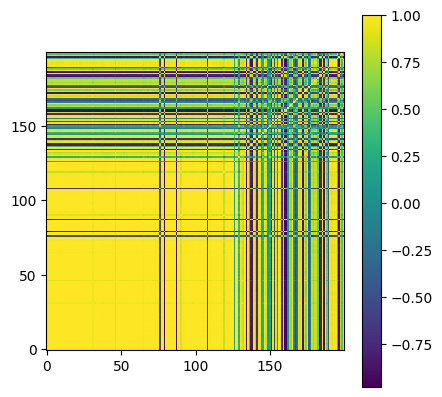

maxNumClusters: 100
clstrs length: 2
best clustr: 2
If 2 or less clusters have a quality rating less than the average then stop.
redoCluster <= 1: [0] clstrs len: 2


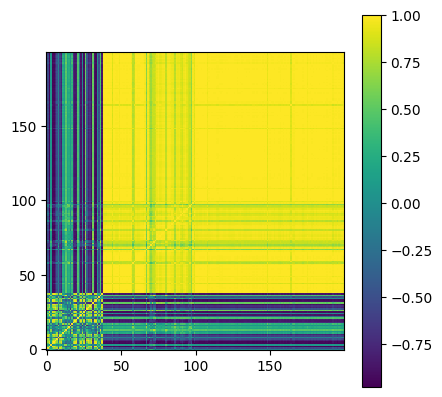

In [48]:
#Draw ground truth
matplotlib.pyplot.matshow(corr) #invert y-axis to get origo at lower left corner
matplotlib.pyplot.gca().xaxis.tick_bottom()
matplotlib.pyplot.gca().invert_yaxis()
matplotlib.pyplot.colorbar()
matplotlib.pyplot.show()

#draw prediction based on ONC
corrNew, clstrsNew, silhNew = clusterKMeansTop(corr)
matplotlib.pyplot.matshow(corrNew)
matplotlib.pyplot.gca().xaxis.tick_bottom()
matplotlib.pyplot.gca().invert_yaxis()
matplotlib.pyplot.colorbar()
matplotlib.pyplot.show()

In [49]:
cluster_lists = []

# Iterate through each cluster and its members
for cluster_number, cluster_indices in clstrsNew.items():
    cluster_list = []

    # Iterate through each index in the cluster
    for idx in cluster_indices:
        trial_number = top_trials[idx].number
        cluster_list.append(trial_number)

    cluster_lists.append(cluster_list)

# Print the lists for each cluster
for i, cluster_list in enumerate(cluster_lists):
    print(f"Cluster {i}: {cluster_list}")

Cluster 0: [6, 202, 192, 168, 51, 128, 18, 38, 183, 132, 179, 201, 194, 29, 120, 145, 197, 176, 36, 138, 66, 61, 62, 134, 135, 156, 105, 11, 106, 8, 118, 124, 167, 81, 175, 181, 119, 73]
Cluster 1: [200, 144, 2, 210, 65, 108, 173, 140, 121, 126, 169, 87, 157, 95, 153, 142, 151, 154, 195, 22, 198, 162, 116, 164, 113, 203, 204, 182, 43, 97, 112, 143, 184, 136, 37, 155, 53, 68, 174, 96, 54, 146, 109, 78, 86, 102, 130, 55, 85, 208, 72, 26, 48, 84, 33, 163, 24, 158, 104, 103, 159, 34, 56, 27, 170, 76, 52, 115, 10, 161, 185, 147, 91, 107, 21, 17, 110, 94, 67, 152, 111, 79, 206, 60, 90, 193, 98, 32, 92, 148, 101, 16, 89, 165, 49, 188, 50, 7, 127, 80, 133, 40, 71, 1, 42, 205, 30, 39, 45, 14, 35, 99, 9, 28, 150, 13, 207, 63, 211, 31, 3, 74, 69, 15, 58, 46, 19, 114, 4, 212, 44, 23, 75, 0, 149, 47, 189, 64, 187, 88, 82, 93, 177, 20, 5, 178, 191, 190, 122, 41, 131, 137, 139, 172, 83, 12, 209, 160, 77, 196, 25, 59]


In [50]:
top_10_features_per_cluster = []

for cluster_number, cluster_indices in clstrsNew.items():
    cluster_frequency = {}

    for idx in cluster_indices:
        trial_params = top_trials[idx].params
        for key, value in trial_params.items():
            if value == 1:
                cluster_frequency[key] = cluster_frequency.get(key, 0) + 1

    sorted_cluster_frequency = sorted(cluster_frequency.items(), key=lambda x: x[1], reverse=True)
    top_10_features_cluster = [feature for feature, _ in sorted_cluster_frequency[:10]]
    top_10_features_per_cluster.append(top_10_features_cluster)
    print(f"Top 10 features for Cluster {cluster_number}: {top_10_features_cluster}")

Top 10 features for Cluster 0: [4, 11, 10, 6, 2, 1, 9, 5, 0, 7]
Top 10 features for Cluster 1: [14, 13, 4, 6, 2, 11, 0, 3, 7, 1]


In [51]:
top_10_features_per_cluster

[[4, 11, 10, 6, 2, 1, 9, 5, 0, 7], [14, 13, 4, 6, 2, 11, 0, 3, 7, 1]]

In [52]:
top10_feat = pd.DataFrame(top_10_features_per_cluster)

In [53]:
selected_columns_cluster = []
for item in top_10_features_per_cluster:
  selected_columns = new_df_no_close_col.iloc[:, item]
  selected_columns_cluster.append(selected_columns)

In [54]:
selected_columns_cluster

[        volatility_bbli  trend_psar_down_indicator  trend_psar_up_indicator  \
 1                   0.0                        0.0                      0.0   
 2                   0.0                        1.0                      0.0   
 3                   0.0                        0.0                      0.0   
 4                   0.0                        0.0                      0.0   
 5                   0.0                        0.0                      0.0   
 ...                 ...                        ...                      ...   
 355991              0.0                        0.0                      0.0   
 355992              0.0                        0.0                      0.0   
 355993              0.0                        0.0                      0.0   
 355994              0.0                        0.0                      0.0   
 355995              0.0                        0.0                      0.0   
 
         volatility_kcp  volume_sma_em

# Model selection

## Custom Early Stopping

In [55]:
from xgboost import callback

In [56]:
min_delta = 0.0001
patience = 30


class CustomEarlyStopping(callback.TrainingCallback):
    def __init__(self, min_delta, patience, verbose=False):
        super().__init__()
        self.min_delta = min_delta
        self.patience = patience
        self.verbose = verbose
        self.best_score = np.inf
        self.wait = 0
        self.stopped_epoch = 0

    def after_iteration(self, model, epoch, evals_log):
        if not evals_log:
            return False
        metric_name = next(iter(evals_log['validation_0']))
        score = evals_log['validation_0'][metric_name][-1]
        if score < (self.best_score - self.min_delta):
            self.best_score = score
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                if self.verbose:
                    print(f"\nStopping. Best score: {self.best_score}")
                self.stopped_epoch = epoch
                return True
        return False

    def get_best_score(self):
        return self.best_score

## Hyperparameter Tuning

In [57]:
def objective_params(trial, X_train, X_valid, y_train, y_valid, y_close):
    # Define the hyperparameter search space
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_split' : trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10)
        }
    trade_threshold  = 0.0005

    # Check duplication and skip if it's detected.
    for t in trial.study.trials:
        if t.state != optuna.trial.TrialState.COMPLETE:
            continue
        if t.params == trial.params:
            return np.nan #t.values  # Return the previous value without re-evaluating i


    custom_early_stopping_instance = CustomEarlyStopping(min_delta=min_delta, patience=patience, verbose=True)

    # Train the model
    model = GradientBoostingRegressor(**params)
    model.fit(X_train, y_train)

    y_pred_train = model.predict(X_train)
    y_pred_valid = model.predict(X_valid)


    pos, pnl, daily_pnl, sharpe_is = sharpe_for_vn30f(y_pred_train, y_close[:len(y_pred_train)], trade_threshold=trade_threshold, fee_perc=0.01, periods=10)
    _, _, _, sharpe_oos = sharpe_for_vn30f(y_pred_valid, y_close[len(y_pred_train):], trade_threshold=trade_threshold, fee_perc=0.01, periods=10)

    return sharpe_oos, abs((abs(sharpe_is / sharpe_oos))-1)

In [58]:
import pickle

In [59]:
best_params_list = []
for idx, data_item in enumerate(selected_columns_cluster):
    train_cols, _ = split_data(data_item)
    optuna_data = scale_data(train_cols)

    X_train, X_valid, y_train, y_valid = train_test_split(optuna_data,
                                                            train_data['Return'],
                                                            test_size=0.5,
                                                            shuffle=False)
    study = optuna.create_study(directions=['maximize', 'minimize'])

    unique_trials = 100
    while unique_trials > len(set(str(t.params) for t in study.trials)):
        study.optimize(lambda trial: objective_params(trial, X_train, X_valid, y_train, y_valid, train_data['Close']), n_trials=1)

    # Retrieve all trials
    trials = study.trials

    completed_trials = [t for t in study.trials if t.values is not None]

    # Sort trials based on objective values
    completed_trials.sort(key=lambda trial: trial.values, reverse=True)

    # Select top 1 trials
    params = completed_trials[0].params
    best_params_list.append(params)

    model = GradientBoostingRegressor(**params)
    model.fit(X_train, y_train)

#     model.save_model(f'best_in_cluster_{idx}.json')
    with open(f'best_in_cluster_{idx}.pkl', 'wb') as f:
        pickle.dump(model, f)

/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
[I 2024-07-01 16:32:46,698] A new study created in memory with name: no-name-6303a6bc-2165-4d27-939f-8781eb34b90e


A new study created in memory with name: no-name-6303a6bc-2165-4d27-939f-8781eb34b90e


[I 2024-07-01 16:34:32,379] Trial 0 finished with values: [0.39324270612329865, 2.596848953592262] and parameters: {'n_estimators': 128, 'learning_rate': 0.03496470490769911, 'max_depth': 7, 'min_samples_split': 9, 'min_samples_leaf': 9}. 


Trial 0 finished with values: [0.39324270612329865, 2.596848953592262] and parameters: {'n_estimators': 128, 'learning_rate': 0.03496470490769911, 'max_depth': 7, 'min_samples_split': 9, 'min_samples_leaf': 9}. 


[I 2024-07-01 16:37:17,678] Trial 1 finished with values: [0.25660352479863596, 5.339730943258025] and parameters: {'n_estimators': 158, 'learning_rate': 0.012208283956934823, 'max_depth': 9, 'min_samples_split': 9, 'min_samples_leaf': 9}. 


Trial 1 finished with values: [0.25660352479863596, 5.339730943258025] and parameters: {'n_estimators': 158, 'learning_rate': 0.012208283956934823, 'max_depth': 9, 'min_samples_split': 9, 'min_samples_leaf': 9}. 


[I 2024-07-01 16:39:06,367] Trial 2 finished with values: [1.1943181769266031, 0.5204416559246303] and parameters: {'n_estimators': 155, 'learning_rate': 0.07274558334023173, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 3}. 


Trial 2 finished with values: [1.1943181769266031, 0.5204416559246303] and parameters: {'n_estimators': 155, 'learning_rate': 0.07274558334023173, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 3}. 


[I 2024-07-01 16:39:27,823] Trial 3 finished with values: [0.7812681820013708, 0.4452032062050588] and parameters: {'n_estimators': 61, 'learning_rate': 0.04605106642870503, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 9}. 


Trial 3 finished with values: [0.7812681820013708, 0.4452032062050588] and parameters: {'n_estimators': 61, 'learning_rate': 0.04605106642870503, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 9}. 


[I 2024-07-01 16:41:03,785] Trial 4 finished with values: [0.012876074088714943, 110.31469359924917] and parameters: {'n_estimators': 164, 'learning_rate': 0.07891571283117634, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 7}. 


Trial 4 finished with values: [0.012876074088714943, 110.31469359924917] and parameters: {'n_estimators': 164, 'learning_rate': 0.07891571283117634, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 7}. 


[I 2024-07-01 16:43:23,309] Trial 5 finished with values: [1.0437453873781706, 2.36208457617946] and parameters: {'n_estimators': 241, 'learning_rate': 0.05978210572013906, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 1}. 


Trial 5 finished with values: [1.0437453873781706, 2.36208457617946] and parameters: {'n_estimators': 241, 'learning_rate': 0.05978210572013906, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 1}. 


[I 2024-07-01 16:46:07,268] Trial 6 finished with values: [0.48923036535652753, 1.7413738001264059] and parameters: {'n_estimators': 282, 'learning_rate': 0.013403045432114923, 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 7}. 


Trial 6 finished with values: [0.48923036535652753, 1.7413738001264059] and parameters: {'n_estimators': 282, 'learning_rate': 0.013403045432114923, 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 7}. 


[I 2024-07-01 16:49:38,415] Trial 7 finished with values: [0.15960501660923712, 8.724184458889123] and parameters: {'n_estimators': 200, 'learning_rate': 0.016756981198327046, 'max_depth': 9, 'min_samples_split': 4, 'min_samples_leaf': 8}. 


Trial 7 finished with values: [0.15960501660923712, 8.724184458889123] and parameters: {'n_estimators': 200, 'learning_rate': 0.016756981198327046, 'max_depth': 9, 'min_samples_split': 4, 'min_samples_leaf': 8}. 


[I 2024-07-01 16:50:53,942] Trial 8 finished with values: [-0.5622786685608522, 4.6014179166777645] and parameters: {'n_estimators': 163, 'learning_rate': 0.08970212556184229, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 1}. 


Trial 8 finished with values: [-0.5622786685608522, 4.6014179166777645] and parameters: {'n_estimators': 163, 'learning_rate': 0.08970212556184229, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 1}. 


[I 2024-07-01 16:51:53,523] Trial 9 finished with values: [0.018122755509876305, 122.80012663002739] and parameters: {'n_estimators': 128, 'learning_rate': 0.062114095208012456, 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 1}. 


Trial 9 finished with values: [0.018122755509876305, 122.80012663002739] and parameters: {'n_estimators': 128, 'learning_rate': 0.062114095208012456, 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 1}. 


[I 2024-07-01 16:52:57,489] Trial 10 finished with values: [-0.3702859195394051, 2.6678263316138344] and parameters: {'n_estimators': 109, 'learning_rate': 0.06253985609647109, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 10}. 


Trial 10 finished with values: [-0.3702859195394051, 2.6678263316138344] and parameters: {'n_estimators': 109, 'learning_rate': 0.06253985609647109, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 10}. 


[I 2024-07-01 16:54:58,313] Trial 11 finished with values: [0.3883611155726211, 2.5899781157253026] and parameters: {'n_estimators': 258, 'learning_rate': 0.07173196389790681, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 7}. 


Trial 11 finished with values: [0.3883611155726211, 2.5899781157253026] and parameters: {'n_estimators': 258, 'learning_rate': 0.07173196389790681, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 7}. 


[I 2024-07-01 16:58:04,080] Trial 12 finished with values: [0.45105082441032446, 5.425049176515441] and parameters: {'n_estimators': 267, 'learning_rate': 0.024688203604256706, 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 1}. 


Trial 12 finished with values: [0.45105082441032446, 5.425049176515441] and parameters: {'n_estimators': 267, 'learning_rate': 0.024688203604256706, 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 1}. 


[I 2024-07-01 16:58:58,527] Trial 13 finished with values: [0.96638982060324, 0.11995120596645426] and parameters: {'n_estimators': 116, 'learning_rate': 0.07093848785841447, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 9}. 


Trial 13 finished with values: [0.96638982060324, 0.11995120596645426] and parameters: {'n_estimators': 116, 'learning_rate': 0.07093848785841447, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 9}. 


[I 2024-07-01 17:00:24,745] Trial 14 finished with values: [0.4622298339694569, 4.880132263025427] and parameters: {'n_estimators': 246, 'learning_rate': 0.09036324347537743, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 1}. 


Trial 14 finished with values: [0.4622298339694569, 4.880132263025427] and parameters: {'n_estimators': 246, 'learning_rate': 0.09036324347537743, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 1}. 


[I 2024-07-01 17:03:22,323] Trial 15 finished with values: [0.9052502867820359, 2.137636161662672] and parameters: {'n_estimators': 216, 'learning_rate': 0.08021288378876498, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 3}. 


Trial 15 finished with values: [0.9052502867820359, 2.137636161662672] and parameters: {'n_estimators': 216, 'learning_rate': 0.08021288378876498, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 3}. 


[I 2024-07-01 17:06:03,159] Trial 16 finished with values: [0.5558558948343375, 7.811985703723499] and parameters: {'n_estimators': 199, 'learning_rate': 0.05653766591079317, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 1}. 


Trial 16 finished with values: [0.5558558948343375, 7.811985703723499] and parameters: {'n_estimators': 199, 'learning_rate': 0.05653766591079317, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 1}. 


[I 2024-07-01 17:08:25,067] Trial 17 finished with values: [-0.16916787794952662, 7.201601267657649] and parameters: {'n_estimators': 241, 'learning_rate': 0.08452603700741693, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 9}. 


Trial 17 finished with values: [-0.16916787794952662, 7.201601267657649] and parameters: {'n_estimators': 241, 'learning_rate': 0.08452603700741693, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 9}. 


[I 2024-07-01 17:11:37,762] Trial 18 finished with values: [0.13820761148220256, 10.344132204125367] and parameters: {'n_estimators': 182, 'learning_rate': 0.017499527427962184, 'max_depth': 9, 'min_samples_split': 4, 'min_samples_leaf': 8}. 


Trial 18 finished with values: [0.13820761148220256, 10.344132204125367] and parameters: {'n_estimators': 182, 'learning_rate': 0.017499527427962184, 'max_depth': 9, 'min_samples_split': 4, 'min_samples_leaf': 8}. 


[I 2024-07-01 17:13:59,961] Trial 19 finished with values: [-0.20725065367653298, 7.867736939216783] and parameters: {'n_estimators': 134, 'learning_rate': 0.05799653611756489, 'max_depth': 9, 'min_samples_split': 9, 'min_samples_leaf': 5}. 


Trial 19 finished with values: [-0.20725065367653298, 7.867736939216783] and parameters: {'n_estimators': 134, 'learning_rate': 0.05799653611756489, 'max_depth': 9, 'min_samples_split': 9, 'min_samples_leaf': 5}. 


[I 2024-07-01 17:16:46,755] Trial 20 finished with values: [0.3655988219972219, 3.330282934734532] and parameters: {'n_estimators': 158, 'learning_rate': 0.014244758271488626, 'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 8}. 


Trial 20 finished with values: [0.3655988219972219, 3.330282934734532] and parameters: {'n_estimators': 158, 'learning_rate': 0.014244758271488626, 'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 8}. 


[I 2024-07-01 17:21:50,953] Trial 21 finished with values: [-1.4477067421167777, 1.0805940907364793] and parameters: {'n_estimators': 257, 'learning_rate': 0.011914072693541526, 'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 1}. 


Trial 21 finished with values: [-1.4477067421167777, 1.0805940907364793] and parameters: {'n_estimators': 257, 'learning_rate': 0.011914072693541526, 'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 1}. 


[I 2024-07-01 17:26:36,668] Trial 22 finished with values: [-0.19739268778031868, 20.28449138891027] and parameters: {'n_estimators': 268, 'learning_rate': 0.07892755160654004, 'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 3}. 


Trial 22 finished with values: [-0.19739268778031868, 20.28449138891027] and parameters: {'n_estimators': 268, 'learning_rate': 0.07892755160654004, 'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 3}. 


[I 2024-07-01 17:29:43,246] Trial 23 finished with values: [0.38207002450151845, 2.916030194198333] and parameters: {'n_estimators': 259, 'learning_rate': 0.047484387097059606, 'max_depth': 6, 'min_samples_split': 7, 'min_samples_leaf': 7}. 


Trial 23 finished with values: [0.38207002450151845, 2.916030194198333] and parameters: {'n_estimators': 259, 'learning_rate': 0.047484387097059606, 'max_depth': 6, 'min_samples_split': 7, 'min_samples_leaf': 7}. 


[I 2024-07-01 17:30:14,851] Trial 24 finished with values: [0.2939598413586262, 2.178052584030213] and parameters: {'n_estimators': 67, 'learning_rate': 0.044790841150301054, 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 7}. 


Trial 24 finished with values: [0.2939598413586262, 2.178052584030213] and parameters: {'n_estimators': 67, 'learning_rate': 0.044790841150301054, 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 7}. 


[I 2024-07-01 17:32:46,921] Trial 25 finished with values: [0.5332612280355215, 1.8047334385918687] and parameters: {'n_estimators': 185, 'learning_rate': 0.08771221834512935, 'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 7}. 


Trial 25 finished with values: [0.5332612280355215, 1.8047334385918687] and parameters: {'n_estimators': 185, 'learning_rate': 0.08771221834512935, 'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 7}. 


[I 2024-07-01 17:34:34,469] Trial 26 finished with values: [0.5594033612270732, 2.5404084852491855] and parameters: {'n_estimators': 115, 'learning_rate': 0.07069324290140072, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 4}. 


Trial 26 finished with values: [0.5594033612270732, 2.5404084852491855] and parameters: {'n_estimators': 115, 'learning_rate': 0.07069324290140072, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 4}. 


[I 2024-07-01 17:35:29,581] Trial 27 finished with values: [0.3570251955959908, 3.035053767742074] and parameters: {'n_estimators': 78, 'learning_rate': 0.08260797614122564, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 9}. 


Trial 27 finished with values: [0.3570251955959908, 3.035053767742074] and parameters: {'n_estimators': 78, 'learning_rate': 0.08260797614122564, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 9}. 


[I 2024-07-01 17:38:05,309] Trial 28 finished with values: [1.3173367253109363, 0.9955463448035551] and parameters: {'n_estimators': 220, 'learning_rate': 0.09309706870128952, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 4}. 


Trial 28 finished with values: [1.3173367253109363, 0.9955463448035551] and parameters: {'n_estimators': 220, 'learning_rate': 0.09309706870128952, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 4}. 


[I 2024-07-01 17:41:31,573] Trial 29 finished with values: [0.9482596407526053, 0.987272524122963] and parameters: {'n_estimators': 293, 'learning_rate': 0.07459756900163494, 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 5}. 


Trial 29 finished with values: [0.9482596407526053, 0.987272524122963] and parameters: {'n_estimators': 293, 'learning_rate': 0.07459756900163494, 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 5}. 


[I 2024-07-01 17:42:54,856] Trial 30 finished with values: [-0.10351610377012295, 33.84518823659639] and parameters: {'n_estimators': 181, 'learning_rate': 0.09443315599301981, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 1}. 


Trial 30 finished with values: [-0.10351610377012295, 33.84518823659639] and parameters: {'n_estimators': 181, 'learning_rate': 0.09443315599301981, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 1}. 


[I 2024-07-01 17:43:51,822] Trial 31 finished with values: [0.3317935844183311, 2.8533416067327866] and parameters: {'n_estimators': 97, 'learning_rate': 0.014244669831322974, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 7}. 


Trial 31 finished with values: [0.3317935844183311, 2.8533416067327866] and parameters: {'n_estimators': 97, 'learning_rate': 0.014244669831322974, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 7}. 


[I 2024-07-01 17:47:52,683] Trial 32 finished with values: [1.2120101702847081, 1.7152659316202148] and parameters: {'n_estimators': 297, 'learning_rate': 0.095246142671286, 'max_depth': 7, 'min_samples_split': 9, 'min_samples_leaf': 4}. 


Trial 32 finished with values: [1.2120101702847081, 1.7152659316202148] and parameters: {'n_estimators': 297, 'learning_rate': 0.095246142671286, 'max_depth': 7, 'min_samples_split': 9, 'min_samples_leaf': 4}. 


[I 2024-07-01 17:49:00,526] Trial 33 finished with values: [0.47397943686315436, 1.8690138174479087] and parameters: {'n_estimators': 116, 'learning_rate': 0.05827735987964395, 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 8}. 


Trial 33 finished with values: [0.47397943686315436, 1.8690138174479087] and parameters: {'n_estimators': 116, 'learning_rate': 0.05827735987964395, 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 8}. 


[I 2024-07-01 17:50:37,129] Trial 34 finished with values: [-1.5998941039927737, 0.10213488232482548] and parameters: {'n_estimators': 207, 'learning_rate': 0.0633804739089168, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 5}. 


Trial 34 finished with values: [-1.5998941039927737, 0.10213488232482548] and parameters: {'n_estimators': 207, 'learning_rate': 0.0633804739089168, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 5}. 


[I 2024-07-01 17:51:45,613] Trial 35 finished with values: [0.3882610479397277, 1.7887020022584315] and parameters: {'n_estimators': 146, 'learning_rate': 0.015001550339892578, 'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 2}. 


Trial 35 finished with values: [0.3882610479397277, 1.7887020022584315] and parameters: {'n_estimators': 146, 'learning_rate': 0.015001550339892578, 'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 2}. 


[I 2024-07-01 17:53:09,393] Trial 36 finished with values: [1.1179739586764936, 0.2174176137147652] and parameters: {'n_estimators': 141, 'learning_rate': 0.03921180149486321, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 6}. 


Trial 36 finished with values: [1.1179739586764936, 0.2174176137147652] and parameters: {'n_estimators': 141, 'learning_rate': 0.03921180149486321, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 6}. 


[I 2024-07-01 17:55:39,579] Trial 37 finished with values: [0.1502379721456007, 11.1067604959181] and parameters: {'n_estimators': 256, 'learning_rate': 0.016765014342592657, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 1}. 


Trial 37 finished with values: [0.1502379721456007, 11.1067604959181] and parameters: {'n_estimators': 256, 'learning_rate': 0.016765014342592657, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 1}. 


[I 2024-07-01 17:57:37,051] Trial 38 finished with values: [0.35657284066433553, 3.0139578530511404] and parameters: {'n_estimators': 166, 'learning_rate': 0.04315042885945458, 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 9}. 


Trial 38 finished with values: [0.35657284066433553, 3.0139578530511404] and parameters: {'n_estimators': 166, 'learning_rate': 0.04315042885945458, 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 9}. 


[I 2024-07-01 17:59:38,638] Trial 39 finished with values: [-0.12680324011002006, 27.121871160720836] and parameters: {'n_estimators': 210, 'learning_rate': 0.07344132578379947, 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 1}. 


Trial 39 finished with values: [-0.12680324011002006, 27.121871160720836] and parameters: {'n_estimators': 210, 'learning_rate': 0.07344132578379947, 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 1}. 


[I 2024-07-01 18:04:13,258] Trial 40 finished with values: [-0.14600814589673905, 22.189521425310737] and parameters: {'n_estimators': 234, 'learning_rate': 0.04990356136418594, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 3}. 


Trial 40 finished with values: [-0.14600814589673905, 22.189521425310737] and parameters: {'n_estimators': 234, 'learning_rate': 0.04990356136418594, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 3}. 


[I 2024-07-01 18:05:59,822] Trial 41 finished with values: [0.02592352878984351, 54.61717783889357] and parameters: {'n_estimators': 151, 'learning_rate': 0.06397398842897493, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 8}. 


Trial 41 finished with values: [0.02592352878984351, 54.61717783889357] and parameters: {'n_estimators': 151, 'learning_rate': 0.06397398842897493, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 8}. 


[I 2024-07-01 18:09:45,026] Trial 42 finished with values: [0.661467216001866, 1.274388110229288] and parameters: {'n_estimators': 215, 'learning_rate': 0.02869246478064081, 'max_depth': 9, 'min_samples_split': 10, 'min_samples_leaf': 9}. 


Trial 42 finished with values: [0.661467216001866, 1.274388110229288] and parameters: {'n_estimators': 215, 'learning_rate': 0.02869246478064081, 'max_depth': 9, 'min_samples_split': 10, 'min_samples_leaf': 9}. 


[I 2024-07-01 18:12:13,542] Trial 43 finished with values: [1.455791717359032, 0.4545332970801459] and parameters: {'n_estimators': 212, 'learning_rate': 0.06795605942667865, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 3}. 


Trial 43 finished with values: [1.455791717359032, 0.4545332970801459] and parameters: {'n_estimators': 212, 'learning_rate': 0.06795605942667865, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 3}. 


[I 2024-07-01 18:15:48,280] Trial 44 finished with values: [0.16915699936192105, 8.174618084368177] and parameters: {'n_estimators': 260, 'learning_rate': 0.01982935009811923, 'max_depth': 7, 'min_samples_split': 6, 'min_samples_leaf': 5}. 


Trial 44 finished with values: [0.16915699936192105, 8.174618084368177] and parameters: {'n_estimators': 260, 'learning_rate': 0.01982935009811923, 'max_depth': 7, 'min_samples_split': 6, 'min_samples_leaf': 5}. 


[I 2024-07-01 18:16:51,068] Trial 45 finished with values: [0.8981970501396287, 0.27285106598831343] and parameters: {'n_estimators': 177, 'learning_rate': 0.04440065914692332, 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 9}. 


Trial 45 finished with values: [0.8981970501396287, 0.27285106598831343] and parameters: {'n_estimators': 177, 'learning_rate': 0.04440065914692332, 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 9}. 


[I 2024-07-01 18:18:09,180] Trial 46 finished with values: [0.5210362588821277, 3.785169401626627] and parameters: {'n_estimators': 221, 'learning_rate': 0.07831585097522824, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 1}. 


Trial 46 finished with values: [0.5210362588821277, 3.785169401626627] and parameters: {'n_estimators': 221, 'learning_rate': 0.07831585097522824, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 1}. 


[I 2024-07-01 18:20:04,221] Trial 47 finished with values: [1.1802364979665787, 0.15021380387829653] and parameters: {'n_estimators': 195, 'learning_rate': 0.029786247965036095, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 6}. 


Trial 47 finished with values: [1.1802364979665787, 0.15021380387829653] and parameters: {'n_estimators': 195, 'learning_rate': 0.029786247965036095, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 6}. 


[I 2024-07-01 18:21:29,484] Trial 48 finished with values: [0.06033067349543398, 14.306805759249627] and parameters: {'n_estimators': 241, 'learning_rate': 0.08643252359527055, 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 10}. 


Trial 48 finished with values: [0.06033067349543398, 14.306805759249627] and parameters: {'n_estimators': 241, 'learning_rate': 0.08643252359527055, 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 10}. 


[I 2024-07-01 18:24:36,133] Trial 49 finished with values: [0.6898178278240502, 6.938411746372767] and parameters: {'n_estimators': 228, 'learning_rate': 0.08052504383072238, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 1}. 


Trial 49 finished with values: [0.6898178278240502, 6.938411746372767] and parameters: {'n_estimators': 228, 'learning_rate': 0.08052504383072238, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 1}. 


[I 2024-07-01 18:25:59,018] Trial 50 finished with values: [0.40644069087782847, 2.092489631077958] and parameters: {'n_estimators': 141, 'learning_rate': 0.013403045432114923, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 7}. 


Trial 50 finished with values: [0.40644069087782847, 2.092489631077958] and parameters: {'n_estimators': 141, 'learning_rate': 0.013403045432114923, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 7}. 


[I 2024-07-01 18:29:10,901] Trial 51 finished with values: [-0.2122181479367037, 6.623980079962638] and parameters: {'n_estimators': 182, 'learning_rate': 0.04440065914692332, 'max_depth': 9, 'min_samples_split': 9, 'min_samples_leaf': 8}. 


Trial 51 finished with values: [-0.2122181479367037, 6.623980079962638] and parameters: {'n_estimators': 182, 'learning_rate': 0.04440065914692332, 'max_depth': 9, 'min_samples_split': 9, 'min_samples_leaf': 8}. 


[I 2024-07-01 18:31:59,781] Trial 52 finished with values: [1.1060559862090942, 1.080949877424414] and parameters: {'n_estimators': 241, 'learning_rate': 0.05978210572013906, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 3}. 


Trial 52 finished with values: [1.1060559862090942, 1.080949877424414] and parameters: {'n_estimators': 241, 'learning_rate': 0.05978210572013906, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 3}. 


[I 2024-07-01 18:35:14,065] Trial 53 finished with values: [-0.665395147101952, 1.2844105368482284] and parameters: {'n_estimators': 237, 'learning_rate': 0.08771221834512935, 'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 7}. 


Trial 53 finished with values: [-0.665395147101952, 1.2844105368482284] and parameters: {'n_estimators': 237, 'learning_rate': 0.08771221834512935, 'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 7}. 


[I 2024-07-01 18:36:27,360] Trial 54 finished with values: [-0.30715642560292, 3.2134221699959786] and parameters: {'n_estimators': 90, 'learning_rate': 0.095246142671286, 'max_depth': 7, 'min_samples_split': 9, 'min_samples_leaf': 10}. 


Trial 54 finished with values: [-0.30715642560292, 3.2134221699959786] and parameters: {'n_estimators': 90, 'learning_rate': 0.095246142671286, 'max_depth': 7, 'min_samples_split': 9, 'min_samples_leaf': 10}. 


[I 2024-07-01 18:38:04,893] Trial 55 finished with values: [0.041883080839288774, 21.396981310022056] and parameters: {'n_estimators': 207, 'learning_rate': 0.0633804739089168, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 10}. 


Trial 55 finished with values: [0.041883080839288774, 21.396981310022056] and parameters: {'n_estimators': 207, 'learning_rate': 0.0633804739089168, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 10}. 


[I 2024-07-01 18:41:11,919] Trial 56 finished with values: [0.6001231497192058, 1.5490039431782745] and parameters: {'n_estimators': 228, 'learning_rate': 0.030270718193462942, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 4}. 


Trial 56 finished with values: [0.6001231497192058, 1.5490039431782745] and parameters: {'n_estimators': 228, 'learning_rate': 0.030270718193462942, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 4}. 


[I 2024-07-01 18:42:27,263] Trial 57 finished with values: [0.7574381536257747, 0.24797091295421758] and parameters: {'n_estimators': 163, 'learning_rate': 0.016756981198327046, 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 8}. 


Trial 57 finished with values: [0.7574381536257747, 0.24797091295421758] and parameters: {'n_estimators': 163, 'learning_rate': 0.016756981198327046, 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 8}. 


[I 2024-07-01 18:46:29,302] Trial 58 finished with values: [-0.14465663297710146, 7.137178525437614] and parameters: {'n_estimators': 297, 'learning_rate': 0.08087590477432618, 'max_depth': 7, 'min_samples_split': 9, 'min_samples_leaf': 10}. 


Trial 58 finished with values: [-0.14465663297710146, 7.137178525437614] and parameters: {'n_estimators': 297, 'learning_rate': 0.08087590477432618, 'max_depth': 7, 'min_samples_split': 9, 'min_samples_leaf': 10}. 


[I 2024-07-01 18:48:51,380] Trial 59 finished with values: [0.5487752036273242, 1.8100289881200191] and parameters: {'n_estimators': 201, 'learning_rate': 0.03970731877338592, 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 4}. 


Trial 59 finished with values: [0.5487752036273242, 1.8100289881200191] and parameters: {'n_estimators': 201, 'learning_rate': 0.03970731877338592, 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 4}. 


[I 2024-07-01 18:50:03,522] Trial 60 finished with values: [0.8926295278875804, 3.4230412385442115] and parameters: {'n_estimators': 90, 'learning_rate': 0.07180495977047106, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 1}. 


Trial 60 finished with values: [0.8926295278875804, 3.4230412385442115] and parameters: {'n_estimators': 90, 'learning_rate': 0.07180495977047106, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 1}. 


[I 2024-07-01 18:52:05,542] Trial 61 finished with values: [0.2407782404057661, 5.512218405615167] and parameters: {'n_estimators': 116, 'learning_rate': 0.02869246478064081, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 8}. 


Trial 61 finished with values: [0.2407782404057661, 5.512218405615167] and parameters: {'n_estimators': 116, 'learning_rate': 0.02869246478064081, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 8}. 


[W 2024-07-01 18:52:05,561] Trial 62 failed with parameters: {'n_estimators': 185, 'learning_rate': 0.08771221834512935, 'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 7} because of the following error: The value nan is not acceptable.


Trial 62 failed with parameters: {'n_estimators': 185, 'learning_rate': 0.08771221834512935, 'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 7} because of the following error: The value nan is not acceptable.


[W 2024-07-01 18:52:05,563] Trial 62 failed with value nan.


Trial 62 failed with value nan.


[I 2024-07-01 18:53:14,941] Trial 63 finished with values: [1.033912246063633, 0.06126484333908433] and parameters: {'n_estimators': 147, 'learning_rate': 0.03496470490769911, 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 9}. 


Trial 63 finished with values: [1.033912246063633, 0.06126484333908433] and parameters: {'n_estimators': 147, 'learning_rate': 0.03496470490769911, 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 9}. 


[I 2024-07-01 18:54:37,311] Trial 64 finished with values: [1.5674595441060375, 0.06539762442995567] and parameters: {'n_estimators': 116, 'learning_rate': 0.09309706870128952, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 4}. 


Trial 64 finished with values: [1.5674595441060375, 0.06539762442995567] and parameters: {'n_estimators': 116, 'learning_rate': 0.09309706870128952, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 4}. 


[I 2024-07-01 18:55:35,185] Trial 65 finished with values: [0.3317935844183311, 2.8533416067327866] and parameters: {'n_estimators': 97, 'learning_rate': 0.014244669831322974, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 7}. 


Trial 65 finished with values: [0.3317935844183311, 2.8533416067327866] and parameters: {'n_estimators': 97, 'learning_rate': 0.014244669831322974, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 7}. 


[I 2024-07-01 18:57:02,999] Trial 66 finished with values: [-0.7179661301574944, 1.1111447903958096] and parameters: {'n_estimators': 246, 'learning_rate': 0.06795605942667865, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 3}. 


Trial 66 finished with values: [-0.7179661301574944, 1.1111447903958096] and parameters: {'n_estimators': 246, 'learning_rate': 0.06795605942667865, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 3}. 


[I 2024-07-01 18:59:50,981] Trial 67 finished with values: [0.7876372312292854, 1.2968579339388207] and parameters: {'n_estimators': 158, 'learning_rate': 0.014244758271488626, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 3}. 


Trial 67 finished with values: [0.7876372312292854, 1.2968579339388207] and parameters: {'n_estimators': 158, 'learning_rate': 0.014244758271488626, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 3}. 


[I 2024-07-01 19:03:37,935] Trial 68 finished with values: [-0.37266497617695177, 13.957833190299988] and parameters: {'n_estimators': 219, 'learning_rate': 0.05653766591079317, 'max_depth': 9, 'min_samples_split': 9, 'min_samples_leaf': 1}. 


Trial 68 finished with values: [-0.37266497617695177, 13.957833190299988] and parameters: {'n_estimators': 219, 'learning_rate': 0.05653766591079317, 'max_depth': 9, 'min_samples_split': 9, 'min_samples_leaf': 1}. 


[W 2024-07-01 19:03:37,955] Trial 69 failed with parameters: {'n_estimators': 61, 'learning_rate': 0.04605106642870503, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 9} because of the following error: The value nan is not acceptable.


Trial 69 failed with parameters: {'n_estimators': 61, 'learning_rate': 0.04605106642870503, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 9} because of the following error: The value nan is not acceptable.


[W 2024-07-01 19:03:37,957] Trial 69 failed with value nan.


Trial 69 failed with value nan.


[I 2024-07-01 19:06:21,751] Trial 70 finished with values: [1.127136744460595, 2.992100839824977] and parameters: {'n_estimators': 199, 'learning_rate': 0.05653766591079317, 'max_depth': 7, 'min_samples_split': 9, 'min_samples_leaf': 1}. 


Trial 70 finished with values: [1.127136744460595, 2.992100839824977] and parameters: {'n_estimators': 199, 'learning_rate': 0.05653766591079317, 'max_depth': 7, 'min_samples_split': 9, 'min_samples_leaf': 1}. 


[I 2024-07-01 19:07:30,379] Trial 71 finished with values: [1.0859928600854207, 0.45787145896406933] and parameters: {'n_estimators': 116, 'learning_rate': 0.06795605942667865, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 3}. 


Trial 71 finished with values: [1.0859928600854207, 0.45787145896406933] and parameters: {'n_estimators': 116, 'learning_rate': 0.06795605942667865, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 3}. 


[I 2024-07-01 19:08:46,984] Trial 72 finished with values: [0.7370856816882532, 0.5220971519187592] and parameters: {'n_estimators': 216, 'learning_rate': 0.013101253187756942, 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 1}. 


Trial 72 finished with values: [0.7370856816882532, 0.5220971519187592] and parameters: {'n_estimators': 216, 'learning_rate': 0.013101253187756942, 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 1}. 


[I 2024-07-01 19:09:51,540] Trial 73 finished with values: [0.8452829490568181, 0.5922939706725301] and parameters: {'n_estimators': 109, 'learning_rate': 0.03921180149486321, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 6}. 


Trial 73 finished with values: [0.8452829490568181, 0.5922939706725301] and parameters: {'n_estimators': 109, 'learning_rate': 0.03921180149486321, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 6}. 


[I 2024-07-01 19:11:31,765] Trial 74 finished with values: [0.9407206062486618, 0.1214949616159049] and parameters: {'n_estimators': 282, 'learning_rate': 0.07445056648525852, 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 7}. 


Trial 74 finished with values: [0.9407206062486618, 0.1214949616159049] and parameters: {'n_estimators': 282, 'learning_rate': 0.07445056648525852, 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 7}. 


[W 2024-07-01 19:11:31,787] Trial 75 failed with parameters: {'n_estimators': 241, 'learning_rate': 0.05978210572013906, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 1} because of the following error: The value nan is not acceptable.


Trial 75 failed with parameters: {'n_estimators': 241, 'learning_rate': 0.05978210572013906, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 1} because of the following error: The value nan is not acceptable.


[W 2024-07-01 19:11:31,789] Trial 75 failed with value nan.


Trial 75 failed with value nan.


[I 2024-07-01 19:13:27,300] Trial 76 finished with values: [0.7684726361956331, 0.7416035131938843] and parameters: {'n_estimators': 195, 'learning_rate': 0.029786247965036095, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 4}. 


Trial 76 finished with values: [0.7684726361956331, 0.7416035131938843] and parameters: {'n_estimators': 195, 'learning_rate': 0.029786247965036095, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 4}. 


[I 2024-07-01 19:15:58,476] Trial 77 finished with values: [1.3042876731821471, 0.17952640041614187] and parameters: {'n_estimators': 256, 'learning_rate': 0.02363779609284249, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 2}. 


Trial 77 finished with values: [1.3042876731821471, 0.17952640041614187] and parameters: {'n_estimators': 256, 'learning_rate': 0.02363779609284249, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 2}. 


[I 2024-07-01 19:17:53,103] Trial 78 finished with values: [-0.7821052341785676, 0.9860829710720451] and parameters: {'n_estimators': 241, 'learning_rate': 0.08452603700741693, 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 7}. 


Trial 78 finished with values: [-0.7821052341785676, 0.9860829710720451] and parameters: {'n_estimators': 241, 'learning_rate': 0.08452603700741693, 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 7}. 


[I 2024-07-01 19:19:48,663] Trial 79 finished with values: [0.7225616647601377, 0.855655811752629] and parameters: {'n_estimators': 195, 'learning_rate': 0.029786247965036095, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 5}. 


Trial 79 finished with values: [0.7225616647601377, 0.855655811752629] and parameters: {'n_estimators': 195, 'learning_rate': 0.029786247965036095, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 5}. 


[I 2024-07-01 19:22:22,090] Trial 80 finished with values: [0.5293242628817724, 1.6069694545047777] and parameters: {'n_estimators': 185, 'learning_rate': 0.08452603700741693, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 9}. 


Trial 80 finished with values: [0.5293242628817724, 1.6069694545047777] and parameters: {'n_estimators': 185, 'learning_rate': 0.08452603700741693, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 9}. 


[I 2024-07-01 19:25:30,759] Trial 81 finished with values: [0.33160998752344223, 8.915491497393452] and parameters: {'n_estimators': 267, 'learning_rate': 0.024688203604256706, 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 1}. 


Trial 81 finished with values: [0.33160998752344223, 8.915491497393452] and parameters: {'n_estimators': 267, 'learning_rate': 0.024688203604256706, 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 1}. 


[I 2024-07-01 19:27:32,914] Trial 82 finished with values: [1.3923995246167427, 0.3338900922854746] and parameters: {'n_estimators': 257, 'learning_rate': 0.09443315599301981, 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 3}. 


Trial 82 finished with values: [1.3923995246167427, 0.3338900922854746] and parameters: {'n_estimators': 257, 'learning_rate': 0.09443315599301981, 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 3}. 


[I 2024-07-01 19:32:42,846] Trial 83 finished with values: [0.21507239119150673, 6.216937695290148] and parameters: {'n_estimators': 291, 'learning_rate': 0.014244758271488626, 'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 8}. 


Trial 83 finished with values: [0.21507239119150673, 6.216937695290148] and parameters: {'n_estimators': 291, 'learning_rate': 0.014244758271488626, 'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 8}. 


[I 2024-07-01 19:33:28,614] Trial 84 finished with values: [0.8034746531574619, 0.6038713437159748] and parameters: {'n_estimators': 77, 'learning_rate': 0.05827735987964395, 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 4}. 


Trial 84 finished with values: [0.8034746531574619, 0.6038713437159748] and parameters: {'n_estimators': 77, 'learning_rate': 0.05827735987964395, 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 4}. 


[I 2024-07-01 19:34:37,634] Trial 85 finished with values: [0.5509610180716654, 1.987110284535495] and parameters: {'n_estimators': 83, 'learning_rate': 0.08021288378876498, 'max_depth': 7, 'min_samples_split': 9, 'min_samples_leaf': 4}. 


Trial 85 finished with values: [0.5509610180716654, 1.987110284535495] and parameters: {'n_estimators': 83, 'learning_rate': 0.08021288378876498, 'max_depth': 7, 'min_samples_split': 9, 'min_samples_leaf': 4}. 


[I 2024-07-01 19:36:27,194] Trial 86 finished with values: [0.34319041659906224, 3.2438625833775356] and parameters: {'n_estimators': 132, 'learning_rate': 0.013403045432114923, 'max_depth': 7, 'min_samples_split': 8, 'min_samples_leaf': 7}. 


Trial 86 finished with values: [0.34319041659906224, 3.2438625833775356] and parameters: {'n_estimators': 132, 'learning_rate': 0.013403045432114923, 'max_depth': 7, 'min_samples_split': 8, 'min_samples_leaf': 7}. 


[I 2024-07-01 19:38:29,616] Trial 87 finished with values: [0.007183164196003565, 214.88768433482085] and parameters: {'n_estimators': 115, 'learning_rate': 0.08771221834512935, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 7}. 


Trial 87 finished with values: [0.007183164196003565, 214.88768433482085] and parameters: {'n_estimators': 115, 'learning_rate': 0.08771221834512935, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 7}. 


[I 2024-07-01 19:40:07,867] Trial 88 finished with values: [0.932804267776397, 0.5036692063534103] and parameters: {'n_estimators': 207, 'learning_rate': 0.0633804739089168, 'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 4}. 


Trial 88 finished with values: [0.932804267776397, 0.5036692063534103] and parameters: {'n_estimators': 207, 'learning_rate': 0.0633804739089168, 'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 4}. 


[I 2024-07-01 19:41:46,123] Trial 89 finished with values: [-0.35856518322786807, 3.2201961405677615] and parameters: {'n_estimators': 207, 'learning_rate': 0.08660130619604815, 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 5}. 


Trial 89 finished with values: [-0.35856518322786807, 3.2201961405677615] and parameters: {'n_estimators': 207, 'learning_rate': 0.08660130619604815, 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 5}. 


[I 2024-07-01 19:43:13,962] Trial 90 finished with values: [0.2994740608155453, 2.1863031528649692] and parameters: {'n_estimators': 185, 'learning_rate': 0.015001550339892578, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 7}. 


Trial 90 finished with values: [0.2994740608155453, 2.1863031528649692] and parameters: {'n_estimators': 185, 'learning_rate': 0.015001550339892578, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 7}. 


[W 2024-07-01 19:43:14,001] Trial 91 failed with parameters: {'n_estimators': 177, 'learning_rate': 0.04440065914692332, 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 9} because of the following error: The value nan is not acceptable.


Trial 91 failed with parameters: {'n_estimators': 177, 'learning_rate': 0.04440065914692332, 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 9} because of the following error: The value nan is not acceptable.


[W 2024-07-01 19:43:14,003] Trial 91 failed with value nan.


Trial 91 failed with value nan.


[I 2024-07-01 19:44:18,174] Trial 92 finished with values: [-0.12837654495894096, 26.49802140111399] and parameters: {'n_estimators': 78, 'learning_rate': 0.08260797614122564, 'max_depth': 7, 'min_samples_split': 8, 'min_samples_leaf': 1}. 


Trial 92 finished with values: [-0.12837654495894096, 26.49802140111399] and parameters: {'n_estimators': 78, 'learning_rate': 0.08260797614122564, 'max_depth': 7, 'min_samples_split': 8, 'min_samples_leaf': 1}. 


[I 2024-07-01 19:44:52,130] Trial 93 finished with values: [1.020384344198374, 0.054481924599016684] and parameters: {'n_estimators': 95, 'learning_rate': 0.04605106642870503, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 9}. 


Trial 93 finished with values: [1.020384344198374, 0.054481924599016684] and parameters: {'n_estimators': 95, 'learning_rate': 0.04605106642870503, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 9}. 


[I 2024-07-01 19:48:13,845] Trial 94 finished with values: [0.9450432274502335, 3.397857631829412] and parameters: {'n_estimators': 246, 'learning_rate': 0.03496470490769911, 'max_depth': 7, 'min_samples_split': 6, 'min_samples_leaf': 1}. 


Trial 94 finished with values: [0.9450432274502335, 3.397857631829412] and parameters: {'n_estimators': 246, 'learning_rate': 0.03496470490769911, 'max_depth': 7, 'min_samples_split': 6, 'min_samples_leaf': 1}. 


[I 2024-07-01 19:52:08,523] Trial 95 finished with values: [-0.11443945840933083, 12.664309231094721] and parameters: {'n_estimators': 215, 'learning_rate': 0.02869246478064081, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 8}. 


Trial 95 finished with values: [-0.11443945840933083, 12.664309231094721] and parameters: {'n_estimators': 215, 'learning_rate': 0.02869246478064081, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 8}. 


[W 2024-07-01 19:52:08,551] Trial 96 failed with parameters: {'n_estimators': 257, 'learning_rate': 0.011914072693541526, 'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 1} because of the following error: The value nan is not acceptable.


Trial 96 failed with parameters: {'n_estimators': 257, 'learning_rate': 0.011914072693541526, 'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 1} because of the following error: The value nan is not acceptable.


[W 2024-07-01 19:52:08,553] Trial 96 failed with value nan.


Trial 96 failed with value nan.


[I 2024-07-01 19:53:37,048] Trial 97 finished with values: [0.8950369453594812, 0.5600093525404122] and parameters: {'n_estimators': 150, 'learning_rate': 0.09036324347537743, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 7}. 


Trial 97 finished with values: [0.8950369453594812, 0.5600093525404122] and parameters: {'n_estimators': 150, 'learning_rate': 0.09036324347537743, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 7}. 


[I 2024-07-01 19:57:42,835] Trial 98 finished with values: [0.35803211663707507, 2.887301627906907] and parameters: {'n_estimators': 297, 'learning_rate': 0.02869246478064081, 'max_depth': 7, 'min_samples_split': 9, 'min_samples_leaf': 9}. 


Trial 98 finished with values: [0.35803211663707507, 2.887301627906907] and parameters: {'n_estimators': 297, 'learning_rate': 0.02869246478064081, 'max_depth': 7, 'min_samples_split': 9, 'min_samples_leaf': 9}. 


[I 2024-07-01 19:59:50,805] Trial 99 finished with values: [-1.2504303657726723, 0.23844040340322614] and parameters: {'n_estimators': 271, 'learning_rate': 0.07173196389790681, 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 7}. 


Trial 99 finished with values: [-1.2504303657726723, 0.23844040340322614] and parameters: {'n_estimators': 271, 'learning_rate': 0.07173196389790681, 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 7}. 


[I 2024-07-01 20:01:19,879] Trial 100 finished with values: [0.49680932093401814, 2.257899510832057] and parameters: {'n_estimators': 108, 'learning_rate': 0.06782331148745342, 'max_depth': 7, 'min_samples_split': 6, 'min_samples_leaf': 5}. 


Trial 100 finished with values: [0.49680932093401814, 2.257899510832057] and parameters: {'n_estimators': 108, 'learning_rate': 0.06782331148745342, 'max_depth': 7, 'min_samples_split': 6, 'min_samples_leaf': 5}. 


[I 2024-07-01 20:03:52,972] Trial 101 finished with values: [0.3907404941327565, 2.9506173992766738] and parameters: {'n_estimators': 145, 'learning_rate': 0.02869246478064081, 'max_depth': 9, 'min_samples_split': 10, 'min_samples_leaf': 9}. 


Trial 101 finished with values: [0.3907404941327565, 2.9506173992766738] and parameters: {'n_estimators': 145, 'learning_rate': 0.02869246478064081, 'max_depth': 9, 'min_samples_split': 10, 'min_samples_leaf': 9}. 


[I 2024-07-01 20:07:12,040] Trial 102 finished with values: [0.6793920595653584, 3.559898580589789] and parameters: {'n_estimators': 285, 'learning_rate': 0.024688203604256706, 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 1}. 


Trial 102 finished with values: [0.6793920595653584, 3.559898580589789] and parameters: {'n_estimators': 285, 'learning_rate': 0.024688203604256706, 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 1}. 


[I 2024-07-01 20:08:16,239] Trial 103 finished with values: [-0.3702859195394051, 2.6325244882191594] and parameters: {'n_estimators': 109, 'learning_rate': 0.07459756900163494, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 10}. 


Trial 103 finished with values: [-0.3702859195394051, 2.6325244882191594] and parameters: {'n_estimators': 109, 'learning_rate': 0.07459756900163494, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 10}. 


[I 2024-07-01 20:09:07,560] Trial 104 finished with values: [0.03804380579020365, 23.28566579113869] and parameters: {'n_estimators': 109, 'learning_rate': 0.06253985609647109, 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 10}. 


Trial 104 finished with values: [0.03804380579020365, 23.28566579113869] and parameters: {'n_estimators': 109, 'learning_rate': 0.06253985609647109, 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 10}. 


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
[I 2024-07-01 20:10:29,463] A new study created in memory with name: no-name-6bd671b8-baef-40fe-99d5-68e07613d3a8


A new study created in memory with name: no-name-6bd671b8-baef-40fe-99d5-68e07613d3a8


[I 2024-07-01 20:12:43,849] Trial 0 finished with values: [1.427435045537293, 1.825397578009425] and parameters: {'n_estimators': 124, 'learning_rate': 0.03034535781004869, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 7}. 


Trial 0 finished with values: [1.427435045537293, 1.825397578009425] and parameters: {'n_estimators': 124, 'learning_rate': 0.03034535781004869, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 7}. 


[I 2024-07-01 20:13:26,892] Trial 1 finished with values: [2.6901634966295047, 0.47601258224501486] and parameters: {'n_estimators': 132, 'learning_rate': 0.03938032182794442, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 5}. 


Trial 1 finished with values: [2.6901634966295047, 0.47601258224501486] and parameters: {'n_estimators': 132, 'learning_rate': 0.03938032182794442, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 5}. 


[I 2024-07-01 20:17:37,347] Trial 2 finished with values: [1.4906926621951153, 1.3918109985954104] and parameters: {'n_estimators': 288, 'learning_rate': 0.017216152606071282, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 7}. 


Trial 2 finished with values: [1.4906926621951153, 1.3918109985954104] and parameters: {'n_estimators': 288, 'learning_rate': 0.017216152606071282, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 7}. 


[I 2024-07-01 20:19:13,984] Trial 3 finished with values: [2.2549483615376027, 0.5076539509782403] and parameters: {'n_estimators': 295, 'learning_rate': 0.09600815005130751, 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 7}. 


Trial 3 finished with values: [2.2549483615376027, 0.5076539509782403] and parameters: {'n_estimators': 295, 'learning_rate': 0.09600815005130751, 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 7}. 


[I 2024-07-01 20:20:59,134] Trial 4 finished with values: [2.1904619856289247, 0.13653317254108355] and parameters: {'n_estimators': 241, 'learning_rate': 0.0581401416717704, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 10}. 


Trial 4 finished with values: [2.1904619856289247, 0.13653317254108355] and parameters: {'n_estimators': 241, 'learning_rate': 0.0581401416717704, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 10}. 


[I 2024-07-01 20:22:13,644] Trial 5 finished with values: [3.0694373732002456, 0.42016970470007087] and parameters: {'n_estimators': 229, 'learning_rate': 0.035942149339840745, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 4}. 


Trial 5 finished with values: [3.0694373732002456, 0.42016970470007087] and parameters: {'n_estimators': 229, 'learning_rate': 0.035942149339840745, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 4}. 


[I 2024-07-01 20:23:39,607] Trial 6 finished with values: [2.2627384323653263, 0.1976771269067501] and parameters: {'n_estimators': 99, 'learning_rate': 0.016912607758777905, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 8}. 


Trial 6 finished with values: [2.2627384323653263, 0.1976771269067501] and parameters: {'n_estimators': 99, 'learning_rate': 0.016912607758777905, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 8}. 


[I 2024-07-01 20:24:17,089] Trial 7 finished with values: [2.800582590794898, 0.5007974261258175] and parameters: {'n_estimators': 69, 'learning_rate': 0.012496481085596596, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 3}. 


Trial 7 finished with values: [2.800582590794898, 0.5007974261258175] and parameters: {'n_estimators': 69, 'learning_rate': 0.012496481085596596, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 3}. 


[I 2024-07-01 20:25:44,664] Trial 8 finished with values: [2.5242445580417536, 0.04803733498494944] and parameters: {'n_estimators': 196, 'learning_rate': 0.06742958698478892, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 8}. 


Trial 8 finished with values: [2.5242445580417536, 0.04803733498494944] and parameters: {'n_estimators': 196, 'learning_rate': 0.06742958698478892, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 8}. 


[I 2024-07-01 20:29:20,733] Trial 9 finished with values: [1.9319095010929959, 0.5921755563182616] and parameters: {'n_estimators': 285, 'learning_rate': 0.019335360708947657, 'max_depth': 7, 'min_samples_split': 9, 'min_samples_leaf': 5}. 


Trial 9 finished with values: [1.9319095010929959, 0.5921755563182616] and parameters: {'n_estimators': 285, 'learning_rate': 0.019335360708947657, 'max_depth': 7, 'min_samples_split': 9, 'min_samples_leaf': 5}. 


[I 2024-07-01 20:30:38,181] Trial 10 finished with values: [2.6351544894157715, 0.11307711526524333] and parameters: {'n_estimators': 118, 'learning_rate': 0.03970828552511593, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 4}. 


Trial 10 finished with values: [2.6351544894157715, 0.11307711526524333] and parameters: {'n_estimators': 118, 'learning_rate': 0.03970828552511593, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 4}. 


[I 2024-07-01 20:32:34,455] Trial 11 finished with values: [0.22333838278768117, 23.269222320515457] and parameters: {'n_estimators': 133, 'learning_rate': 0.06598706788047409, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 2}. 


Trial 11 finished with values: [0.22333838278768117, 23.269222320515457] and parameters: {'n_estimators': 133, 'learning_rate': 0.06598706788047409, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 2}. 


[I 2024-07-01 20:33:21,149] Trial 12 finished with values: [2.5886913892220225, 0.45856597935203447] and parameters: {'n_estimators': 85, 'learning_rate': 0.02557323767619591, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 3}. 


Trial 12 finished with values: [2.5886913892220225, 0.45856597935203447] and parameters: {'n_estimators': 85, 'learning_rate': 0.02557323767619591, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 3}. 


[I 2024-07-01 20:37:14,647] Trial 13 finished with values: [2.14089799209598, 1.3131965353924069] and parameters: {'n_estimators': 214, 'learning_rate': 0.06309162183682064, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 4}. 


Trial 13 finished with values: [2.14089799209598, 1.3131965353924069] and parameters: {'n_estimators': 214, 'learning_rate': 0.06309162183682064, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 4}. 


[I 2024-07-01 20:39:56,468] Trial 14 finished with values: [1.3582448728964476, 1.4896849634812268] and parameters: {'n_estimators': 186, 'learning_rate': 0.018564280394162518, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 10}. 


Trial 14 finished with values: [1.3582448728964476, 1.4896849634812268] and parameters: {'n_estimators': 186, 'learning_rate': 0.018564280394162518, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 10}. 


[I 2024-07-01 20:41:46,322] Trial 15 finished with values: [2.645182202354579, 0.4524347056278164] and parameters: {'n_estimators': 101, 'learning_rate': 0.017445278976504622, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 4}. 


Trial 15 finished with values: [2.645182202354579, 0.4524347056278164] and parameters: {'n_estimators': 101, 'learning_rate': 0.017445278976504622, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 4}. 


[I 2024-07-01 20:44:28,996] Trial 16 finished with values: [1.4665275829382243, 1.7473564065267033] and parameters: {'n_estimators': 147, 'learning_rate': 0.06472678530793612, 'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 10}. 


Trial 16 finished with values: [1.4665275829382243, 1.7473564065267033] and parameters: {'n_estimators': 147, 'learning_rate': 0.06472678530793612, 'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 10}. 


[I 2024-07-01 20:46:37,015] Trial 17 finished with values: [2.051201856027195, 0.3601058529174421] and parameters: {'n_estimators': 196, 'learning_rate': 0.07135947930753028, 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 6}. 


Trial 17 finished with values: [2.051201856027195, 0.3601058529174421] and parameters: {'n_estimators': 196, 'learning_rate': 0.07135947930753028, 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 6}. 


[I 2024-07-01 20:48:27,856] Trial 18 finished with values: [2.507167506754833, 0.8421291104291999] and parameters: {'n_estimators': 203, 'learning_rate': 0.07719493749003965, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 3}. 


Trial 18 finished with values: [2.507167506754833, 0.8421291104291999] and parameters: {'n_estimators': 203, 'learning_rate': 0.07719493749003965, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 3}. 


[I 2024-07-01 20:51:38,995] Trial 19 finished with values: [1.993932481169249, 0.3405090487162419] and parameters: {'n_estimators': 292, 'learning_rate': 0.039166785818059054, 'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 8}. 


Trial 19 finished with values: [1.993932481169249, 0.3405090487162419] and parameters: {'n_estimators': 292, 'learning_rate': 0.039166785818059054, 'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 8}. 


[I 2024-07-01 20:52:47,748] Trial 20 finished with values: [2.437038010814371, 0.16731032161357584] and parameters: {'n_estimators': 105, 'learning_rate': 0.061003744559229876, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 4}. 


Trial 20 finished with values: [2.437038010814371, 0.16731032161357584] and parameters: {'n_estimators': 105, 'learning_rate': 0.061003744559229876, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 4}. 


[I 2024-07-01 20:53:11,136] Trial 21 finished with values: [2.169639957328465, 0.31178307195035204] and parameters: {'n_estimators': 71, 'learning_rate': 0.098079224331478, 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 1}. 


Trial 21 finished with values: [2.169639957328465, 0.31178307195035204] and parameters: {'n_estimators': 71, 'learning_rate': 0.098079224331478, 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 1}. 


[I 2024-07-01 20:54:01,824] Trial 22 finished with values: [2.42057808420182, 0.4113479333087109] and parameters: {'n_estimators': 116, 'learning_rate': 0.01949922042896944, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 1}. 


Trial 22 finished with values: [2.42057808420182, 0.4113479333087109] and parameters: {'n_estimators': 116, 'learning_rate': 0.01949922042896944, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 1}. 


[I 2024-07-01 20:57:23,806] Trial 23 finished with values: [2.5296902552340774, 0.11819014112381532] and parameters: {'n_estimators': 265, 'learning_rate': 0.01654556570474572, 'max_depth': 7, 'min_samples_split': 8, 'min_samples_leaf': 5}. 


Trial 23 finished with values: [2.5296902552340774, 0.11819014112381532] and parameters: {'n_estimators': 265, 'learning_rate': 0.01654556570474572, 'max_depth': 7, 'min_samples_split': 8, 'min_samples_leaf': 5}. 


[I 2024-07-01 20:59:31,674] Trial 24 finished with values: [2.8901477119935524, 0.1274898078914115] and parameters: {'n_estimators': 195, 'learning_rate': 0.028919294368332037, 'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 5}. 


Trial 24 finished with values: [2.8901477119935524, 0.1274898078914115] and parameters: {'n_estimators': 195, 'learning_rate': 0.028919294368332037, 'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 5}. 


[I 2024-07-01 21:04:56,032] Trial 25 finished with values: [0.5130077399689452, 11.340767283549216] and parameters: {'n_estimators': 299, 'learning_rate': 0.07249793979303126, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 2}. 


Trial 25 finished with values: [0.5130077399689452, 11.340767283549216] and parameters: {'n_estimators': 299, 'learning_rate': 0.07249793979303126, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 2}. 


[I 2024-07-01 21:07:01,493] Trial 26 finished with values: [1.755872852313543, 1.3803767547397436] and parameters: {'n_estimators': 129, 'learning_rate': 0.04771218517440538, 'max_depth': 9, 'min_samples_split': 10, 'min_samples_leaf': 10}. 


Trial 26 finished with values: [1.755872852313543, 1.3803767547397436] and parameters: {'n_estimators': 129, 'learning_rate': 0.04771218517440538, 'max_depth': 9, 'min_samples_split': 10, 'min_samples_leaf': 10}. 


[I 2024-07-01 21:07:42,627] Trial 27 finished with values: [2.433553821265951, 0.17245460245713073] and parameters: {'n_estimators': 95, 'learning_rate': 0.08111022021208383, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 3}. 


Trial 27 finished with values: [2.433553821265951, 0.17245460245713073] and parameters: {'n_estimators': 95, 'learning_rate': 0.08111022021208383, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 3}. 


[I 2024-07-01 21:10:11,950] Trial 28 finished with values: [2.2482051810342067, 0.46490089585086225] and parameters: {'n_estimators': 197, 'learning_rate': 0.05782983248191659, 'max_depth': 7, 'min_samples_split': 9, 'min_samples_leaf': 5}. 


Trial 28 finished with values: [2.2482051810342067, 0.46490089585086225] and parameters: {'n_estimators': 197, 'learning_rate': 0.05782983248191659, 'max_depth': 7, 'min_samples_split': 9, 'min_samples_leaf': 5}. 


[I 2024-07-01 21:10:58,124] Trial 29 finished with values: [2.5280278469607596, 0.4341070817147735] and parameters: {'n_estimators': 142, 'learning_rate': 0.01083837550122271, 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 3}. 


Trial 29 finished with values: [2.5280278469607596, 0.4341070817147735] and parameters: {'n_estimators': 142, 'learning_rate': 0.01083837550122271, 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 3}. 


[I 2024-07-01 21:13:13,285] Trial 30 finished with values: [2.0602590744851943, 1.1060780137936286] and parameters: {'n_estimators': 139, 'learning_rate': 0.07788901353770916, 'max_depth': 9, 'min_samples_split': 9, 'min_samples_leaf': 4}. 


Trial 30 finished with values: [2.0602590744851943, 1.1060780137936286] and parameters: {'n_estimators': 139, 'learning_rate': 0.07788901353770916, 'max_depth': 9, 'min_samples_split': 9, 'min_samples_leaf': 4}. 


[I 2024-07-01 21:14:42,862] Trial 31 finished with values: [2.3071506314299706, 0.39001739630375787] and parameters: {'n_estimators': 275, 'learning_rate': 0.06497491649343669, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 5}. 


Trial 31 finished with values: [2.3071506314299706, 0.39001739630375787] and parameters: {'n_estimators': 275, 'learning_rate': 0.06497491649343669, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 5}. 


[I 2024-07-01 21:16:26,179] Trial 32 finished with values: [1.478520583978541, 1.6129315373354962] and parameters: {'n_estimators': 106, 'learning_rate': 0.04466131817456185, 'max_depth': 9, 'min_samples_split': 9, 'min_samples_leaf': 3}. 


Trial 32 finished with values: [1.478520583978541, 1.6129315373354962] and parameters: {'n_estimators': 106, 'learning_rate': 0.04466131817456185, 'max_depth': 9, 'min_samples_split': 9, 'min_samples_leaf': 3}. 


[I 2024-07-01 21:17:47,066] Trial 33 finished with values: [2.20806864432501, 0.5995767321655623] and parameters: {'n_estimators': 107, 'learning_rate': 0.09878783211687817, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 5}. 


Trial 33 finished with values: [2.20806864432501, 0.5995767321655623] and parameters: {'n_estimators': 107, 'learning_rate': 0.09878783211687817, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 5}. 


[I 2024-07-01 21:18:36,503] Trial 34 finished with values: [2.1885554337040642, 0.12879450760389366] and parameters: {'n_estimators': 91, 'learning_rate': 0.09471170174914373, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 7}. 


Trial 34 finished with values: [2.1885554337040642, 0.12879450760389366] and parameters: {'n_estimators': 91, 'learning_rate': 0.09471170174914373, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 7}. 


[I 2024-07-01 21:20:24,271] Trial 35 finished with values: [1.7699550199471117, 1.7838962488246333] and parameters: {'n_estimators': 166, 'learning_rate': 0.08650073303954171, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 3}. 


Trial 35 finished with values: [1.7699550199471117, 1.7838962488246333] and parameters: {'n_estimators': 166, 'learning_rate': 0.08650073303954171, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 3}. 


[I 2024-07-01 21:21:17,616] Trial 36 finished with values: [1.3936985475503922, 1.5480898158235386] and parameters: {'n_estimators': 60, 'learning_rate': 0.09789981406433348, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 8}. 


Trial 36 finished with values: [1.3936985475503922, 1.5480898158235386] and parameters: {'n_estimators': 60, 'learning_rate': 0.09789981406433348, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 8}. 


[I 2024-07-01 21:23:53,286] Trial 37 finished with values: [2.0961618266414015, 1.0852601925011909] and parameters: {'n_estimators': 202, 'learning_rate': 0.08394237565676278, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 4}. 


Trial 37 finished with values: [2.0961618266414015, 1.0852601925011909] and parameters: {'n_estimators': 202, 'learning_rate': 0.08394237565676278, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 4}. 


[I 2024-07-01 21:25:59,488] Trial 38 finished with values: [2.927777064462494, 0.138892881300411] and parameters: {'n_estimators': 191, 'learning_rate': 0.02910339908785852, 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 5}. 


Trial 38 finished with values: [2.927777064462494, 0.138892881300411] and parameters: {'n_estimators': 191, 'learning_rate': 0.02910339908785852, 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 5}. 


[I 2024-07-01 21:26:34,353] Trial 39 finished with values: [3.020883714510754, 0.4794765387185217] and parameters: {'n_estimators': 105, 'learning_rate': 0.06531049423866093, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}. 


Trial 39 finished with values: [3.020883714510754, 0.4794765387185217] and parameters: {'n_estimators': 105, 'learning_rate': 0.06531049423866093, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}. 


[I 2024-07-01 21:28:17,620] Trial 40 finished with values: [1.8724811385616964, 0.4010529215537191] and parameters: {'n_estimators': 136, 'learning_rate': 0.017932729304118065, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 9}. 


Trial 40 finished with values: [1.8724811385616964, 0.4010529215537191] and parameters: {'n_estimators': 136, 'learning_rate': 0.017932729304118065, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 9}. 


[I 2024-07-01 21:29:50,050] Trial 41 finished with values: [1.3076729674229401, 1.7883101478179029] and parameters: {'n_estimators': 213, 'learning_rate': 0.056913505381639716, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 3}. 


Trial 41 finished with values: [1.3076729674229401, 1.7883101478179029] and parameters: {'n_estimators': 213, 'learning_rate': 0.056913505381639716, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 3}. 


[I 2024-07-01 21:32:48,555] Trial 42 finished with values: [1.5777603371694364, 1.495154686334093] and parameters: {'n_estimators': 206, 'learning_rate': 0.06830129372670832, 'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 8}. 


Trial 42 finished with values: [1.5777603371694364, 1.495154686334093] and parameters: {'n_estimators': 206, 'learning_rate': 0.06830129372670832, 'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 8}. 


[I 2024-07-01 21:33:37,359] Trial 43 finished with values: [1.8115769618599793, 1.0889791181275053] and parameters: {'n_estimators': 50, 'learning_rate': 0.04226158213087945, 'max_depth': 9, 'min_samples_split': 5, 'min_samples_leaf': 2}. 


Trial 43 finished with values: [1.8115769618599793, 1.0889791181275053] and parameters: {'n_estimators': 50, 'learning_rate': 0.04226158213087945, 'max_depth': 9, 'min_samples_split': 5, 'min_samples_leaf': 2}. 


[I 2024-07-01 21:37:07,534] Trial 44 finished with values: [1.4535495826588742, 1.6925067091229735] and parameters: {'n_estimators': 238, 'learning_rate': 0.0836719703825442, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 9}. 


Trial 44 finished with values: [1.4535495826588742, 1.6925067091229735] and parameters: {'n_estimators': 238, 'learning_rate': 0.0836719703825442, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 9}. 


[I 2024-07-01 21:40:12,251] Trial 45 finished with values: [1.848838089913616, 1.4128385791815519] and parameters: {'n_estimators': 279, 'learning_rate': 0.017586429698331865, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 1}. 


Trial 45 finished with values: [1.848838089913616, 1.4128385791815519] and parameters: {'n_estimators': 279, 'learning_rate': 0.017586429698331865, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 1}. 


[I 2024-07-01 21:43:26,264] Trial 46 finished with values: [0.9236465773177771, 4.801219356895589] and parameters: {'n_estimators': 225, 'learning_rate': 0.08218064935817986, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 2}. 


Trial 46 finished with values: [0.9236465773177771, 4.801219356895589] and parameters: {'n_estimators': 225, 'learning_rate': 0.08218064935817986, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 2}. 


[I 2024-07-01 21:44:22,833] Trial 47 finished with values: [2.777505812970493, 0.4918260421192052] and parameters: {'n_estimators': 174, 'learning_rate': 0.02156293219995206, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 6}. 


Trial 47 finished with values: [2.777505812970493, 0.4918260421192052] and parameters: {'n_estimators': 174, 'learning_rate': 0.02156293219995206, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 6}. 


[I 2024-07-01 21:46:01,493] Trial 48 finished with values: [3.836584679021093, 0.6215816726308852] and parameters: {'n_estimators': 228, 'learning_rate': 0.014838245916176992, 'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 5}. 


Trial 48 finished with values: [3.836584679021093, 0.6215816726308852] and parameters: {'n_estimators': 228, 'learning_rate': 0.014838245916176992, 'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 5}. 


[I 2024-07-01 21:50:32,850] Trial 49 finished with values: [1.8096746651930964, 1.4203348922799086] and parameters: {'n_estimators': 253, 'learning_rate': 0.05218708705215421, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 4}. 


Trial 49 finished with values: [1.8096746651930964, 1.4203348922799086] and parameters: {'n_estimators': 253, 'learning_rate': 0.05218708705215421, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 4}. 


[I 2024-07-01 21:52:02,679] Trial 50 finished with values: [1.737255409832835, 0.7093894978752227] and parameters: {'n_estimators': 118, 'learning_rate': 0.03970828552511593, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 9}. 


Trial 50 finished with values: [1.737255409832835, 0.7093894978752227] and parameters: {'n_estimators': 118, 'learning_rate': 0.03970828552511593, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 9}. 


[I 2024-07-01 21:52:44,056] Trial 51 finished with values: [3.319848857646516, 0.5554967085690451] and parameters: {'n_estimators': 95, 'learning_rate': 0.035942149339840745, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 4}. 


Trial 51 finished with values: [3.319848857646516, 0.5554967085690451] and parameters: {'n_estimators': 95, 'learning_rate': 0.035942149339840745, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 4}. 


[W 2024-07-01 21:52:44,074] Trial 52 failed with parameters: {'n_estimators': 106, 'learning_rate': 0.04466131817456185, 'max_depth': 9, 'min_samples_split': 9, 'min_samples_leaf': 3} because of the following error: The value nan is not acceptable.


Trial 52 failed with parameters: {'n_estimators': 106, 'learning_rate': 0.04466131817456185, 'max_depth': 9, 'min_samples_split': 9, 'min_samples_leaf': 3} because of the following error: The value nan is not acceptable.


[W 2024-07-01 21:52:44,076] Trial 52 failed with value nan.


Trial 52 failed with value nan.


[I 2024-07-01 21:54:09,768] Trial 53 finished with values: [2.1694934344341172, 0.4808582717957339] and parameters: {'n_estimators': 196, 'learning_rate': 0.098079224331478, 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 8}. 


Trial 53 finished with values: [2.1694934344341172, 0.4808582717957339] and parameters: {'n_estimators': 196, 'learning_rate': 0.098079224331478, 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 8}. 


[I 2024-07-01 21:55:37,868] Trial 54 finished with values: [3.412459631060313, 0.048747376004175] and parameters: {'n_estimators': 271, 'learning_rate': 0.06488115013825133, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 4}. 


Trial 54 finished with values: [3.412459631060313, 0.048747376004175] and parameters: {'n_estimators': 271, 'learning_rate': 0.06488115013825133, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 4}. 


[I 2024-07-01 21:56:33,248] Trial 55 finished with values: [2.620996345036765, 0.42415790326817526] and parameters: {'n_estimators': 127, 'learning_rate': 0.02231971294312078, 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 1}. 


Trial 55 finished with values: [2.620996345036765, 0.42415790326817526] and parameters: {'n_estimators': 127, 'learning_rate': 0.02231971294312078, 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 1}. 


[I 2024-07-01 22:00:23,862] Trial 56 finished with values: [1.9178375197288773, 1.3096625914656639] and parameters: {'n_estimators': 214, 'learning_rate': 0.03970828552511593, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 3}. 


Trial 56 finished with values: [1.9178375197288773, 1.3096625914656639] and parameters: {'n_estimators': 214, 'learning_rate': 0.03970828552511593, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 3}. 


[I 2024-07-01 22:00:46,500] Trial 57 finished with values: [2.699345709755614, 0.4712674903750246] and parameters: {'n_estimators': 69, 'learning_rate': 0.012496481085596596, 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 3}. 


Trial 57 finished with values: [2.699345709755614, 0.4712674903750246] and parameters: {'n_estimators': 69, 'learning_rate': 0.012496481085596596, 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 3}. 


[I 2024-07-01 22:02:03,438] Trial 58 finished with values: [2.1898668263194816, 0.173648928960908] and parameters: {'n_estimators': 118, 'learning_rate': 0.05014703093621372, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 4}. 


Trial 58 finished with values: [2.1898668263194816, 0.173648928960908] and parameters: {'n_estimators': 118, 'learning_rate': 0.05014703093621372, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 4}. 


[W 2024-07-01 22:02:03,456] Trial 59 failed with parameters: {'n_estimators': 124, 'learning_rate': 0.03034535781004869, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 7} because of the following error: The value nan is not acceptable.


Trial 59 failed with parameters: {'n_estimators': 124, 'learning_rate': 0.03034535781004869, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 7} because of the following error: The value nan is not acceptable.


[W 2024-07-01 22:02:03,458] Trial 59 failed with value nan.


Trial 59 failed with value nan.


[I 2024-07-01 22:04:09,213] Trial 60 finished with values: [1.0540043166543969, 2.2964692280932364] and parameters: {'n_estimators': 129, 'learning_rate': 0.039166785818059054, 'max_depth': 9, 'min_samples_split': 10, 'min_samples_leaf': 8}. 


Trial 60 finished with values: [1.0540043166543969, 2.2964692280932364] and parameters: {'n_estimators': 129, 'learning_rate': 0.039166785818059054, 'max_depth': 9, 'min_samples_split': 10, 'min_samples_leaf': 8}. 


[I 2024-07-01 22:04:41,479] Trial 61 finished with values: [2.5783010342832204, 0.4284776565998023] and parameters: {'n_estimators': 74, 'learning_rate': 0.012496481085596596, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 10}. 


Trial 61 finished with values: [2.5783010342832204, 0.4284776565998023] and parameters: {'n_estimators': 74, 'learning_rate': 0.012496481085596596, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 10}. 


[I 2024-07-01 22:05:50,310] Trial 62 finished with values: [1.8162326111742415, 0.4773189752722544] and parameters: {'n_estimators': 91, 'learning_rate': 0.09471170174914373, 'max_depth': 7, 'min_samples_split': 6, 'min_samples_leaf': 9}. 


Trial 62 finished with values: [1.8162326111742415, 0.4773189752722544] and parameters: {'n_estimators': 91, 'learning_rate': 0.09471170174914373, 'max_depth': 7, 'min_samples_split': 6, 'min_samples_leaf': 9}. 


[I 2024-07-01 22:08:55,778] Trial 63 finished with values: [1.6430360060516305, 0.7578730606856623] and parameters: {'n_estimators': 286, 'learning_rate': 0.0772789930710489, 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 7}. 


Trial 63 finished with values: [1.6430360060516305, 0.7578730606856623] and parameters: {'n_estimators': 286, 'learning_rate': 0.0772789930710489, 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 7}. 


[I 2024-07-01 22:14:06,102] Trial 64 finished with values: [1.967605490273089, 1.2947662031010845] and parameters: {'n_estimators': 287, 'learning_rate': 0.07249793979303126, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 10}. 


Trial 64 finished with values: [1.967605490273089, 1.2947662031010845] and parameters: {'n_estimators': 287, 'learning_rate': 0.07249793979303126, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 10}. 


[I 2024-07-01 22:15:31,711] Trial 65 finished with values: [2.8769816915278357, 0.38150874904037213] and parameters: {'n_estimators': 197, 'learning_rate': 0.05782983248191659, 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 8}. 


Trial 65 finished with values: [2.8769816915278357, 0.38150874904037213] and parameters: {'n_estimators': 197, 'learning_rate': 0.05782983248191659, 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 8}. 


[I 2024-07-01 22:16:59,764] Trial 66 finished with values: [2.1084818391413265, 0.15970429895996063] and parameters: {'n_estimators': 135, 'learning_rate': 0.039166785818059054, 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 8}. 


Trial 66 finished with values: [2.1084818391413265, 0.15970429895996063] and parameters: {'n_estimators': 135, 'learning_rate': 0.039166785818059054, 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 8}. 


[I 2024-07-01 22:20:07,842] Trial 67 finished with values: [1.6331562800132295, 1.474004875767494] and parameters: {'n_estimators': 174, 'learning_rate': 0.04771218517440538, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 10}. 


Trial 67 finished with values: [1.6331562800132295, 1.474004875767494] and parameters: {'n_estimators': 174, 'learning_rate': 0.04771218517440538, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 10}. 


[I 2024-07-01 22:21:56,903] Trial 68 finished with values: [2.283823294636316, 0.04757702931935959] and parameters: {'n_estimators': 168, 'learning_rate': 0.016912607758777905, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 3}. 


Trial 68 finished with values: [2.283823294636316, 0.04757702931935959] and parameters: {'n_estimators': 168, 'learning_rate': 0.016912607758777905, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 3}. 


[I 2024-07-01 22:22:50,312] Trial 69 finished with values: [2.282816010808971, 0.04702606949764365] and parameters: {'n_estimators': 82, 'learning_rate': 0.03034535781004869, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 3}. 


Trial 69 finished with values: [2.282816010808971, 0.04702606949764365] and parameters: {'n_estimators': 82, 'learning_rate': 0.03034535781004869, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 3}. 


[I 2024-07-01 22:24:30,241] Trial 70 finished with values: [1.7397634675337101, 1.866209839077602] and parameters: {'n_estimators': 132, 'learning_rate': 0.03938032182794442, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 1}. 


Trial 70 finished with values: [1.7397634675337101, 1.866209839077602] and parameters: {'n_estimators': 132, 'learning_rate': 0.03938032182794442, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 1}. 


[I 2024-07-01 22:26:12,531] Trial 71 finished with values: [3.0746211563412422, 0.529414542023874] and parameters: {'n_estimators': 299, 'learning_rate': 0.012496481085596596, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 9}. 


Trial 71 finished with values: [3.0746211563412422, 0.529414542023874] and parameters: {'n_estimators': 299, 'learning_rate': 0.012496481085596596, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 9}. 


[I 2024-07-01 22:27:35,618] Trial 72 finished with values: [3.0035985588340925, 0.42970510223835423] and parameters: {'n_estimators': 191, 'learning_rate': 0.017932729304118065, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 8}. 


Trial 72 finished with values: [3.0035985588340925, 0.42970510223835423] and parameters: {'n_estimators': 191, 'learning_rate': 0.017932729304118065, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 8}. 


[I 2024-07-01 22:28:25,728] Trial 73 finished with values: [3.057587785863216, 0.4521550597963395] and parameters: {'n_estimators': 153, 'learning_rate': 0.035942149339840745, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 4}. 


Trial 73 finished with values: [3.057587785863216, 0.4521550597963395] and parameters: {'n_estimators': 153, 'learning_rate': 0.035942149339840745, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 4}. 


[I 2024-07-01 22:30:55,347] Trial 74 finished with values: [3.206751392008534, 0.21240760540621628] and parameters: {'n_estimators': 197, 'learning_rate': 0.01654556570474572, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 5}. 


Trial 74 finished with values: [3.206751392008534, 0.21240760540621628] and parameters: {'n_estimators': 197, 'learning_rate': 0.01654556570474572, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 5}. 


[I 2024-07-01 22:32:20,419] Trial 75 finished with values: [1.6858734196424927, 1.7592500840776668] and parameters: {'n_estimators': 196, 'learning_rate': 0.06742958698478892, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 1}. 


Trial 75 finished with values: [1.6858734196424927, 1.7592500840776668] and parameters: {'n_estimators': 196, 'learning_rate': 0.06742958698478892, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 1}. 


[I 2024-07-01 22:32:48,190] Trial 76 finished with values: [2.777125380574414, 0.4695098753478977] and parameters: {'n_estimators': 85, 'learning_rate': 0.02557323767619591, 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 7}. 


Trial 76 finished with values: [2.777125380574414, 0.4695098753478977] and parameters: {'n_estimators': 85, 'learning_rate': 0.02557323767619591, 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 7}. 


[W 2024-07-01 22:32:48,220] Trial 77 failed with parameters: {'n_estimators': 105, 'learning_rate': 0.06531049423866093, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6} because of the following error: The value nan is not acceptable.


Trial 77 failed with parameters: {'n_estimators': 105, 'learning_rate': 0.06531049423866093, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6} because of the following error: The value nan is not acceptable.


[W 2024-07-01 22:32:48,221] Trial 77 failed with value nan.


Trial 77 failed with value nan.


[I 2024-07-01 22:35:24,918] Trial 78 finished with values: [2.6435780357195307, 0.16076165587569147] and parameters: {'n_estimators': 241, 'learning_rate': 0.05989383252977463, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 6}. 


Trial 78 finished with values: [2.6435780357195307, 0.16076165587569147] and parameters: {'n_estimators': 241, 'learning_rate': 0.05989383252977463, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 6}. 


[I 2024-07-01 22:36:28,643] Trial 79 finished with values: [2.768216548745447, 0.18996657504733938] and parameters: {'n_estimators': 196, 'learning_rate': 0.07135947930753028, 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 3}. 


Trial 79 finished with values: [2.768216548745447, 0.18996657504733938] and parameters: {'n_estimators': 196, 'learning_rate': 0.07135947930753028, 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 3}. 


[I 2024-07-01 22:37:47,980] Trial 80 finished with values: [2.2502803959104964, 0.11234036746041243] and parameters: {'n_estimators': 183, 'learning_rate': 0.06742958698478892, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 6}. 


Trial 80 finished with values: [2.2502803959104964, 0.11234036746041243] and parameters: {'n_estimators': 183, 'learning_rate': 0.06742958698478892, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 6}. 


[I 2024-07-01 22:39:02,792] Trial 81 finished with values: [2.928197878671104, 0.17502627401442028] and parameters: {'n_estimators': 229, 'learning_rate': 0.06173317376574046, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 5}. 


Trial 81 finished with values: [2.928197878671104, 0.17502627401442028] and parameters: {'n_estimators': 229, 'learning_rate': 0.06173317376574046, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 5}. 


[I 2024-07-01 22:40:46,713] Trial 82 finished with values: [2.004436161851457, 0.19344466233311874] and parameters: {'n_estimators': 241, 'learning_rate': 0.0581401416717704, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 7}. 


Trial 82 finished with values: [2.004436161851457, 0.19344466233311874] and parameters: {'n_estimators': 241, 'learning_rate': 0.0581401416717704, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 7}. 


[I 2024-07-01 22:45:15,580] Trial 83 finished with values: [1.733024636073305, 1.3243485567557105] and parameters: {'n_estimators': 278, 'learning_rate': 0.04771218517440538, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 4}. 


Trial 83 finished with values: [1.733024636073305, 1.3243485567557105] and parameters: {'n_estimators': 278, 'learning_rate': 0.04771218517440538, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 4}. 


[I 2024-07-01 22:46:22,418] Trial 84 finished with values: [2.7330131181637674, 0.14238329181882292] and parameters: {'n_estimators': 206, 'learning_rate': 0.09471170174914373, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 7}. 


Trial 84 finished with values: [2.7330131181637674, 0.14238329181882292] and parameters: {'n_estimators': 206, 'learning_rate': 0.09471170174914373, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 7}. 


[I 2024-07-01 22:48:43,058] Trial 85 finished with values: [1.9191006191670539, 1.3445146206971073] and parameters: {'n_estimators': 132, 'learning_rate': 0.04947910938862077, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 5}. 


Trial 85 finished with values: [1.9191006191670539, 1.3445146206971073] and parameters: {'n_estimators': 132, 'learning_rate': 0.04947910938862077, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 5}. 


[I 2024-07-01 22:49:17,033] Trial 86 finished with values: [2.114746933100621, 0.38712264118478523] and parameters: {'n_estimators': 105, 'learning_rate': 0.06531049423866093, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 1}. 


Trial 86 finished with values: [2.114746933100621, 0.38712264118478523] and parameters: {'n_estimators': 105, 'learning_rate': 0.06531049423866093, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 1}. 


[I 2024-07-01 22:51:09,556] Trial 87 finished with values: [1.985280173498594, 0.7506285007133102] and parameters: {'n_estimators': 151, 'learning_rate': 0.06309162183682064, 'max_depth': 7, 'min_samples_split': 6, 'min_samples_leaf': 7}. 


Trial 87 finished with values: [1.985280173498594, 0.7506285007133102] and parameters: {'n_estimators': 151, 'learning_rate': 0.06309162183682064, 'max_depth': 7, 'min_samples_split': 6, 'min_samples_leaf': 7}. 


[I 2024-07-01 22:52:57,784] Trial 88 finished with values: [1.6957728034215347, 1.728528757353982] and parameters: {'n_estimators': 203, 'learning_rate': 0.07719493749003965, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 3}. 


Trial 88 finished with values: [1.6957728034215347, 1.728528757353982] and parameters: {'n_estimators': 203, 'learning_rate': 0.07719493749003965, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 3}. 


[I 2024-07-01 22:54:42,499] Trial 89 finished with values: [2.344591482286505, 0.5232541147811376] and parameters: {'n_estimators': 246, 'learning_rate': 0.09789981406433348, 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 8}. 


Trial 89 finished with values: [2.344591482286505, 0.5232541147811376] and parameters: {'n_estimators': 246, 'learning_rate': 0.09789981406433348, 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 8}. 


[I 2024-07-01 22:56:28,493] Trial 90 finished with values: [1.2184524734145916, 1.6177081751353497] and parameters: {'n_estimators': 248, 'learning_rate': 0.06742958698478892, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 5}. 


Trial 90 finished with values: [1.2184524734145916, 1.6177081751353497] and parameters: {'n_estimators': 248, 'learning_rate': 0.06742958698478892, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 5}. 


[I 2024-07-01 22:57:38,222] Trial 91 finished with values: [3.3321319557424363, 0.5715866521938322] and parameters: {'n_estimators': 131, 'learning_rate': 0.012496481085596596, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 5}. 


Trial 91 finished with values: [3.3321319557424363, 0.5715866521938322] and parameters: {'n_estimators': 131, 'learning_rate': 0.012496481085596596, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 5}. 


[I 2024-07-01 22:59:02,020] Trial 92 finished with values: [3.505352160906561, 0.5717567649684222] and parameters: {'n_estimators': 196, 'learning_rate': 0.02910339908785852, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 5}. 


Trial 92 finished with values: [3.505352160906561, 0.5717567649684222] and parameters: {'n_estimators': 196, 'learning_rate': 0.02910339908785852, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 5}. 


[I 2024-07-01 23:02:20,394] Trial 93 finished with values: [2.079517506795039, 0.3993042367804478] and parameters: {'n_estimators': 265, 'learning_rate': 0.02557323767619591, 'max_depth': 7, 'min_samples_split': 8, 'min_samples_leaf': 5}. 


Trial 93 finished with values: [2.079517506795039, 0.3993042367804478] and parameters: {'n_estimators': 265, 'learning_rate': 0.02557323767619591, 'max_depth': 7, 'min_samples_split': 8, 'min_samples_leaf': 5}. 


[I 2024-07-01 23:04:01,119] Trial 94 finished with values: [1.6075337547474529, 1.3282427573566684] and parameters: {'n_estimators': 118, 'learning_rate': 0.06830129372670832, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 6}. 


Trial 94 finished with values: [1.6075337547474529, 1.3282427573566684] and parameters: {'n_estimators': 118, 'learning_rate': 0.06830129372670832, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 6}. 


[I 2024-07-01 23:06:59,568] Trial 95 finished with values: [0.12819450136530708, 38.870560297193705] and parameters: {'n_estimators': 210, 'learning_rate': 0.0581787809789505, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 2}. 


Trial 95 finished with values: [0.12819450136530708, 38.870560297193705] and parameters: {'n_estimators': 210, 'learning_rate': 0.0581787809789505, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 2}. 


[I 2024-07-01 23:08:25,507] Trial 96 finished with values: [3.2132753342961746, 0.21351901993532607] and parameters: {'n_estimators': 197, 'learning_rate': 0.05782983248191659, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 5}. 


Trial 96 finished with values: [3.2132753342961746, 0.21351901993532607] and parameters: {'n_estimators': 197, 'learning_rate': 0.05782983248191659, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 5}. 


[I 2024-07-01 23:09:33,516] Trial 97 finished with values: [2.1668603227237906, 0.3706995175773409] and parameters: {'n_estimators': 105, 'learning_rate': 0.06531049423866093, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 4}. 


Trial 97 finished with values: [2.1668603227237906, 0.3706995175773409] and parameters: {'n_estimators': 105, 'learning_rate': 0.06531049423866093, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 4}. 


[I 2024-07-01 23:11:36,575] Trial 98 finished with values: [3.5426760435096156, 0.6050698724822227] and parameters: {'n_estimators': 285, 'learning_rate': 0.012496481085596596, 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 5}. 


Trial 98 finished with values: [3.5426760435096156, 0.6050698724822227] and parameters: {'n_estimators': 285, 'learning_rate': 0.012496481085596596, 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 5}. 


[I 2024-07-01 23:12:22,391] Trial 99 finished with values: [2.309486125853402, 0.11131120302238529] and parameters: {'n_estimators': 71, 'learning_rate': 0.098079224331478, 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 5}. 


Trial 99 finished with values: [2.309486125853402, 0.11131120302238529] and parameters: {'n_estimators': 71, 'learning_rate': 0.098079224331478, 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 5}. 


[I 2024-07-01 23:16:17,883] Trial 100 finished with values: [1.9903536370158048, 1.0632977486390929] and parameters: {'n_estimators': 275, 'learning_rate': 0.06531049423866093, 'max_depth': 8, 'min_samples_split': 10, 'min_samples_leaf': 6}. 


Trial 100 finished with values: [1.9903536370158048, 1.0632977486390929] and parameters: {'n_estimators': 275, 'learning_rate': 0.06531049423866093, 'max_depth': 8, 'min_samples_split': 10, 'min_samples_leaf': 6}. 


[I 2024-07-01 23:18:23,212] Trial 101 finished with values: [2.445893261393539, 0.32222132826921723] and parameters: {'n_estimators': 195, 'learning_rate': 0.017586429698331865, 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 1}. 


Trial 101 finished with values: [2.445893261393539, 0.32222132826921723] and parameters: {'n_estimators': 195, 'learning_rate': 0.017586429698331865, 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 1}. 


[I 2024-07-01 23:19:39,442] Trial 102 finished with values: [2.2891348680765042, 0.1691744874841261] and parameters: {'n_estimators': 118, 'learning_rate': 0.04466131817456185, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 3}. 


Trial 102 finished with values: [2.2891348680765042, 0.1691744874841261] and parameters: {'n_estimators': 118, 'learning_rate': 0.04466131817456185, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 3}. 


In [60]:
# trials = study.trials
# trials.sort(key=lambda trial: trial.values, reverse=True)
# study.trials_dataframe().sort_values('values_0', ascending=False)

# Test and save result

In [61]:
train_data, hold_out = split_data(data)

/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [62]:
def return_result_df(hold_out, y_hold_out, data, train_data, pos, pnl):
    result = pd.DataFrame()
    result['Close_Holdout'] = hold_out['Close']
    result['Ground_value_Holdout'] = hold_out['Return']
    result['Predict_diff_Holdout'] = pd.Series(y_hold_out, index=data.index[len(train_data):len(data)])
    result['Position_predict_Holdout'] = pd.Series(pos, index=data.index[len(train_data):len(data)])
    result['PNL_Holdout'] = pd.Series(pnl)
    return result

/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Pnl ratio for cluster 0: 237331         NaN
237332         NaN
237333         NaN
237334         NaN
237335         NaN
            ...   
355991   -0.073918
355992   -0.085752
355993   -0.080846
355994   -0.081780
355995   -0.080846
Length: 118665, dtype: float64


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Pnl ratio for cluster 1: 237331         NaN
237332         NaN
237333         NaN
237334         NaN
237335         NaN
            ...   
355991   -0.073208
355992   -0.085043
355993   -0.080136
355994   -0.081070
355995   -0.080292
Length: 118665, dtype: float64


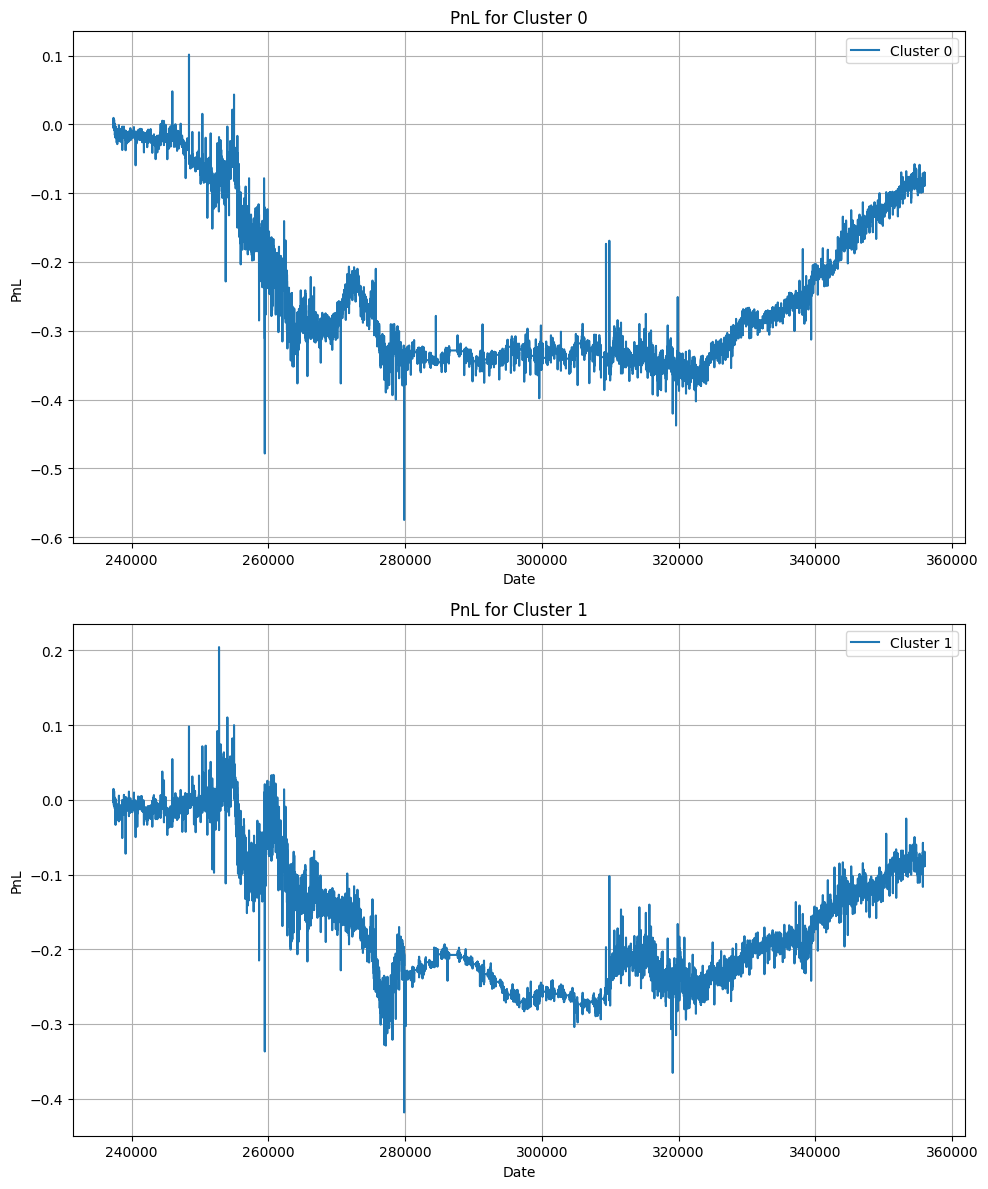

In [63]:
pnl_data = []
sharpe_list = []
result = None
trade_threshold  = 0.0005

# Create a single figure and set of subplots
fig, axes = plt.subplots(len(selected_columns_cluster), figsize=(10, 12))

for idx, data_item in enumerate(selected_columns_cluster):
#     _, hold_out_cols = split_data(data_item)
    train_cols, _ = split_data(data_item)
    optuna_data = scale_data(train_cols)
    _, hold_out_cols = split_data(data_item)
    optuna_data = optuna_data.replace([np.inf, -np.inf], np.nan)
    optuna_data = optuna_data.fillna(0).astype(np.float64)
    hold_out_cols = hold_out_cols.replace([np.inf, -np.inf], np.nan)
    hold_out_cols = hold_out_cols.fillna(0).astype(np.float64)

    xbg_reg = GradientBoostingRegressor()
    # Create and train model
#     xbg_reg.load_model(f"best_in_cluster_{idx}.json")
    with open(f"best_in_cluster_{idx}.pkl", 'rb') as f:
        xbg_reg = pickle.load(f)
    # Make predictions
    hold_out_cols.columns = optuna_data.columns
    y_hold_out = xbg_reg.predict(hold_out_cols)
    pos, pnl, daily, sharpe = sharpe_for_vn30f(y_hold_out, hold_out['Return'], trade_threshold=trade_threshold, fee_perc=0.01, periods=10)

    print(f"Pnl ratio for cluster {idx}: {pnl}")
    # Append PnL data to the list
    pnl_data.append(pnl)
    result = return_result_df(hold_out, y_hold_out, data, train_data, pos, pnl)
    sharpe_list.append(sharpe)
    
    # Plot PnL for each cluster
    if len(selected_columns_cluster) == 1:
        ax = axes
    else:
        ax = axes[idx]

    ax.plot(pnl, label=f'Cluster {idx}')
    ax.set_title(f'PnL for Cluster {idx}')
    ax.set_xlabel('Date')
    ax.set_ylabel('PnL')
    ax.legend()
    ax.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

In [64]:
#Top 10 feature into list
feature=[]
for i in top_10_features_per_cluster:
    listToStr = ' '.join([str(elem) for elem in i])
    feature.append(listToStr)
print(feature)

['4 11 10 6 2 1 9 5 0 7', '14 13 4 6 2 11 0 3 7 1']


In [65]:
name=[]
for i in range(len(selected_columns_cluster)):
  name.append( 'Cluster '+ str(i))

In [66]:
dict = {'Top 10 Feature' : feature, 'Best params': best_params_list, 'Best sharpe':sharpe_list}
df_result = pd.DataFrame(dict, index=name)
df_result

,Top 10 Feature,Best params,Best sharpe
Cluster 0,4 11 10 6 2 1 9 5 0 7,"{'n_estimators': 116, 'learning_rate': 0.09309...",-0.247826
Cluster 1,14 13 4 6 2 11 0 3 7 1,"{'n_estimators': 228, 'learning_rate': 0.01483...",-0.228393


In [67]:
#DataFrame of Pnl hold out
df_pnl = pd.DataFrame()
for i in range(len(selected_columns_cluster)):
  df_pnl[name[i]]=pnl_data[i]
df_pnl

,Cluster 0,Cluster 1
237331,NaN,NaN
237332,NaN,NaN
237333,NaN,NaN
237334,NaN,NaN
237335,NaN,NaN
...,...,...
355991,-0.073918,-0.073208
355992,-0.085752,-0.085043
355993,-0.080846,-0.080136
355994,-0.081780,-0.081070


In [68]:
df_result.to_csv('gbr_result.csv')